In [1]:
"""Scripts for analyzing of phantom outputs.

This script generate lightcurves (LC) by doing radiative transfer on a grid.


-------------------------------------------------------------------------------

Side note: Remember to limit line length to 79 characters according to PEP-8
    https://peps.python.org/pep-0008/#maximum-line-length    
which is the length of below line of '-' characters.

-------------------------------------------------------------------------------

"""

"Scripts for analyzing of phantom outputs.\n\nThis script generate lightcurves (LC) by doing radiative transfer on a grid.\n\n\n-------------------------------------------------------------------------------\n\nSide note: Remember to limit line length to 79 characters according to PEP-8\n    https://peps.python.org/pep-0008/#maximum-line-length    \nwhich is the length of below line of '-' characters.\n\n-------------------------------------------------------------------------------\n\n"

In [32]:
import copy
import numpy as np
from numpy import pi
from numpy import typing as npt
from astropy import units
from astropy import constants as const
from clmuphantomlib.log import is_verbose, say
from clmuphantomlib import MyPhantomDataFrames, get_eos, get_eos_opacity
from clmuphantomlib.eos   import EoS_MESA_opacity
from clmuphantomlib.units_util import get_val_in_unit
from _sharedFuncs import mpdf_read

def gen_Tscales(
    job_name: str,
    T_ph : units.Quantity,
    R_ph : units.Quantity,
    do_save: bool = True,
    params : dict = {'X':0.7, 'Z':0.0},
    verbose: int = 3,
) -> MyPhantomDataFrames:
    """Generate scales at t=0 to scale down temperatures of outter particles.
    
    So temperatures outside the MESA-calculated photosphere
    is scaled down to the MESA values.
    This can be applied to later times,
    so we can see how much the effect of the instable init
    of MESA -> Phantom dump can be.

    ---------------------------------------------------------------------------
    """
    mpdf = mpdf_read(
        job_name, file_index=0, reset_xyz_by='', params=params,
        calc_params=['R1'], verbose=verbose)

    # particle indexes
    inds = mpdf.get_val('R1') > R_ph
    scales = np.zeros(
        np.count_nonzero(inds),
        dtype=[('iorig', np.int64), ('T_scale', np.float64)])
    # particle ids
    #    retrieve back inds from ids by inds_new = mpdf.data['gas']['iorig'].isin(ids)
    scales['iorig'] = mpdf.data['gas']['iorig'][inds]
    scales['T_scale'] = (T_ph / mpdf.get_val('T')[inds]).to_value(
        units.dimensionless_unscaled)
    # scale down only, do not heat the particles
    scales['T_scale'][scales['T_scale'] > 1.] = 1.

    if do_save:
        filename = f"{job_name}_Tscales.npy"
        say('note', None, verbose, f"Saving to {filename}")
        with open(filename, 'wb') as fp:
            np.save(fp, scales)

    return scales

.

# Def

.

## Imports & Settings

In [3]:
import numpy as np
from numpy import pi
from astropy import units
from astropy import constants as const
import matplotlib.pyplot as plt
from matplotlib.typing import ColorType
import matplotlib as mpl
from numba import jit,njit, prange
import sarracen
import itertools
from scipy import integrate, fft
from scipy.spatial import kdtree
from datetime import datetime
# fix weird moviepy cannot find my ffmpeg exe error
try: from moviepy import editor
except RuntimeError: import os; os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"
from moviepy.editor import ImageSequenceClip, concatenate_videoclips
import gc
#from os import path

In [4]:
# import my modules listed in ./main/

import clmuphantomlib as mupl
from clmuphantomlib            import MyPhantomDataFrames, get_eos
from clmuphantomlib.log        import is_verbose, say
from clmuphantomlib.settings   import DEFAULT_SETTINGS as settings
from clmuphantomlib.units_util import get_val_in_unit, set_as_quantity #, get_units_field_name, get_units_cgs
from clmuphantomlib.io         import json_dump, json_load
from clmuphantomlib.eos.mesa   import EoS_MESA_opacity
from clmuphantomlib.light      import get_optical_depth_by_ray_tracing_3D, get_photosphere_on_ray

from multiprocessing import cpu_count, Pool #Process, Queue
NPROCESSES = 1 if cpu_count() is None else max(cpu_count(), 1)

In [5]:
# settings
#
#   imported from script_input.py file


from script_LCGen__input import verbose, verbose_loop, interm_dir, output_dir, unitsOut, SPEC_DIST, PHOTOSPHERE_TAU, JOB_PROFILES_DICT
from _sharedFuncs import mpdf_read, pa_read_energy, pa_read_ev

# remove temp flag
interm_dir = interm_dir.split('test_')[0]
interm_dir = interm_dir.split('Tscale_')[0]
interm_dir = interm_dir.split('Tcut_')[0]
interm_dir = interm_dir.split('Tdelete_')[0]
# interm_dir = interm_dir.split('olim_')[0]


unitsOutTxt = {  key  : unitsOut[key].to_string('latex_inline') for key in unitsOut.keys() }

spec_dist = SPEC_DIST

# set metadata
with open("_metadata__input.json", 'r') as f:
    metadata = json_load(f)
metadata['Title'] = "Getting light curves by intergrating across a grid of rays"
metadata['Description'] = f"""Getting light curves by intergrating across a grid of rays with the same directions
for dump file data generated by phantom
"""


plt.rcParams.update({'font.size': 20})
if __name__ == '__main__' and is_verbose(verbose, 'note'):
    # remember to check if name is '__main__' if you wanna say anything
    #    so when you do multiprocessing the program doesn't freak out
    say('note', None, verbose, f"{interm_dir = }")
    say('note', None, verbose, f"Will use {NPROCESSES} processes for parallelization")


*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	interm_dir = '../interm/olim_'
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Will use 8 processes for parallelization


In [6]:
from clmuphantomlib.log import say, is_verbose
from clmuphantomlib.geometry import get_dist2_between_2pt, get_closest_pt_on_line
from clmuphantomlib.sph_interp import get_sph_interp, get_h_from_rho, get_no_neigh, _get_sph_interp_phantom_np
from clmuphantomlib.units_util import set_as_quantity, set_as_quantity_temperature, get_units_field_name
from clmuphantomlib.eos   import EoS_Base
from clmuphantomlib.light import integrate_along_ray_grid, integrate_along_ray_gridxy

#  import (general)
import numpy as np
import numba
from numba import jit, njit, prange
import sarracen
from scipy.stats import linregress

from clmuphantomlib.geometry import get_dist2_from_pts_to_line, get_dist2_from_pt_to_line_nb, get_ray_unit_vec, get_rays_unit_vec

## Functions

In [7]:
# load from matin script

# rays grid generation, plotting
from script_LCGen import get_xy_grids_of_rays, plot_imshow
# error estimation
from script_LCGen import get_sph_neighbours, get_sph_error

In [8]:
def plot_comb(
    comb : dict,
    mode : str,
    output_dir: str,
    job_nicknames: list[str] = None,
    xyzs_list    : list[str] = None,
    plot_title_dict = {},
    outfilename_noext: None|str = None,
    out_savename : None|str = None,
    no_xy_txt    : None|str = None,
    xlim: None|tuple[float, float] = None,
    ylim: None|tuple[float, float] = None,
    whatlog      : str ='loglog',
    out_exts     : list[str] = ['pdf', 'png'],
    xyzs_V_list  : list[str] = ['xyz', 'xzy', 'yzx'],
    txt_ylabel_dict: dict = {
        'LC'  : 'Luminosity',
        'Nres': '$N_\\mathrm{res}$',
        'Rph' : '$R_\\mathrm{{ph}}$',
        'Aph' : '$A_\\mathrm{{ph}}$',
    },
    txt_title_dict: None|dict = {
        'LC'  : 'Light curves',
        'Nres': 'Photospheric Resolution',
        'Rph' : 'Photospheric radius',
        'Aph' : 'Photospheric area',
    },
) -> tuple[mpl.figure.Figure, mpl.axes.Axes, list[str]]:
    """Plot the lightcurve-related stuff from comb (combined data) generated by the script.

    outfilename_noext, out_savename, no_xy_txt: str
        supply either outfilename_noext or both out_savename & no_xy_txt.

    out_exts: str


    Returns: fig, ax, outfilenames
    
    """

    # sanity check
    if mode not in txt_ylabel_dict.keys():
        raise NotImplementedError(f"{mode=} not yet implemented. Acceptable modes: {txt_ylabel_dict.keys()}")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    which_func = {
        'linear'  : ax.plot,
        'plot'    : ax.plot,
        'semilogx': ax.semilogx,
        'semilogy': ax.semilogy,
        'loglog'  : ax.loglog,
    }
    
    _job_nicknames = comb.keys() if job_nicknames is None else job_nicknames
    for job_nickname in _job_nicknames:

        # # calc total volume of photosphere for latering calc-ing Rph
        # if mode in {'Rph'}:
        #     Axyz = [comb[job_nickname][xyzs_V]['areas'].value/pi for xyzs_V in xyzs_V_list]
        #     V_total = np.prod(Axyz, axis=0)**0.5 * comb[job_nickname][xyzs_V_list[0]]['areas'].unit**1.5
        # else:
        #     V_total = None

        _xyzs_list = comb[job_nickname] if xyzs_list is None else xyzs_list
        for i_xyzs, xyzs in enumerate(_xyzs_list):

            color = f'C{i_xyzs}'
            
            x = comb[job_nickname][xyzs]['times']
            y_err = None
            if   mode in {'LC'}:
                y = comb[job_nickname][xyzs]['lums']
                if 'lums_err' in comb[job_nickname][xyzs].keys():
                    say('note', None, verbose, "Adding y error bars..")
                    y_err = (comb[job_nickname][xyzs]['lums_err']).to(y.unit)
            elif mode in {'Nres'}:
                y = comb[job_nickname][xyzs]['N_res']
            elif mode in {'Rph'}:
                # y = V_total / (comb[job_nickname][xyzs]['areas']/pi)
                y = np.sqrt(comb[job_nickname][xyzs]['areas'] / pi)
            elif mode in {'Aph'}:
                y = comb[job_nickname][xyzs]['areas']
            
            which_func[whatlog](x, y, '-', label=f"{job_nickname}, +{xyzs[2]}", color=color)
            if y_err is not None:
                ax.fill_between(x.value, (y - y_err).value, (y + y_err).value, color=color, alpha=0.5)
            
    ax.legend()
    ax.set_xlabel(f"Time / {x.unit.to_string('latex_inline')}")
    # set y label (remove slash if unit is dimensionless)
    ylabel = f"{txt_ylabel_dict[mode]} / {y.unit.to_string('latex_inline')}" if y.unit.to_string() else f"{txt_ylabel_dict[mode]}"
    ax.set_ylabel(f"{ylabel}")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if outfilename_noext is None:
        outfilename_noext = f"{output_dir}{mode}_{out_savename}_{no_xy_txt}"
    elif output_dir is not None:
        outfilename_noext = f"{output_dir}{outfilename_noext}"
    
    # write pdf
    outfilenames = []
    for out_ext in out_exts:
        if out_ext == 'pdf':
            if job_nickname in plot_title_dict.keys():
                ax.set_title(plot_title_dict[job_nickname])
            else:
                ax.set_title('')
            outfilename = f"{outfilename_noext}.{out_ext}"
            fig.savefig(outfilename)
            if is_verbose(verbose, 'note'):
                say('note', None, verbose, f"Fig saved to {outfilename}.")
            outfilenames.append(outfilename)
        else:
            title_txt  = mode if txt_title_dict is None else txt_title_dict[mode]
            title_txt += f" ({no_xy_txt}"
            if len(job_nicknames) == 1 and job_nickname in plot_title_dict.keys():
                title_txt += f", {plot_title_dict[job_nickname]}"
            title_txt += ")"
            ax.set_title(title_txt)
            outfilename = f"{outfilename_noext}.{out_ext}"
            fig.savefig(outfilename)
            if is_verbose(verbose, 'note'):
                say('note', None, verbose, f"Fig saved to {outfilename}.")
            outfilenames.append(outfilename)

    return fig, ax, outfilenames

In [9]:
def plot_heat(
    no_xy: tuple[int, int],
    rays: units.Quantity|np.ndarray,
    data: units.Quantity|np.ndarray,
    fig = None, ax = None, plot_cbar: bool= True,
    job_profile  : dict= None,
    file_index   : int = -1,
    title_suffix : str ="",
    notes        : dict= None,
    data_label   : str ="",
    save_label   : str ="",
    ylabelpad    : None|float = None,
    xyzs         : str|list[str] = 'xyz',
    out_exts     : list[str] = ['pdf', 'png'],
    nlevel       : int = 100,
    levels       : None|list[float] = None,
    ticks        : None|int|list[float] = None,
    cbar_num_fmt : None|type(abs) = None,
    facecolor    : None|ColorType = None,
    text_color   : None|str = None,
    xylim : None|tuple[float, float] = None,
    norm=None,
    cmap=None,
    output_dir:str|None=None,
    verbose = 3,
):
    """Plotting a heatmap (contourf) of 1D data located at rays

    cbar_num_fmt: function
        colorbar label format.
        e.g. lambda x, pos: f"{x:.2e}"
    
    """


    if not isinstance(data, units.Quantity):
        data = set_as_quantity(data, units.dimensionless_unscaled)

    if not isinstance(rays, units.Quantity):
        rays = set_as_quantity(rays, units.dimensionless_unscaled)

    if job_profile is None:
        job_profile = {
            'plot_title_suffix': '',
            'nickname'         : '',
        }

    Xs = rays[:, 0, 0]
    Ys = rays[:, 0, 1]
    rays_val = rays.reshape(*no_xy, *rays.shape[1:]).value
    extent = (
        rays_val[ 0, 0, 0, 0] - (rays_val[ 1, 0, 0, 0] - rays_val[ 0, 0, 0, 0])/2,
        rays_val[-1,-1, 0, 0] + (rays_val[-1,-1, 0, 0] - rays_val[-2,-1, 0, 0])/2,
        rays_val[ 0, 0, 0, 1] - (rays_val[ 0, 1, 0, 1] - rays_val[ 0, 0, 0, 1])/2,
        rays_val[-1,-1, 0, 1] + (rays_val[-1,-1, 0, 1] - rays_val[-1,-2, 0, 1])/2,
    )
    if xylim is None: xylim  = max([abs(it) for it in extent])
    xylims = (-xylim, xylim)
    if   isinstance(norm, mpl.colors.LogNorm):
        levels = np.logspace(np.log10(norm.vmin), np.log10(norm.vmax), nlevel+1)
    elif isinstance(norm, mpl.colors.Normalize):
        levels = np.linspace(norm.vmin, norm.vmax, nlevel+1) if levels is None else levels
        if isinstance(ticks, int):
            ticks  = np.linspace(norm.vmin, norm.vmax, ticks+1)
    else:
        levels = nlevel if levels is None else levels
        

    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    
    #cax = ax.imshow(data.reshape(no_xy).T.value, norm=norm, cmap=cmap, origin='lower', extent=extent)
    if facecolor is None: facecolor = plt.get_cmap(cmap).get_under()
    ax.set_facecolor(facecolor)
    cax = ax.contourf(Xs.reshape(no_xy).value, Ys.reshape(no_xy).value, data.reshape(no_xy).value, levels, norm=norm, cmap=cmap, extend='both')
    for c in cax.collections:
        c.set_edgecolor("face")
    if plot_cbar:
        cbar= fig.colorbar(cax, label=f"{data_label} / {data.unit.to_string('latex_inline')}", ticks=ticks, format=cbar_num_fmt)
    ax.set_xlabel(f"${xyzs[0]}$ / {rays.unit.to_string('latex_inline')}")
    ax.set_ylabel(f"${xyzs[1]}$ / {rays.unit.to_string('latex_inline')}", labelpad=ylabelpad)
    ax.set_xlim(xylims)
    ax.set_ylim(xylims)
    ax.set_title('')
    if notes is not None:
        ax.text(
            0.98, 0.98,
            f"Time = {notes['time']:.1f}\n",
            # + f" $L$ = {notes['lum' ]:.0f}",
            color = text_color,
            ha = 'right', va = 'top',
            transform=ax.transAxes,
        )

    no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
    outfilename_noext = f"{output_dir}heat_{job_profile['nickname']}_{file_index:05d}_{''.join(xyzs)}_{save_label}_{no_xy_txt}"
    outfilenames = []

    # write pdf
    for out_ext in out_exts:
        outfilename = f"{outfilename_noext}.{out_ext}"
        if out_ext == 'pdf':
            ax.set_title('')
        else:
            ax.set_title(f"Heatmap of {data_label}\n{job_profile['plot_title_suffix']}")
        fig.savefig(outfilename)
        outfilenames.append(outfilename)
        if is_verbose(verbose, 'note'):
            say('note', None, verbose, f"Fig saved to {outfilename}.")
        
    return fig, cax, outfilenames

## example
#fig, ax = plot_imshow(
#    no_xy, rays * units.Rsun, anses, data_label="$I$", save_label="I_xyz",
#    job_profile=job_profile, file_index=file_index, output_dir=output_dir)

## Main

### Init

In [21]:
# settings

output_dir = f'../fig/20240222_LCGen/'
job_nicknames = ['2md'] #['2m_2022'] #['2md'] #['4md'] #
def get_out_savename(job_nicknames):
    if job_nicknames is None:    return None
    elif len(job_nicknames) > 1: return 'dusty'
    else:                        return  job_nicknames[0]
out_savename = get_out_savename(job_nicknames)
xyzs_list = None #['xyz', 'xzy'] #None

unit_I = units.erg/units.cm**2/units.s/units.rad**2

do_plots = {
    'LC'  : {
        'do_this': True,
        'xlim'   : (0.1, 15.),#( 0., 5.),
        'ylim'   : (5e3, 1e7),
        'whatlog': 'semilogy',
        },
    'Nres': {
        'do_this': True,
        'xlim'   : (0., 5.),#( 0., 45.),
        'ylim'   : (1.0, 1e3),
        'whatlog': 'semilogy',
        },
    'Rph' : {
        'do_this': True,
        'xlim'   : ( 0., 5.), # ( 0., 45.), # 
        'ylim'   : ( 0., 100.), # ( 0., 700.), # (1e0, 1e3),
        'whatlog': 'plot', #'semilogy',
        },
    'Aph' : {
        'do_this': True,
        'xlim'   : ( 0., 5.),
        'ylim'   : ( 0., 2e4), #( 0., 3e5), # (1e1, 1e6),
        'whatlog': 'plot', #'semilogy',
        },
}
plot_title_dict = {
    '2md': '$1.7 M_\\odot$',
    '4md': '$3.7 M_\\odot$',
}

In [11]:
if False:
    interm_dir = '../interm/'
    raise NotImplementedError("Temp alteration")

In [12]:
# patching

# JOB_PROFILES_DICT['2md']['file_indexes'] = JOB_PROFILES_DICT['2md']['file_indexes'][JOB_PROFILES_DICT['2md']['file_indexes']<=17250]

# additional_interm_files = []
additional_interm_files = [
    # (f"{interm_dir}lcgen.256x256.4md.json", "256x256", {"4md": "4md"}),
    # (f"{interm_dir}lcgen.256x256.2md.hdf5", "256x256", {"2md": "2md_olim"}),
]

# raise ValueError("WARNING: TEMP VER FOR OLIM- REVERT TO ORIGINAL BEFORE CONTINUE")

In [34]:
if True:
    interm_dir = interm_dir.split('olim_')[0]
    for rays_res in [256]:
        no_xy = (rays_res, rays_res)
        no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
        if no_xy_txt not in combs:
            combs[no_xy_txt] = {}
        for nickname in ['2md', '4md']:
            filepath = f"{interm_dir}lcgen.{no_xy_txt}.{nickname}.json" # .2md.hdf5
            print(f"Reading from '{filepath}'...", end=' ')
            with open(filepath, 'r') as f:
                temp_dict = mupl.json_load(f)
            for k in temp_dict.keys():
                combs[no_xy_txt][k] = temp_dict[k]
            print("Done.")
    interm_dir += 'olim_'

Reading from '../interm/lcgen.256x256.2md.json'... Done.
Reading from '../interm/lcgen.256x256.4md.json'... Done.


In [14]:
# read data ( existing intermediate files (summary))
if __name__ == '__main__':
    combs = {}
    plt.close('all')

    for rays_res in [256]: #[16, 64, 256]:#[16, 64, 256]: #[16, 32, 64, 128, 256]:
        no_xy = (rays_res, rays_res)
        no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
        if no_xy_txt not in combs:
            combs[no_xy_txt] = {}
        for nickname in ['2md', '2mddo', '2mdd', '2mdc', '4mddo']:
            filepath = f"{interm_dir}lcgen.{no_xy_txt}.{nickname}.hdf5" # .2md.hdf5
            print(f"Reading from '{filepath}'...", end=' ')
            combs[no_xy_txt] |= mupl.hdf5_load(filepath)
            print("Done.")

    for filepath, no_xy_txt, nickname_dict in additional_interm_files:
        print(f"Reading from '{filepath}'...", end=' ')
        if filepath.endswith('.json'):
            with open(filepath, 'r') as f:
                temp_dict = mupl.json_load(f)
        elif filepath.endswith(('.hdf5', '.hdf5.gz')):
            temp_dict = mupl.hdf5_load(filepath)
            temp_dict = {v: temp_dict[k] for k, v in nickname_dict.items()}
        for k in temp_dict.keys():
            if k != '_meta_':    # safety checks
                if k in combs[no_xy_txt].keys():
                    print(f"\n\t*** WARNING: Overwriting {k} data using {filepath} ***")
                combs[no_xy_txt][k] = temp_dict[k]
        print("Done.")

    # patch
    combs_all = combs
    combs = {k: combs[k] for k in ['256x256']}

Reading from '../interm/olim_lcgen.256x256.2md.hdf5'... *   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/olim_lcgen.256x256.2md.hdf5  (compress=False)
Done.
Reading from '../interm/olim_lcgen.256x256.2mddo.hdf5'... *   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/olim_lcgen.256x256.2mddo.hdf5  (compress=False)
Done.
Reading from '../interm/olim_lcgen.256x256.2mdd.hdf5'... *   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/olim_lcgen.256x256.2mdd.hdf5  (compress=False)
Done.
Reading from '../interm/olim_lcgen.256x256.2mdc.hdf5'... *   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/olim_lcgen.256x256.2mdc.hdf5  (compress=False)
Done.
Reading from '../interm/olim_lcgen.256x256.4mddo.hdf5'... *   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/olim_lcgen.256x256.4mddo.hdf5  (compress=False)
Done.


In [15]:
# patching data from individual files
patching_combs = False
if __name__ == '__main__' and patching_combs:
    rays_res = 256
    xyzs_list = ['xyz', 'xzy', 'yzx']
    no_xy = (rays_res, rays_res)
    no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
    
    for job_nickname in ['2md']: #job_nicknames:
        data = {}
        job_profile = JOB_PROFILES_DICT[job_nickname]
        job_name    = job_profile['job_name']
        file_indexes= job_profile['file_indexes']

        # init
        combs[no_xy_txt][job_nickname] = {
            xyzs: {
                'times': np.full(len(file_indexes), np.nan) * units.yr,
                'lums' : np.full(len(file_indexes), np.nan) * units.Lsun,
                'lums_err': np.full(len(file_indexes), np.nan) * units.Lsun,
                'areas': np.full(len(file_indexes), np.nan) * units.au**2,
                # no of particles at the photosphere - lower bound (weighted average per pixel, weighted by lums contribution)
                # i.e. how resolved the photosphere is
                'N_res': np.full(len(file_indexes), -1) * units.dimensionless_unscaled,
                'wavlens': None,
                'L_wavs': None, #np.full((len(file_indexes), len(wavlens)), np.nan) * (units.Lsun/units.angstrom),
                '_meta_': {
                    'lums' : { 'Description': "Luminosity.", },
                    'areas': { 'Description': (
                        "Visible size of the simulated object." +
                        "(i.e. pixel * (area per pixel) * (tau if tau<1 else 1)"), },
                    'N_res': { 'Description': (
                            "no of particles at the photosphere - lower bound" +
                            "(weighted average per pixel, weighted by lums contribution per pixel)"), },
                },
            } for xyzs in xyzs_list
        }
        ifile, file_index = 0, file_indexes[0]
        data_full = mupl.hdf5_load(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{no_xy_txt}.hdf5")
        for xyzs in xyzs_list:
            comb = combs[no_xy_txt][job_nickname][xyzs]
            data = data_full[xyzs]
            comb['wavlens'] = data['wavlens']
            comb['L_wavs'] = np.full((len(file_indexes), len(data['wavlens'])), np.nan) * (units.Lsun/units.angstrom)
            

        for ifile, file_index in enumerate(file_indexes):
            data_full = mupl.hdf5_load(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{no_xy_txt}.hdf5")
            xyzs_list = list(data_full.keys()).copy() if xyzs_list is None else xyzs_list

            for xyzs in xyzs_list:
                comb = combs[no_xy_txt][job_nickname][xyzs]
                data = data_full[xyzs]
                comb['times'][ifile] = data['time']
                comb['lums' ][ifile] = data['lum']
                comb['lums_err'][ifile] = data['lum_err']
                comb['areas'][ifile] = data['area_one']
                comb['N_res'][ifile] = data['N_res']
                comb['L_wavs'][ifile] = data['L_wavs']

        # save
        if False:
            # safety
            assert job_nickname=='2md' and no_xy_txt=='256x256'
            filepath=f"{interm_dir}lcgen.{no_xy_txt}.{job_nickname}.hdf5"
            print(f"\n\t*** WARNING: Overwriting {filepath} data ***")
            mupl.hdf5_dump(combs[no_xy_txt][job_nickname], filepath)
    

In [16]:
job_nickname = '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name = job_profile['job_name']
eos_opacity=get_eos_opacity(ieos=job_profile['ieos'], params=job_profile['params'])
mpdf = mpdf_read(job_profile['job_name'], 0, eos_opacity, verbose=1)

In [17]:
def get_Es(
    job_nickname = '2md',
    file_index_end = 17600,
):
    
    job_profile = JOB_PROFILES_DICT[job_nickname]
    X, Z, mu = job_profile['params']['X'], job_profile['params']['Z'], job_profile['params']['mu']
    Y = 1 - X - Z
    
    m_H = const.m_p + const.m_e
    E_rec = 13.6 * units.eV
    m_env = 1.14 * units.Msun
    
    # recombination energy release potential
    E_rec_pot = (E_rec * (m_env / m_H * X)).cgs

    E_sep_list = []
    
    eos_opacity=get_eos_opacity(ieos=job_profile['ieos'], params=job_profile['params'])
    
    # t=0
    mpdf = mpdf_read(job_profile['job_name'], 0, eos_opacity, verbose=1)
    _, sdf_sink = mpdf.data['gas'], mpdf.data['sink']
    ms_sep = units.Quantity(sdf_sink['m'], mpdf.units['mass'])
    if True:
        # init from t=0
        ms_sep[0] = 1.7*units.Msun
        # number of gas particles in each SPH particle
        #    assuming mass is the same
        N_gas_en_SPH = (mpdf.get_val('m')[0] / (const.m_p * mu)).si
    v2s_sep = units.Quantity(sdf_sink['vx']**2 + sdf_sink['vy']**2 + sdf_sink['vz']**2, mpdf.units['speed']**2)
    # kinetic and gravity potential energy
    E_sep_0 = (-const.G * ms_sep[0] * ms_sep[1] / mpdf.get_orb_sep() + 0.5*np.sum(ms_sep * v2s_sep)).si
    # gas thermal energy
    E_hea_0 = np.sum(1.5 * const.k_B * mpdf.get_val('T') * N_gas_en_SPH)
    
    # t=end
    mpdf = mpdf_read(job_profile['job_name'], file_index_end, eos_opacity, verbose=1)
    _, sdf_sink = mpdf.data['gas'], mpdf.data['sink']
    ms_sep = units.Quantity(sdf_sink['m'], mpdf.units['mass'])
    v2s_sep = units.Quantity(sdf_sink['vx']**2 + sdf_sink['vy']**2 + sdf_sink['vz']**2, mpdf.units['speed']**2)
    # kinetic and gravity potential energy
    E_sep_1 = (-const.G * ms_sep[0] * ms_sep[1] / mpdf.get_orb_sep() + 0.5*np.sum(ms_sep * v2s_sep)).si
    # gas thermal energy
    E_hea_1 = np.sum(1.5 * const.k_B * mpdf.get_val('T') * N_gas_en_SPH)
    
    # gravity and kinetic energy release potential
    #    assuming all SPH particles are unbounded, escaped with E=0 exactly
    E_sep_pot = (E_sep_0 - E_sep_1).cgs
    # thermal energy release potential
    E_hea_pot = E_hea_0.cgs #(E_hea_0 - E_hea_1).cgs

    return E_rec_pot, E_sep_pot, E_hea_pot

### Surface ignore srcfunc condition

In [17]:
from scipy.integrate import quad
kernel = mpdf.data['gas'].kernel
hfact = 1.2
N_neigh = 4/3*pi * (kernel.get_radius()*hfact)**3
print(f"{N_neigh = }")
w_col, w_csz, w_col_a, w_csz_a = mupl.get_col_kernel_funcs(kernel)

ans = quad(lambda q_xy: 0.5*w_col(q_xy,3)*q_xy, 0., 2.,)
print(f"For particles on the outer side: {N_neigh / 4 = :6.3f}, require ignoring {ans[0]*N_neigh/4 = :19.16f} kernel integration")
print(f"For particles on the outer side: {N_neigh / 2 = :6.3f}, require ignoring {ans[0]*N_neigh/2 = :19.16f} kernel integration")
ans

N_neigh = 57.90583579096705
For particles on the outer side: N_neigh / 4 = 14.476, require ignoring ans[0]*N_neigh/4 =  1.1520012822791486 kernel integration
For particles on the outer side: N_neigh / 2 = 28.953, require ignoring ans[0]*N_neigh/2 =  2.3040025645582971 kernel integration


(0.07957756012279878, 2.7150545067397558e-09)

### single dump rendering

    sdf, sdf_sink = sarracen.read_phantom("../raw/clmu_2mdd/lumo_02000", ignore_inactive=False)
    sdf

In [37]:
job_nickname = '4mddo'
file_index = 1600
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name = job_profile['job_name']
eos_opacity=get_eos_opacity(ieos=job_profile['ieos'], params=job_profile['params'])
mpdf = mpdf_read(job_profile['job_name'], file_index, eos_opacity, verbose=1)
mpdf.data['gas']['kappa_cgs'] = mpdf.get_val('kappa').cgs.value
mpdf.data['gas']['kappaDust_cgs'] = mpdf.get_val('kappaDust').cgs.value
mpdf.data['gas']['kappaGas_cgs'] = (mpdf.get_val('kappa') - mpdf.get_val('kappaDust')).cgs.value

In [38]:
mpdf.data['sink'][['x', 'y', 'z', 'vx', 'vy', 'vz']]

x         y         z        vx        vy        vz
0 -0.790918 -0.746381  0.692831  0.000163  0.000105  0.000032

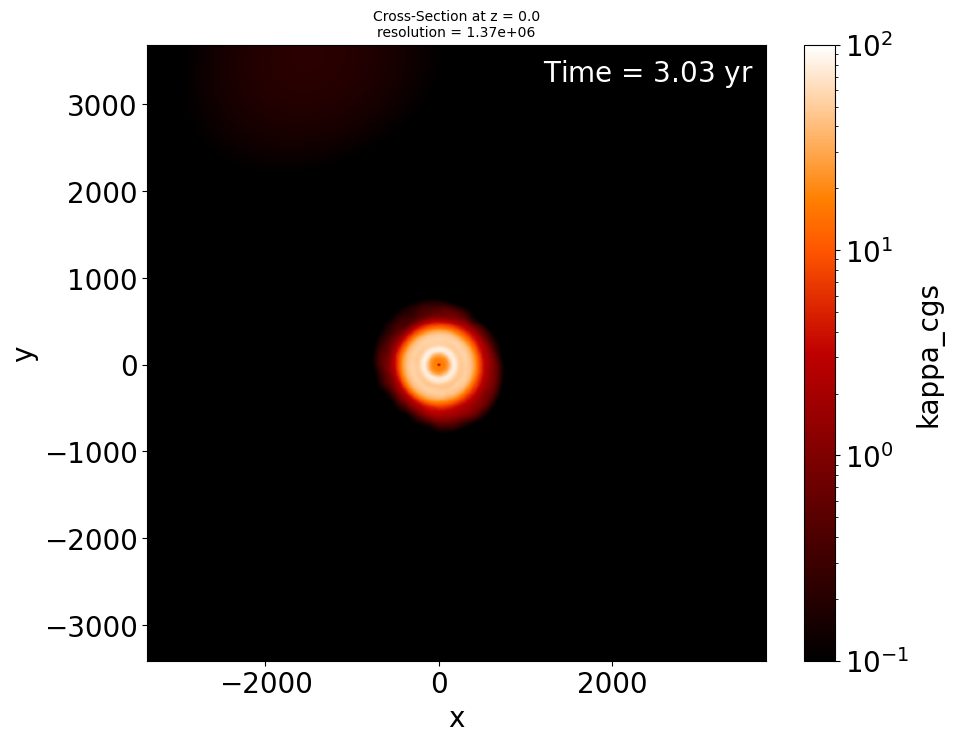

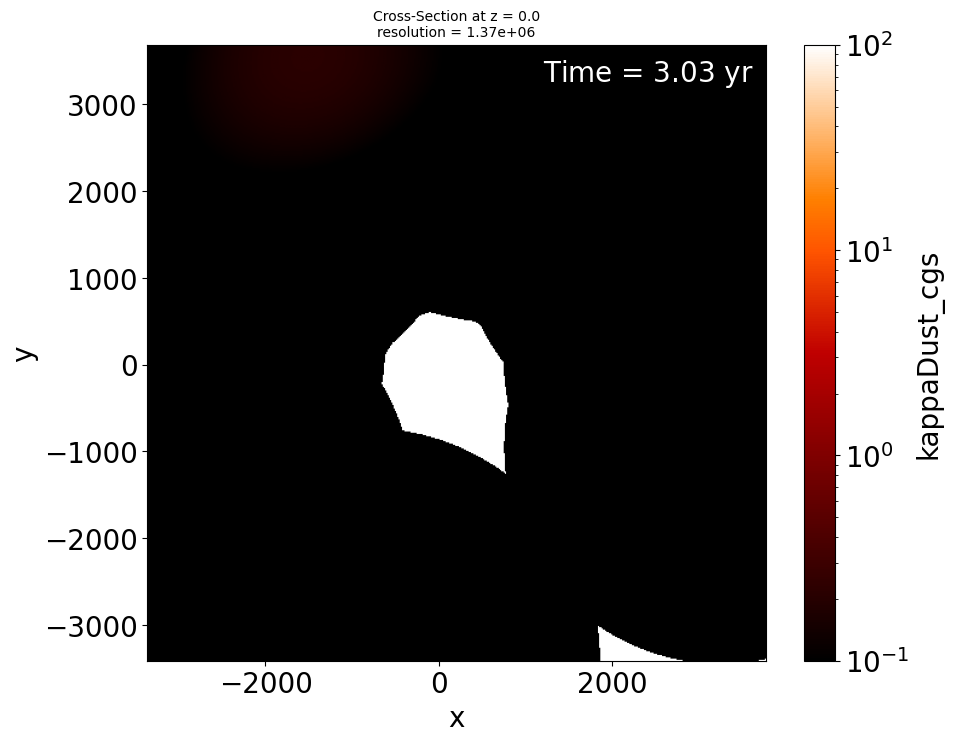

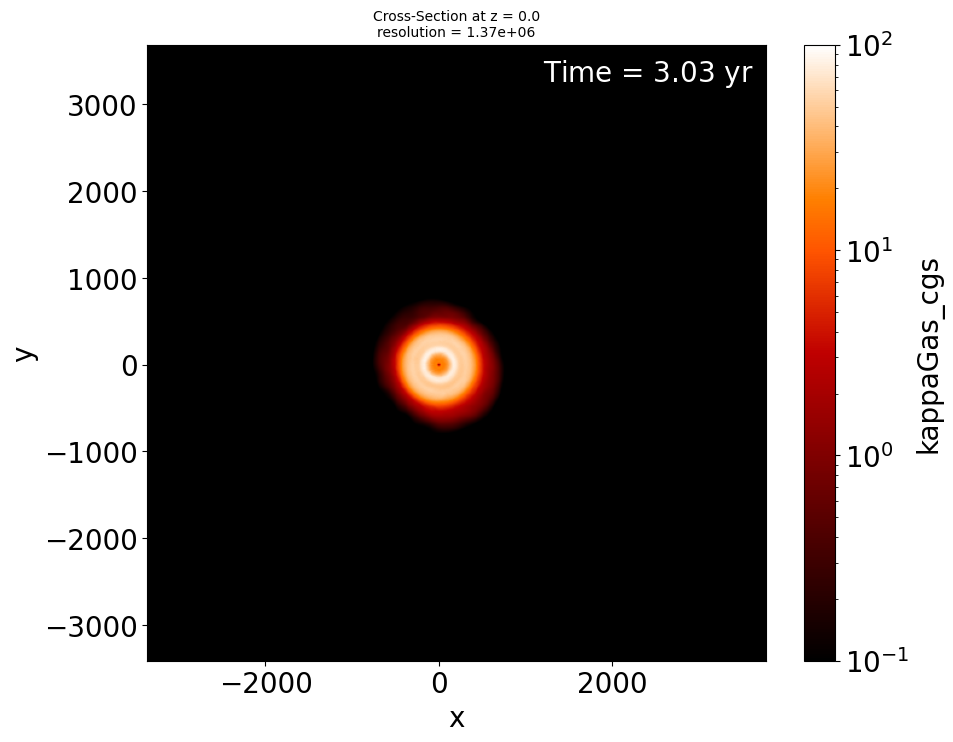

In [30]:
for kappaName in ['kappa', 'kappaDust', 'kappaGas']:
    fig, ax = mpdf.plot_render(rendered=f'{kappaName}_cgs', norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e2), backend='cpu')
    fig.savefig(f"{output_dir}temp_{job_nickname}_{file_index:05d}_{kappaName}.jpg")

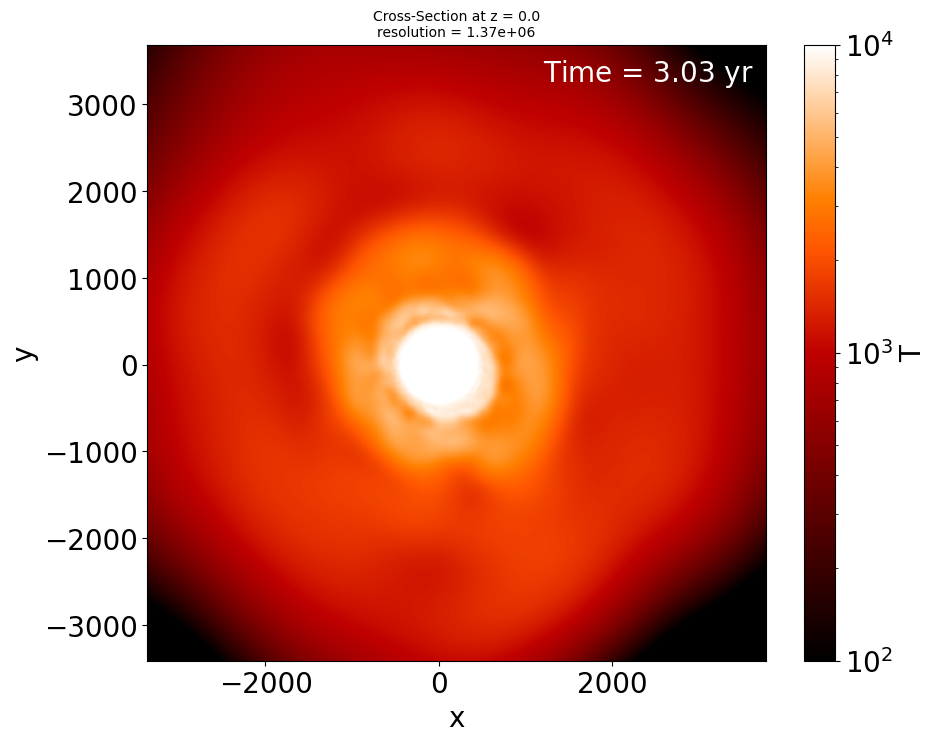

In [33]:
fig, ax = mpdf.plot_render(rendered='T', norm=mpl.colors.LogNorm(vmin=1e2, vmax=1e4), backend='cpu')
fig.savefig(f"{output_dir}temp_{job_nickname}_{file_index:05d}_T.jpg")

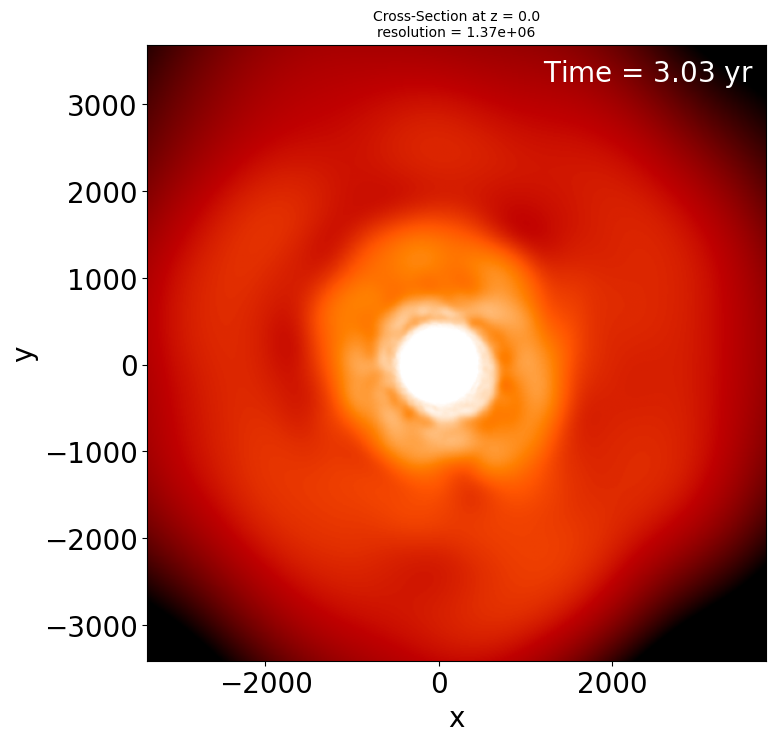

In [55]:
fig, ax = mpdf.plot_render(rendered='T', norm=mpl.colors.LogNorm(vmin=1e2, vmax=1e4), backend='cpu', cbar=False)

### Star Stability test

In [22]:
ss = {}
for nickname in ['2mdd', '2mddo', '4mdd', '4mddo']: #['2mdd', '2mddo']:
    data = np.loadtxt(
        f"{JOB_PROFILES_DICT[nickname]['raw_dir']}/star_stability.ev",
        dtype=[
            ('time', np.float64),
            ('vol_eq_rad', np.float64),
            ('density_rad', np.float64),
            ('mass_outside', np.float64),
            ('frac_outside', np.float64),
            ('part_rad', np.float64),
            ('part_2h_rad', np.float64),
            ('p_dens_rad', np.float64),
            ('p2h_dens_rad', np.float64),
            ('part_virial', np.float64),
            ('fluid_virial', np.float64),
        ],
    )
    times = (data['time'] * mpdf.units['time']).to(units.yr)
    radii = (data[['vol_eq_rad', 'density_rad', 'part_rad', 'part_2h_rad', 'p_dens_rad', 'p2h_dens_rad']] * mpdf.units['dist']).to(units.Rsun)
    ss[nickname] = {
        # 'data': data,
        'times': times,
        'radii': radii,
        'mass' : (data['mass_outside'] * mpdf.units['mass']).to(units.Msun),
        'frac' : (data['frac_outside'] * units.dimensionless_unscaled).to(units.percent),
        'mesa_ph_rad': np.nan*units.Rsun,
    }
    if nickname[0]=='2':
        ss[nickname]['mesa_ph_rad'] = 2.6170359298661680E+002*units.Rsun
    elif nickname[0]=='4':
        ss[nickname]['mesa_ph_rad'] = 3.3074863392632705E+002*units.Rsun

Output to ../fig/20240222_LCGen/StarStability_zoom-in_2mdd.jpg
Output to ../fig/20240222_LCGen/StarStability_zoom-in_2mddo.jpg
Output to ../fig/20240222_LCGen/StarStability_zoom-in_4mdd.jpg
Output to ../fig/20240222_LCGen/StarStability_zoom-in_4mddo.jpg


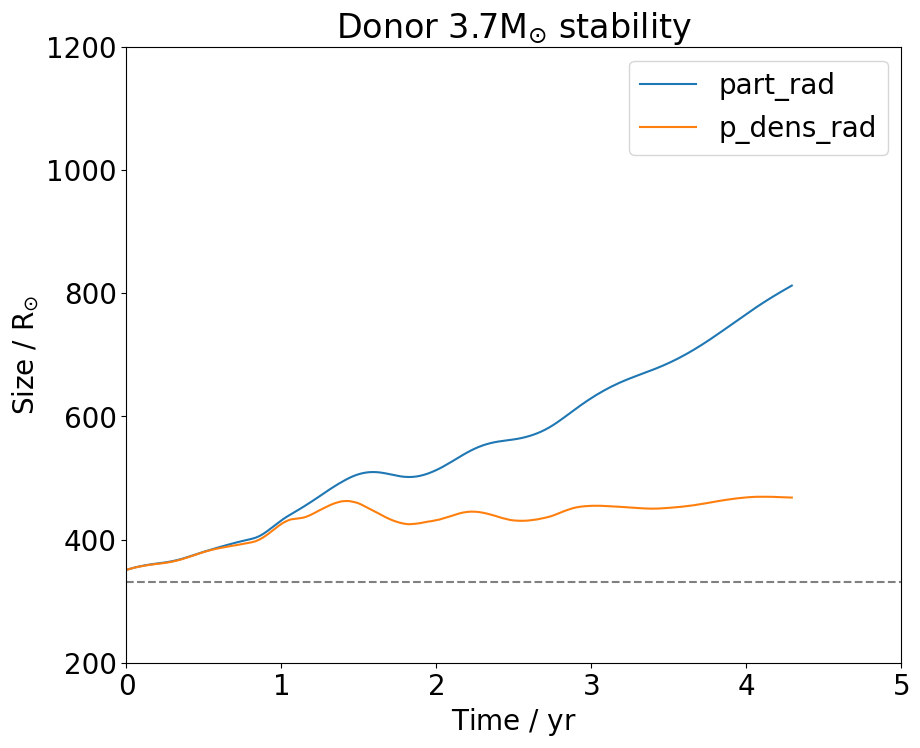

In [23]:
for nickname in ss.keys():
    # nickname = '4mddo'
    plt.close('all')
    fig, ax = plt.subplots(figsize=(10, 8))
    ds = ss[nickname]
    for it, t in enumerate(['part_rad', 'p_dens_rad']): #enumerate(ds['radii'].dtype.names):    #
        ax.plot(ds['times'], ds['radii'][t].to_value(radii.unit), color=f'C{it}', label=f"{t}")
        # ax.plot(ss['2mdd']['times'], ss['2mdd']['radii'][t], '--', color=f'C{it}')#, label=f"2mdd {t}")
    
    ax.set_xlabel(f"Time / {times.unit.to_string('latex_inline')}")
    ax.set_ylabel(f"Size / {radii.unit.to_string('latex_inline')}")
    ax.set_xlim(0, 5)
    ax.set_ylim(200, 1200)
    ax.axhline(ds['mesa_ph_rad'].to_value(radii.unit), linestyle='dashed', color='grey')
    ax.legend()
    ax.set_title(f"{JOB_PROFILES_DICT[nickname]['name']} stability")
    outfilename = f"{output_dir}StarStability_zoom-in_{nickname}.jpg"
    fig.savefig(outfilename)
    print(f"Output to {outfilename}")

Output to ../fig/20240222_LCGen/StarStability_compare1.jpg


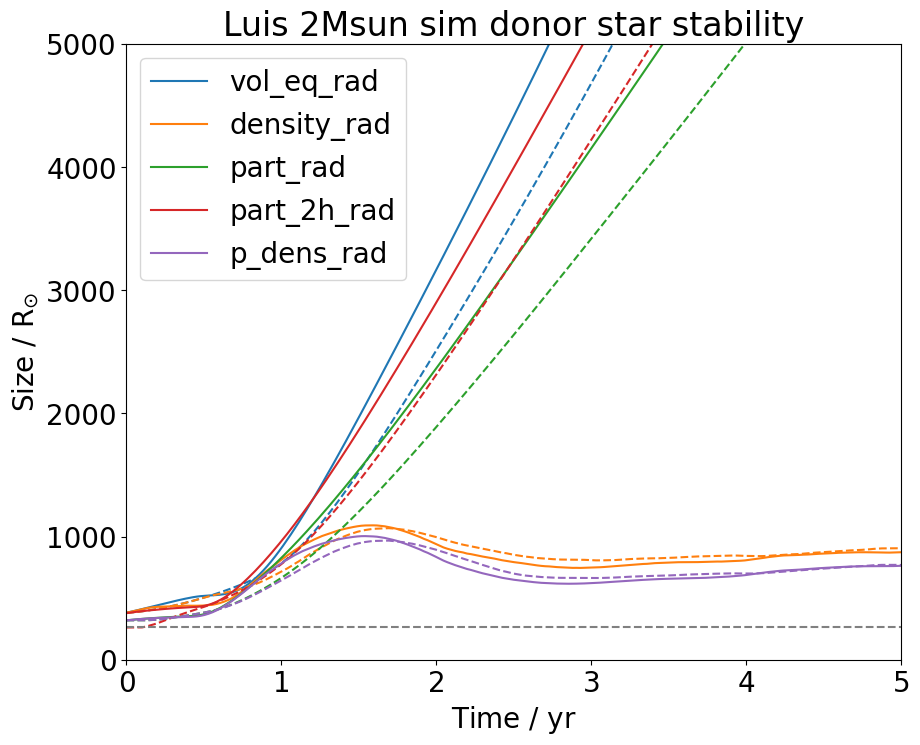

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))

nickname = '2mddo'
ds = ss[nickname]
for it, t in enumerate(ds['radii'].dtype.names[:5]):    # enumerate(['density_rad', 'part_rad', 'part_2h_rad']):
    ax.plot(ds['times'], ds['radii'][t], color=f'C{it}', label=f"{t}")
    ax.plot(ss['2mdd']['times'], ss['2mdd']['radii'][t], '--', color=f'C{it}')#, label=f"2mdd {t}")

ax.set_xlabel(f"Time / {times.unit.to_string('latex_inline')}")
ax.set_ylabel(f"Size / {radii.unit.to_string('latex_inline')}")
ax.set_xlim(0, 5)
ax.set_ylim(0, 5e3)
ax.axhline(261.7, linestyle='dashed', color='grey')
ax.legend()
ax.set_title(f"Luis 2Msun sim donor star stability")
outfilename = f"{output_dir}StarStability_compare1.jpg"
fig.savefig(outfilename)
print(f"Output to {outfilename}")

Output to ../fig/20240222_LCGen/StarStability_compare2.mass.jpg


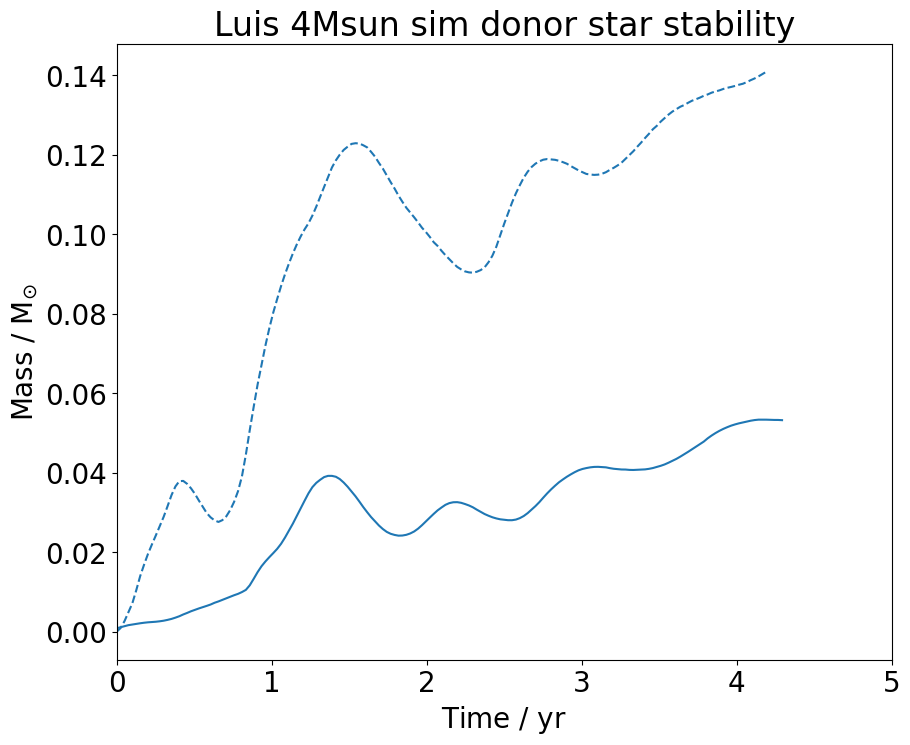

In [40]:
fig, ax = plt.subplots(figsize=(10, 8))

it=0; t='mass'
ax.plot(ss['4mddo']['times'], ss['4mddo']['mass'],       color=f'C{it}', label=f"4mddo {t}")
ax.plot(ss['4mdd' ]['times'], ss['4mdd' ]['mass'], '--', color=f'C{it}', label=f"4mdd {t}")


ax.set_xlabel(f"Time / {times.unit.to_string('latex_inline')}")
ax.set_ylabel(f"Mass / {ss['4mdd']['mass'].unit.to_string('latex_inline')}")
ax.set_xlim(0, 5)
# ax.set_ylim(0, 1.2e3)
# ax.axhline(261.7, linestyle='dashed', color='grey')
# ax.legend()
ax.set_title(f"Luis 4Msun sim donor star stability")
outfilename = f"{output_dir}StarStability_compare2.mass.jpg"
fig.savefig(outfilename)
print(f"Output to {outfilename}")

Output to ../fig/20240222_LCGen/StarStability_compare1.frac.jpg


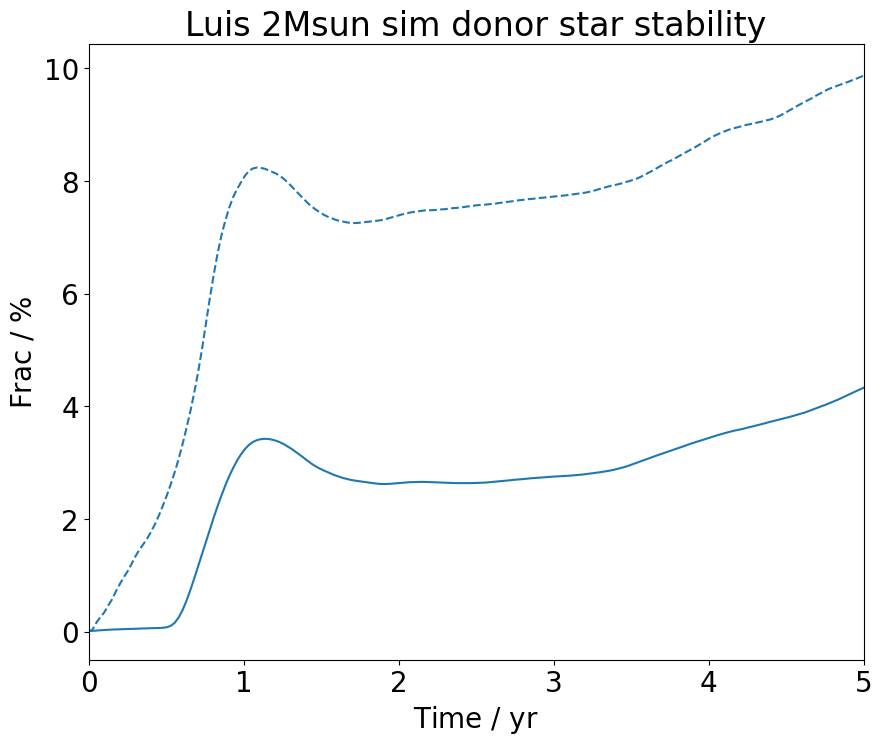

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))

it=0; t='frac'
ax.plot(ss['2mddo']['times'], ss['2mddo']['frac'],       color=f'C{it}', label=f"2mddo {t}")
ax.plot(ss['2mdd' ]['times'], ss['2mdd' ]['frac'], '--', color=f'C{it}', label=f"2mdd {t}")


ax.set_xlabel(f"Time / {times.unit.to_string('latex_inline')}")
ax.set_ylabel(f"Frac / {ss['2mdd']['frac'].unit.to_string('latex_inline')}")
ax.set_xlim(0, 5)
# ax.set_ylim(0, 1.2e3)
# ax.axhline(261.7, linestyle='dashed', color='grey')
# ax.legend()
ax.set_title(f"Luis 2Msun sim donor star stability")
outfilename = f"{output_dir}StarStability_compare1.frac.jpg"
fig.savefig(outfilename)
print(f"Output to {outfilename}")

### Checking data files meta data

In [19]:
job_profile = JOB_PROFILES_DICT['2mdnrs']#'2mdnrs']
mpdf = mpdf_read(job_profile['job_name'], 12, eos_opacity, params=job_profile['params'])
print()
print(mpdf.data['sink'].keys())
print()
print(f"{mpdf.get_val('lum', 'sink').to(units.Lsun) = }")
sdf, sdf_sink = mpdf.data['gas'], mpdf.data['sink']
R2 = np.sum((np.asarray(sdf[['x', 'y', 'z']]) - np.asarray(sdf_sink[['x', 'y', 'z']].iloc[1]))**2, axis=1)**0.5
sdf['R2'] = R2
sdf['R2_div_h2'] = R2/sdf_sink['hsoft'].iloc[-1]
R2 = (R2 * mpdf.units['dist']).to(units.Rsun)
print(f"{R2.min() = }")
mpdf.data['sink'][['x', 'y', 'z', 'm', 'h', 'hsoft', 'massenc', 'lum', 'Teff', 'Reff', 'vx', 'vy', 'vz']]

*   Note   :    <module>() ==> mpdf_read() ==> read():
	

	Reading filename='../raw/clmu_2mdnrs/2mdnrs_00012'


*   Note   :    mpdf_read() ==> read() ==> reset_xyz_by():
	Reseting Origin to CoM ([ 4.03272352e-06 -4.60320524e-06  2.93692783e-06])...
*   Note   :    mpdf_read() ==> read() ==> reset_xyz_by():
	CoM location is now [ 6.16343019e-15 -8.66732370e-16  7.57882385e-17]
**  Warning:    <module>() ==> mpdf_read() ==> read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])

Index(['x', 'y', 'z', 'm', 'h', 'hsoft', 'maccreted', 'spinx', 'spiny',
       'spinz', 'tlast', 'lum', 'Teff', 'Reff', 'mdotloss', 'mdotav', 'mprev',
       'massenc', 'J2', 'Rst

x         y         z         m    h  hsoft   massenc  \
0  -68.945783 -1.415123  0.000053  0.563148  0.0   1.25  0.001928   
1  195.998411  4.022646 -0.000006  0.600000  0.0   2.50  0.000000   

            lum  Teff  Reff        vx        vy            vz  
0  8.488088e-09   0.0   0.0  0.000499 -0.024270  1.185331e-06  
1  0.000000e+00   0.0   0.0 -0.001415  0.068989 -1.162346e-07

In [31]:
kernel_col = sdf.kernel.get_column_kernel_func(samples=1000)
kernel_col(0.5, 3)

0.33875326272192297

In [30]:
# find all NAN values in sdf
nan_inds = sdf['iorig'].isna()
for k in sdf:
    nan_inds = nan_inds | sdf[k].isna()
sdf_nan = sdf.loc[nan_inds]
print(f"{np.count_nonzero(sdf['R2_div_h2'] < 2) = }")
print(sdf_nan.columns)
print(sdf_nan.values)
sdf_nan[['iorig', 'x', 'y', 'z', 'h', 'temperature', 'gamma', 'vx', 'vy', 'vz', 'u',
       'pressure', 'mu', 'S', 'kappa', 'rho', 'v', 'R1', 'R2', 'R2_div_h2']]

np.count_nonzero(sdf['R2_div_h2'] < 2) = 1
Index(['iorig', 'x', 'y', 'z', 'temperature', 'gamma', 'vx', 'vy', 'vz', 'u',
       'pressure', 'Jstar', 'K0', 'K1', 'K2', 'K3', 'mu', 'S', 'kappa',
       'alphw', 'Tdust', 'h', 'alpha', 'divv', 'poten', 'm', 'rho', 'v', 'R1',
       'vr', 'T', 'kappa_dust', 'R2', 'R2_div_h2'],
      dtype='object')
[[ 2.28688000e+05  1.91662879e+02  2.21326453e+00 -1.70577271e+00
   9.55476322e+03  1.66666652e+00  1.06425456e-01 -2.90779577e-02
   1.96143797e-02             nan  2.96808040e-13  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.28260911e+00  4.70043937e-15  7.94026265e+12  1.43501358e-04
   9.55476322e+03  1.23412743e+01  1.00000000e+00 -1.07571306e-02
  -1.82708093e-09  8.32688235e-07  7.65501794e-10  1.12056366e-01
   2.60639502e+02  1.05903852e-01  9.55476322e+03  0.00000000e+00
   4.99803337e+00  1.99921335e+00]]


iorig           x         y         z          h  temperature  \
228687  228688  191.662879  2.213265 -1.705773  12.341274  9554.763216   

           gamma        vx        vy        vz   u      pressure        mu  \
228687  1.666667  0.106425 -0.029078  0.019614 NaN  2.968080e-13  1.282609   

                   S         kappa           rho         v          R1  \
228687  4.700439e-15  7.940263e+12  7.655018e-10  0.112056  260.639502   

              R2  R2_div_h2  
228687  4.998033   1.999213

In [31]:
eos = mupl.get_eos(ieos=10, params=job_profile['params'])
eos.get_val

<bound method EoS_Base.get_val of <clmuphantomlib.eos.mesa.EoS_MESA object at 0x14a3d4aca330>>

In [79]:
sdf['rho'].min()

np.float64(5.426424323897266e-10)

In [65]:
eos = mupl.get_eos(10, job_profile['params'])
eos

In [57]:
sdf.loc[sdf['R2_div_h'] < 2]

iorig          x           y          z   temperature     gamma  \
94918      94919 -23.808563  283.137931 -13.096686  21147.178230  1.666667   
119886    119887 -23.755621  282.170718   3.066487  16281.644847  1.666667   
195648    195649 -23.638723  261.056881 -17.371513  17051.475829  1.666667   
210496    210497   1.357453  272.790202   9.138413  24295.834945  1.666667   
250370    250371  -0.325335  291.811282  -0.258821           NaN  1.429587   
252870    252871 -25.620408  275.511474  -7.987315  13132.165662  1.666667   
291061    291062 -41.939448  287.372964   7.299445  11233.364875  1.666667   
293596    293597  -6.332741  322.797650   1.600980  11998.341923  1.666667   
324093    324094  18.405339  309.858376   1.417120  11254.421223  1.666667   
357567    357568  17.807255  305.837094  14.983489  10688.000293  1.666667   
392473    392474  -6.563565  318.826839  -2.311712  11180.372829  1.666667   
423809    423810 -65.749701  292.500177  32.815046   9347.569310  1.666667   
527047    527048   3.482123  319.186472   1.016973  10994.887638  1.666667   
540749    540750 -22.575556  317.040597  -3.229519  17365.121365  1.666667   
625855    625856 -42.205871  307.983551  -4.213736  11676.115575  1.666667   
655264    655265 -12.327056  255.437372  22.766751  19281.209855  1.666667   
686970    686971 -25.464339  302.130318  -3.412000  19153.603612  1.666667   
750223    750224   8.965048  298.342856   0.104371  44437.550513  1.666667   
841794    841795 -21.011768  293.967080  -3.432777  14480.669000  1.666667   
913688    913689 -62.696241  285.318021   5.422041   9608.994813  1.666667   
926539    926540 -16.588926  315.726425  -2.268926  12276.607918  1.666667   
931081    931082 -32.015478  304.710093   0.028890  11208.629303  1.666667   
977635    977636  10.119132  284.674638   5.830769  35138.017782  1.666667   
1029344  1029345 -76.588091  282.965846 -38.643208   8867.144545  1.666667   
1063457  1063458   0.911575  270.175022 -16.879230  26066.725121  1.666667   
1104394  1104395 -18.945544  313.759028   4.092420  29412.631700  1.666667   
1135051  1135052 -36.808004  305.808288   1.774817  14738.312202  1.666667   
1147380  1147381  23.060489  298.262327  -7.736359  12753.645940  1.666667   
1210925  1210926   1.755091  288.344498  -0.001113  26752.218396  1.666667   
1230394  1230395   1.067005  298.636968  -0.693791  37378.120512  1.666667   
1255665  1255666 -42.456241  253.924570  -3.046592  12314.195288  1.666667   
1256055  1256056 -38.551477  265.914793   7.329148  11302.560892  1.666667   
1272958  1272959   4.150809  299.021067 -11.529144  38437.040947  1.666667   
1357974  1357975  11.011735  315.003893   6.759772  11021.767549  1.666667   

               vx        vy        vz         u  ...         poten  \
94918         NaN       NaN       NaN       NaN  ... -1.236039e-09   
119886        NaN       NaN       NaN       NaN  ... -1.239916e-09   
195648   0.007035 -0.045173 -0.005478       NaN  ... -1.310196e-09   
210496        NaN       NaN       NaN       NaN  ... -1.276840e-09   
250370        NaN       NaN       NaN       NaN  ... -1.218056e-09   
252870        NaN       NaN       NaN       NaN  ... -1.260380e-09   
291061  -0.064280 -0.106268  0.018613       NaN  ... -1.216816e-09   
293596        NaN       NaN       NaN       NaN  ... -1.127580e-09   
324093        NaN       NaN       NaN       NaN  ... -1.164975e-09   
357567        NaN       NaN       NaN       NaN  ... -1.175217e-09   
392473        NaN       NaN       NaN       NaN  ... -1.137784e-09   
423809  -0.093445 -0.080050  0.037273       NaN  ... -1.182902e-09   
527047        NaN       NaN       NaN       NaN  ... -1.138161e-09   
540749        NaN       NaN       NaN       NaN  ... -1.138607e-09   
625855  -0.142261 -0.077754 -0.014529  0.005919  ... -1.156308e-09   
655264  -0.005279  0.047663  0.008813       NaN  ... -1.332964e-09   
686970        NaN       NaN       NaN       NaN  ... -1.179631e-09   
750223        NaN   

In [91]:
np.asarray(sdf)[np.isnan(np.asarray(sdf))]

array([nan])

In [89]:
pt3 = np.asarray(sdf[['x', 'y', 'z']].iloc[572296])
R3 = np.sum((np.asarray(sdf[['x', 'y', 'z']]) - pt3)**2, axis=1)**0.5

In [81]:
R3[np.argsort(R3)[1]]

np.float64(1.151346266752412)

In [45]:
(mpdf.get_val('rho').si).min()

<Quantity 3.20208943e-06 kg / m3>

In [51]:
mpdf = mupl.MyPhantomDataFrames().read("../raw/luis_2md/light", 0)
print(mpdf.data['sink'].keys())
print(mpdf.get_val('lum', 'sink').to(units.Lsun))
mpdf.data['sink'][['m', 'h', 'hsoft', 'lum', 'Teff', 'Reff', 'vx', 'vy', 'vz']]

*   Note   :    run_code() ==> <module>() ==> read():
	

	Reading filename='../raw/luis_2md/light_00000'


**  Warning:    run_code() ==> <module>() ==> read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
Index(['x', 'y', 'z', 'm', 'h', 'hsoft', 'maccreted', 'spinx', 'spiny',
       'spinz', 'tlast', 'lum', 'Teff', 'Reff', 'mdotloss', 'mdotav', 'mprev',
       'massenc', 'vx', 'vy', 'vz'],
      dtype='object')
[6700.70532915    0.        ] solLum


m    h  hsoft           lum  Teff  Reff        vx        vy        vz
0  0.56392  0.0    2.0  1.077725e-08   0.0   0.0 -0.000002 -0.016847  0.000004
1  0.60000  0.0    2.0  0.000000e+00   0.0   0.0 -0.000002  0.047900  0.000004

### Checking energy conservation

In [21]:
job_nickname = '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
eos_opacity=get_eos_opacity(ieos=job_profile['ieos'], params=job_profile['params'])
mpdf = mpdf_read(job_profile['job_name'], 17600, eos_opacity, verbose=1, reset_xyz_by=None)
if True:
    sdf, sdf_sink = sarracen.read_phantom(f"{job_profile['job_name']}_17600", ignore_inactive = False)
    sdf.create_mass_column()
    sdf['v'] = (sdf['vx']**2 + sdf['vy']**2 + sdf['vz']**2)**0.5
    inds_dead = (sdf['h'] < 0)
    mpdf.data['gas'] = sdf
# kinetic energy (sarracen)
E_kin_p = np.sum(0.5*mpdf.get_val('m')*mpdf.get_val('v')**2).cgs
E_kin_s = np.sum(
    0.5 * mpdf.get_val('m', 'sink') * (
        mpdf.get_val('vx', 'sink')**2 + mpdf.get_val('vy', 'sink')**2 + mpdf.get_val('vz', 'sink')**2)).cgs
E_kin = E_kin_p + E_kin_s
E_kin

<Quantity 5.23249521e+48 erg>

In [22]:
data_ev, grp_by_units_ev = pa_read_ev(f"{job_profile['raw_dir']}accretion01.ev", units_in=mpdf.units)
# kinetic energy (phantom ev)  (SPH particles + sink)
grp_by_units_ev['E']['E_kin']

<Quantity [2.45192070e+46, 2.45198252e+46, 2.45282237e+46, ...,
           3.55268110e+46, 3.55467679e+46, 3.55867843e+46] erg>

In [23]:
data_pa, grp_by_units_pa = pa_read_energy(f"{job_profile['raw_dir']}energy.ev", units_in=mpdf.units)
# ind_pa = np.where(data_pa['time'] > data_ev['time'][0])[0][0]
grp_by_units_pa['E']['E_kin']#[ind_pa:]

<Quantity 5.23249521e+48 erg>

*   Note   :    run_code() ==> <module>() ==> plot_energy_conservation_ev():
	Saved to '../fig/20240222_LCGen/energies-ev.png'.


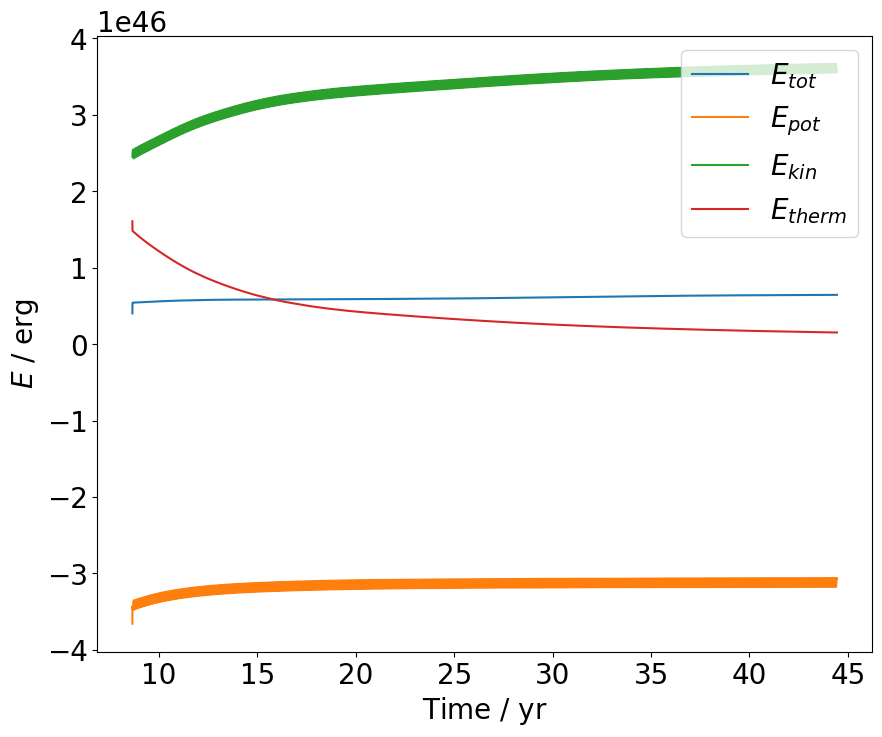

In [24]:
def plot_energy_conservation_ev(
    job_nickname = '2md',
    filename_ev = "accretion01.ev",
    output_dir = output_dir,
    verbose = verbose,
):
    job_profile = JOB_PROFILES_DICT[job_nickname]
    filepath_ev = f"{job_profile['raw_dir']}{filename_ev}"
    eos_opacity=get_eos_opacity(ieos=job_profile['ieos'], params=job_profile['params'])
    mpdf = mpdf_read(job_profile['job_name'], 0, eos_opacity, verbose=1)
    _, d = pa_read_ev(filepath_ev, units_in=mpdf.units)

    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.plot(d['t']['time'],d['E']['E_tot'], label='$E_{tot}$')
    ax.plot(d['t']['time'],d['E']['E_pot'], label='$E_{pot}$')
    ax.plot(d['t']['time'],d['E']['E_kin'], label='$E_{kin}$')
    ax.plot(d['t']['time'],d['E']['E_hea'], label='$E_{therm}$')
    # ax.plot(d['t']['time'],d['E']['E_rad'], label='$E_{rad}$')
    # ax.plot(d['t']['time'],d['E']['E_mag'], label='$E_{mag}$')
    
    ax.set_xlabel(f"Time / {d['t'].unit.to_string('latex_inline')}")
    ax.set_ylabel(f"$E$ / {d['E'].unit.to_string('latex_inline')}")
    ax.legend()
    
    outfilename = f"{output_dir}energies-ev.png"
    fig.savefig(outfilename)
    say('note', None, verbose, f"Saved to '{outfilename}'.")
    return fig, ax, d

if __name__ == '__main__':
    fig, ax, d = plot_energy_conservation_ev()

In [25]:
if False:
    plot_energy_conservation_ev(filename_ev='light10.ev')

TypeError: 'Quantity' object with a scalar value does not support indexing

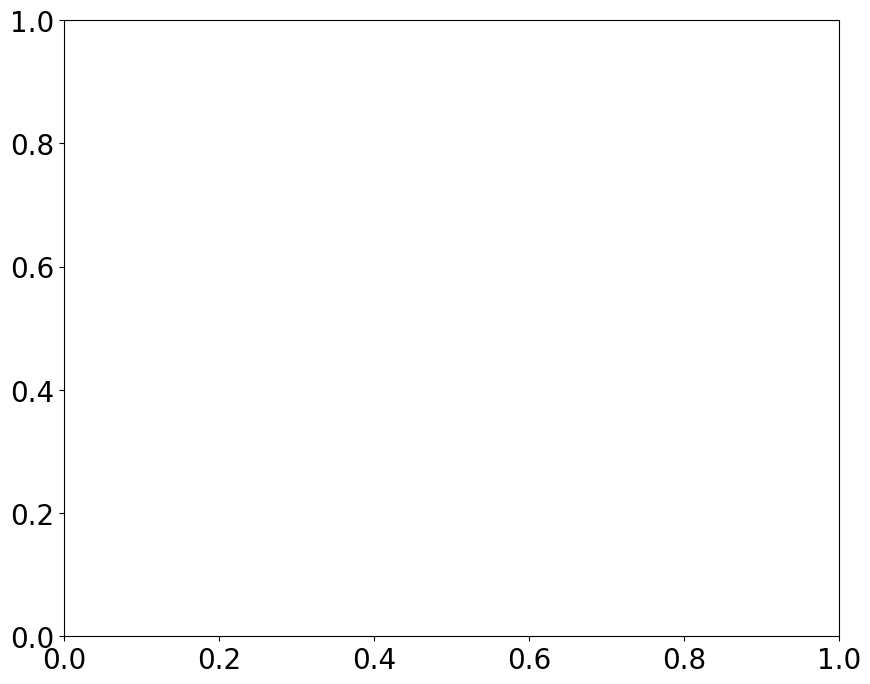

In [165]:
def plot_energy_conservation_pa(
    job_nickname = '2md',
    filepath_ev = "../raw/luis_2md/energy.ev",
    output_dir = output_dir,
    verbose = verbose,
):
    job_profile = JOB_PROFILES_DICT[job_nickname]
    eos_opacity=get_eos_opacity(ieos=job_profile['ieos'], params=job_profile['params'])
    mpdf = mpdf_read(job_profile['job_name'], 0, eos_opacity, verbose=1)
    _, d = pa_read_energy(filepath_ev, units_in=mpdf.units)

    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.plot(d['t']['time'][:],d['E']['E_tot'][:], label='$E_{tot}$')
    ax.plot(d['t']['time'][:],d['E']['E_pot'][:], label='$E_{pot}$')
    ax.plot(d['t']['time'][:],d['E']['E_kin'][:], label='$E_{kin}$')
    ax.plot(d['t']['time'][:],d['E']['E_hea'][:], label='$E_{therm}$')
    
    ax.set_xlabel(f"Time / {d['t'].unit.to_string('latex_inline')}")
    ax.set_ylabel(f"$E$ / {d['E'].unit.to_string('latex_inline')}")
    ax.legend()
    
    outfilename = f"{output_dir}energies-pa.png"
    fig.savefig(outfilename)
    say('note', None, verbose, f"Saved to '{outfilename}'.")
    return fig, ax, d

if __name__ == '__main__':
    fig, ax, d = plot_energy_conservation_pa()

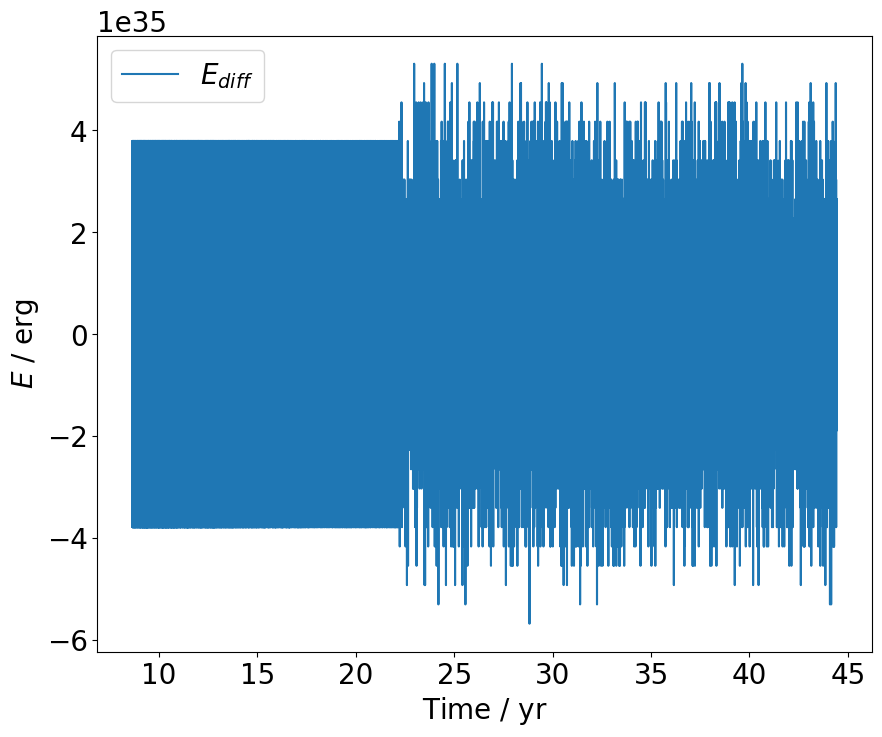

In [167]:
if True:
    E_diff = d['E']['E_pot'] + d['E']['E_kin'] + d['E']['E_hea'] - d['E']['E_tot']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # ax.plot(d['t']['time'],d['E']['E_tot'], label='$E_{tot}$')
    # ax.plot(d['t']['time'],d['E']['E_kin'], label='$E_{kin}$')
    # ax.plot(d['t']['time'],d['E']['E_kin_bound'], label='$E_{kin, bound}$')
    # ax.plot(d['t']['time'],d['E']['E_kin_unbound'], label='$E_{kin, unbound}$')
    ax.plot(d['t']['time'], E_diff , label='$E_{diff}$')
    
    ax.set_xlabel(f"Time / {d['t'].unit.to_string('latex_inline')}")
    ax.set_ylabel(f"$E$ / {d['E'].unit.to_string('latex_inline')}")
    ax.legend()
    

In [168]:
if True:
    # E_diff = d['E']['E_pot'] + d['E']['E_kin'] + d['E']['E_hea'] - d['E']['E_tot']
    E_diff2 = d['E']['E_kin_sink'] + d['E']['E_kin_bound'] + d['E']['E_kin_unbound'] - d['E']['E_kin']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.plot(d['t']['time'],d['E']['E_tot'], label='$E_{tot}$')
    ax.plot(d['t']['time'],d['E']['E_pot'], label='$E_{pot}$')
    ax.plot(d['t']['time'],d['E']['E_kin'], label='$E_{kin}$')
    ax.plot(d['t']['time'],d['E']['E_hea'], label='$E_{therm}$')
    # ax.plot(d['t']['time'], E_diff , label='$E_{diff}$')

    ax.set_xlim((0, 20))
    ax.set_ylim((-1e47, 1e47))
    ax.set_xlabel(f"Time / {d['t'].unit.to_string('latex_inline')}")
    ax.set_ylabel(f"$E$ / {d['E'].unit.to_string('latex_inline')}")
    ax.legend()

    if True:
        outfilename = f"{output_dir}energies_zoomin.png"
        fig.savefig(outfilename)
        say('note', None, verbose, f"Saved to '{outfilename}'.")

ValueError: no field of name E_kin_sink

In [169]:
if True:
    # E_diff = d['E']['E_pot'] + d['E']['E_kin'] + d['E']['E_hea'] - d['E']['E_tot']
    E_diff2 = d['E']['E_kin_sink'] + d['E']['E_kin_bound'] + d['E']['E_kin_unbound'] - d['E']['E_kin']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # ax.plot(d['t']['time'],d['E']['E_kin'], label='$E_{kin}$')
    ax.plot(d['t']['time'],d['E']['E_kin_sink'], label='$E_{kin, sink}$')
    # ax.plot(d['t']['time'],d['E']['E_kin_bound'], label='$E_{kin, bound}$')
    # ax.plot(d['t']['time'],d['E']['E_kin_unbound'], label='$E_{kin, unbound}$')
    # ax.plot(d['t']['time'], E_diff , label='$E_{diff}$')

    ax.set_xlabel(f"Time / {d['t'].unit.to_string('latex_inline')}")
    ax.set_ylabel(f"$E$ / {d['E'].unit.to_string('latex_inline')}")
    ax.legend()

    if True:
        outfilename = f"{output_dir}energies_kin.png"
        fig.savefig(outfilename)
        say('note', None, verbose, f"Saved to '{outfilename}'.")

ValueError: no field of name E_kin_sink

### Investigating the high L at late time

In [174]:
t = 44.44*units.yr

E_rec_pot, E_sep_pot, E_hea_pot = get_Es(job_nickname)

# luminosity potential from recombination energy
L_el_rec = (E_rec_pot / t).to(units.Lsun)
print(f"{L_el_rec = }")
# luminosity potential from gravity and kinetic energy
L_el_sep = (E_sep_pot / t).to(units.Lsun)
# luminosity potential from thermal energy energy
L_el_hea = (E_hea_pot / t).to(units.Lsun)
print(f"{L_el_sep = }")
print(f"{L_el_hea = }")
L_max = L_core + L_el_rec + L_el_sep + L_el_hea
print(f"{L_max = }")

L_el_rec = <Quantity 3798.86552177 solLum>
L_el_sep = <Quantity 2239.6327955 solLum>
L_el_hea = <Quantity 1411.99137815 solLum>
L_max = <Quantity 12630.48969542 solLum>


### Tscaled data dumps with Normal data dumps (summary)

Tscaled refers to scaling temperatures of the particles initially outside the photopshere at t=0 so the initial L matches MESA value.

In [18]:
filename = f"{job_name}_Tscale.npy"
scales = np.load(filename)
np.count_nonzero(scales['T_scale']>0)

33836

In [19]:
filename = f"{job_name}_Tcut.npy"
scales = np.load(filename)
np.count_nonzero(scales['T_scale']>0)

23730

In [50]:
# read Tscale data

scale_types = ['Tdelete', 'Tscale', 'Tcut']
comb_s = {}
interm_dir_new = interm_dir
interm_dir = '../interm/'

for nickname in ['2md', '4md']:
    if nickname not in comb_s:
        comb_s[nickname] = {}
    for scale_type in scale_types:
        filepath = f"{interm_dir}{scale_type}_lcgen.{no_xy_txt}.{nickname}.hdf5.gz"
        print(f"Reading from '{filepath}'...", end=' ')
        #combs[no_xy_txt] = mupl.hdf5_load(filepath)
        if filepath.endswith('.json'):
            with open(filepath, 'r') as f:
                comb_s[nickname][scale_type] = mupl.json_load(f)
        elif filepath.endswith(('.hdf5', '.hdf5.gz')):
            comb_s[scale_type] = mupl.hdf5_load(filepath)
        print("Done.")

interm_dir = interm_dir_new

Reading from '../interm/Tdelete_lcgen.256x256.2md.hdf5.gz'... *   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/Tdelete_lcgen.256x256.2md.hdf5.gz  (compress='gzip')
Done.
Reading from '../interm/Tscale_lcgen.256x256.2md.hdf5.gz'... *   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/Tscale_lcgen.256x256.2md.hdf5.gz  (compress='gzip')
Done.
Reading from '../interm/Tcut_lcgen.256x256.2md.hdf5.gz'... *   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/Tcut_lcgen.256x256.2md.hdf5.gz  (compress='gzip')
Done.
Reading from '../interm/Tdelete_lcgen.256x256.2md.hdf5.gz'... *   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/Tdelete_lcgen.256x256.2md.hdf5.gz  (compress='gzip')
Done.
Reading from '../interm/Tscale_lcgen.256x256.2md.hdf5.gz'... *   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/Tscale_lcgen.256x256.2md.hdf5.gz  (compress='gzi

KeyboardInterrupt: 

*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Adding y error bars..
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to '../fig/20240222_LCGen/256x256/LC_2md_256x256.Tscaled.xyz.pdf'.
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to '../fig/20240222_LCGen/256x256/LC_2md_256x256.Tscaled.xyz.png'.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Adding y error bars..
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to '../fig/20240222_LCGen/256x256/LC_2md_256x256.Tscaled.yzx.pdf'.
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to '../fig/20240222_LCGen/256x256/LC_2md_256x256.Tscaled.yzx.png'.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Adding y error bars..
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to '../fig/20240222_LCGen/256x256/LC_2md_256x256.Tscaled.xzy.pdf'.
*   Note   :    run_ast_nodes() ==> run_code() ==

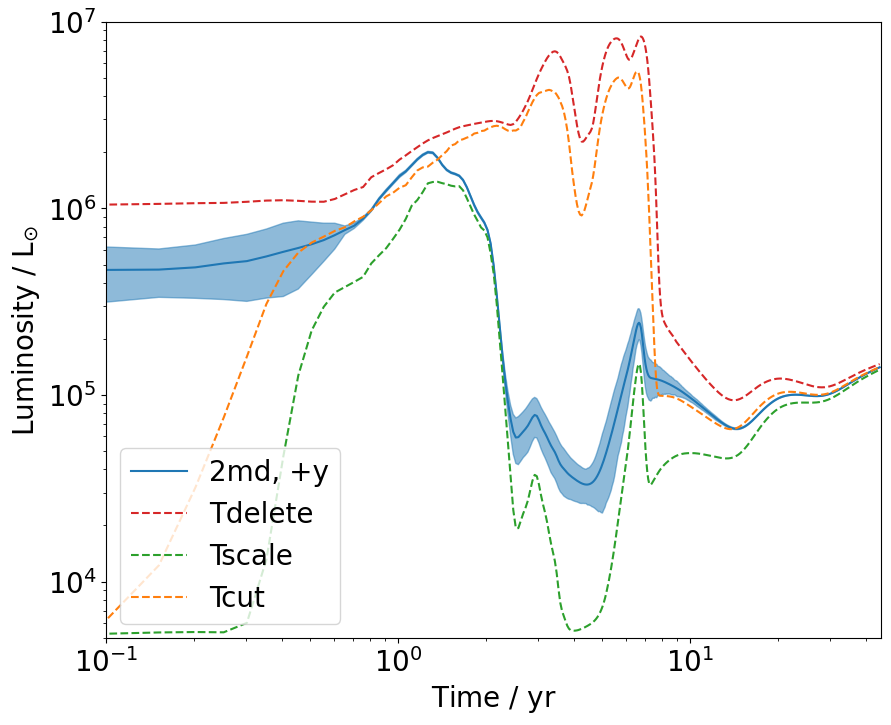

In [37]:
# plot LC


comb = combs['256x256']
job_nickname = '2md'
xyzs_list = ['xyz', 'yzx', 'xzy']

# plt.plot(data['times'], data['lums'])

mode = 'LC'


for ixyz, xyz in enumerate(xyzs_list):
    
    try:
        fig.clear()
        plt.close(fig)
    except NameError:
        pass
    
    fig, ax, outfilenames = plot_comb(
        comb, mode, output_dir,
        job_nicknames=[job_nickname],
        xyzs_list=[xyz],
        plot_title_dict=plot_title_dict,
        out_exts=[],
        no_xy_txt=no_xy_txt,
        xlim = do_plots[mode]['xlim'],  # (0, 5), # 
        ylim = do_plots[mode]['ylim'],
        whatlog = do_plots[mode]['whatlog'],)
    
    
    for i_s, scale_type in enumerate(scale_types):
        data_s = comb_s[scale_type][job_nickname][xyz]
        ax.plot(data_s['times'],  data_s['lums'],  '--', label=scale_type, color=f'C{3-i_s}')
    ax.legend()

    outfilename_noext = f"{output_dir}{mode}_{job_nickname}_{no_xy_txt}.Tscaled.{xyz}"
    for ext in {'.png', '.pdf'}:
        outfilename = f"{outfilename_noext}{ext}"
        fig.savefig(outfilename)
        say('note', None, verbose, f"Fig saved to '{outfilename}'.")

*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to '../fig/20240222_LCGen/LC_comb_256x256.pdf'.
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to '../fig/20240222_LCGen/LC_comb_256x256.png'.


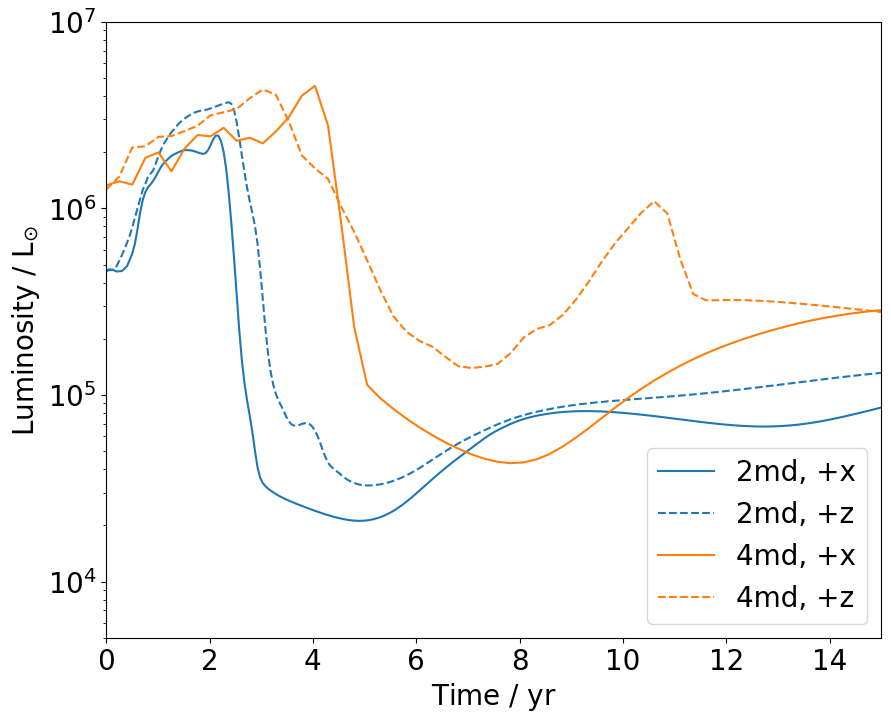

In [48]:
# Orsola asked for below plot 2025-07-24

# plot LC


no_xy_txt = '256x256'
comb = copy.deepcopy(combs[no_xy_txt])
del comb['2md']['yzx']['lums_err']
mode = 'LC'


if __name__ == '__main__':
    
    try:
        fig.clear()
        plt.close(fig)
    except NameError:
        pass
    
    fig, ax, outfilenames = plot_comb(
        comb, 'LC', output_dir,
        job_nicknames=['2md'],
        xyzs_list=['yzx'],
        plot_title_dict=plot_title_dict,
        out_exts=[],
        no_xy_txt=no_xy_txt,
        xlim = (0, 15),  # (0, 5), # 
        ylim = do_plots['LC']['ylim'],
        whatlog = 'semilogy',)
    
    ax.semilogy(comb['2md']['xyz']['times'], comb['2md']['xyz']['lums'], '--', label='2md, +z')
    ax.semilogy(comb['4md']['yzx']['times'], comb['4md']['yzx']['lums'],       color='C1', label='4md, +x')
    ax.semilogy(comb['4md']['xyz']['times'], comb['4md']['xyz']['lums'], '--', color='C1', label='4md, +z')
    ax.legend()
    
    outfilename_noext = f"{output_dir}{mode}_comb_{no_xy_txt}"
    for ext in {'.png', '.pdf'}:
        outfilename = f"{outfilename_noext}{ext}"
        fig.savefig(outfilename)
        say('note', None, verbose, f"Fig saved to '{outfilename}'.")

*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to '../fig/20240222_LCGen/LC_comb_256x256.Tscale.pdf'.
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to '../fig/20240222_LCGen/LC_comb_256x256.Tscale.png'.


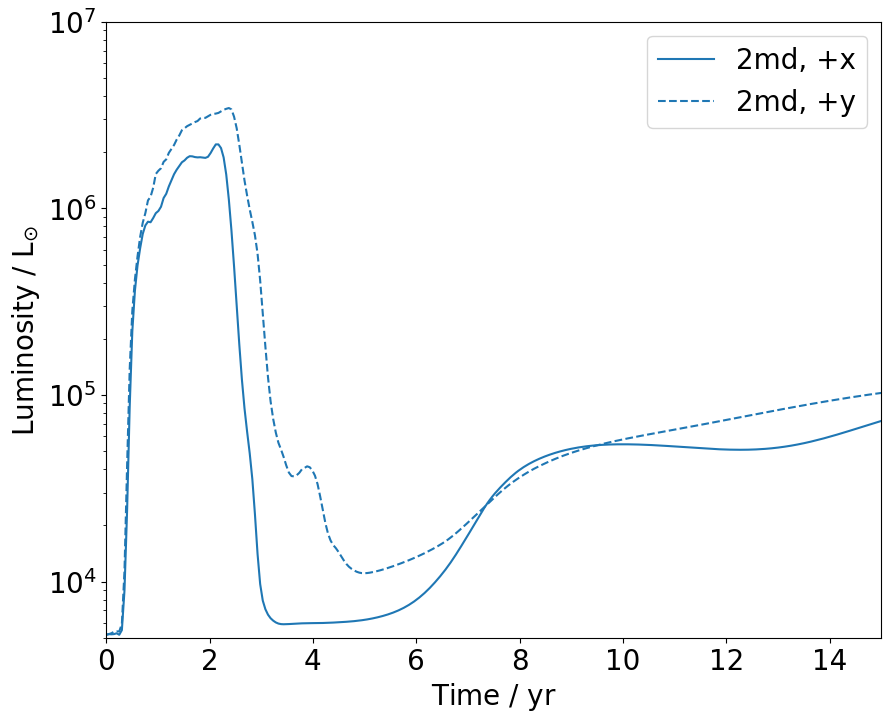

In [49]:
# Orsola asked for below plot 2025-07-24

# plot LC


no_xy_txt = '256x256'
scale_type = 'Tscale'
comb = copy.deepcopy(comb_s[scale_type])
del comb['2md']['yzx']['lums_err']
mode = 'LC'


if __name__ == '__main__':
    
    try:
        fig.clear()
        plt.close(fig)
    except NameError:
        pass
    
    fig, ax, outfilenames = plot_comb(
        comb, 'LC', output_dir,
        job_nicknames=['2md'],
        xyzs_list=['yzx'],
        plot_title_dict=plot_title_dict,
        out_exts=[],
        no_xy_txt=no_xy_txt,
        xlim = (0, 15),  # (0, 5), # 
        ylim = do_plots['LC']['ylim'],
        whatlog = 'semilogy',)
    
    ax.semilogy(comb['2md']['xyz']['times'], comb['2md']['xyz']['lums'], '--', label='2md, +y')
    # ax.semilogy(comb['4md']['yzx']['times'], comb['4md']['yzx']['lums'],       color='C1', label='4md, +x')
    # ax.semilogy(comb['4md']['xyz']['times'], comb['4md']['xyz']['lums'], '--', color='C1', label='4md, +y')
    ax.legend()
    
    outfilename_noext = f"{output_dir}{mode}_comb_{no_xy_txt}.{scale_type}"
    for ext in {'.png', '.pdf'}:
        outfilename = f"{outfilename_noext}{ext}"
        fig.savefig(outfilename)
        say('note', None, verbose, f"Fig saved to '{outfilename}'.")

#### integrating to find the total energy output

    Es_lum = integrate.cumulative_simpson(y=comb[job_nickname][xyz]['lums'].value, x=comb[job_nickname][xyz]['times'].value)
    Es_lum = (Es_lum * comb[job_nickname][xyz]['lums'].unit * comb[job_nickname][xyz]['times'].unit).cgs
    ts = comb[job_nickname][xyz]['times'][:-1] + np.diff(comb[job_nickname][xyz]['times'])

In [30]:
E_rec_pot, E_sep_pot, E_hea_pot = get_Es(job_nickname)
L_core = 5180*units.Lsun
E_rec_pot, E_sep_pot, E_hea_pot

(<Quantity 2.03940682e+46 erg>,
 <Quantity 1.20233853e+46 erg>,
 <Quantity 7.58022316e+45 erg>)

*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to '../fig/20240222_LCGen/Elum_2md_256x256.png'.
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to '../fig/20240222_LCGen/Elum_2md_256x256.pdf'.


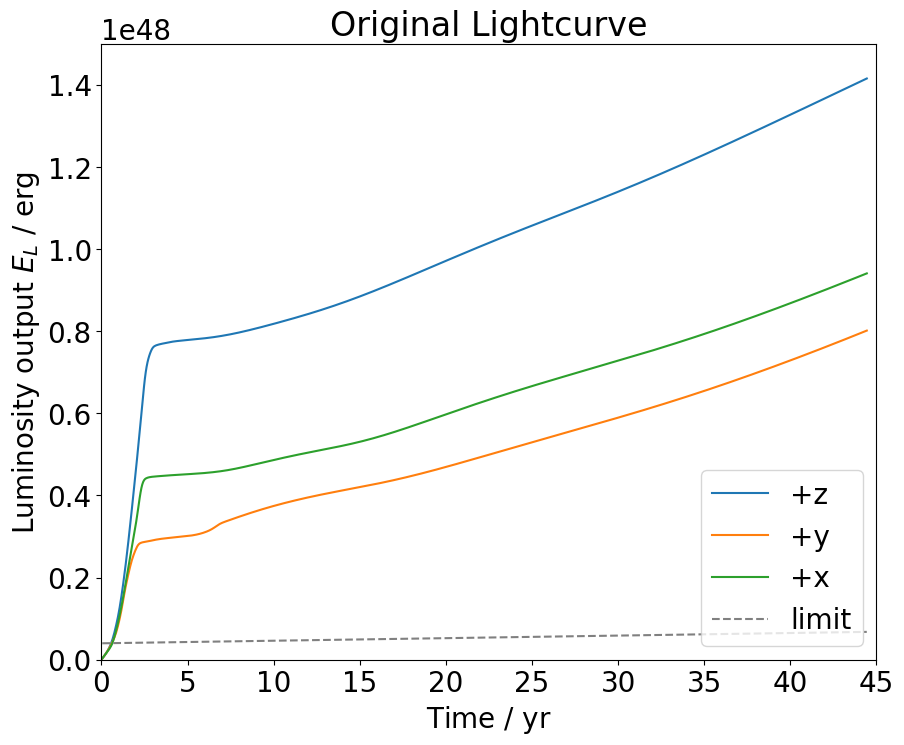

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))

for xyz in ['xyz', 'xzy', 'yzx']:
    Es_lum = integrate.cumulative_simpson(y=comb[job_nickname][xyz]['lums'].value, x=comb[job_nickname][xyz]['times'].value)
    Es_lum = (Es_lum * comb[job_nickname][xyz]['lums'].unit * comb[job_nickname][xyz]['times'].unit).cgs
    ts = comb[job_nickname][xyz]['times'][:-1] + np.diff(comb[job_nickname][xyz]['times'])
    ax.plot(ts, Es_lum, label=f"+{xyz[2]}")

# add line of total energy expectation
Es_lum_exp = (L_core*ts + E_rec_pot + E_sep_pot + E_hea_pot).cgs
ax.plot(ts, Es_lum_exp, '--', label='limit', color='grey')

ax.set_xlabel(f"Time / {ts.unit.to_string('latex_inline')}")
ax.set_ylabel(f"Luminosity output $E_L$ / {Es_lum.unit.to_string('latex_inline')}")
ax.set_title("Original Lightcurve")

ax.legend(loc='lower right')

ax.set_xlim(0, 45)
ax.set_ylim(0, 1.5e48)

outfilename_noext = f"{output_dir}Elum_{job_nickname}_{no_xy_txt}"
for ext in {'.png', '.pdf'}:
    outfilename = f"{outfilename_noext}{ext}"
    fig.savefig(outfilename)
    say('note', None, verbose, f"Fig saved to '{outfilename}'.")

*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to '../fig/20240222_LCGen/Elum_2md_256x256.Tdelete.png'.
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to '../fig/20240222_LCGen/Elum_2md_256x256.Tdelete.pdf'.


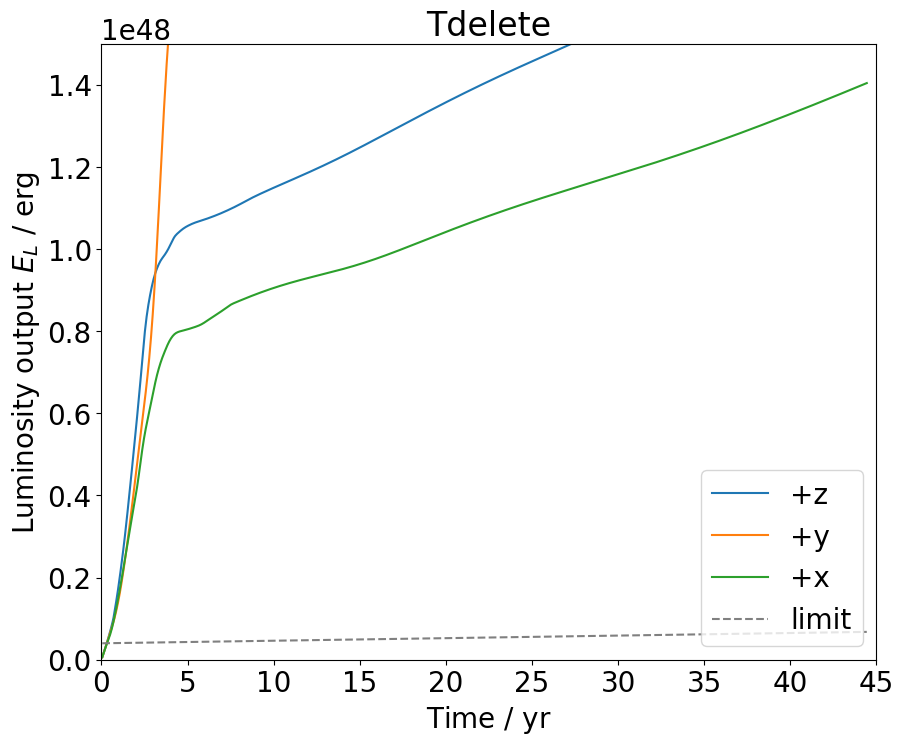

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))

scale_type = 'Tdelete'

for xyz in ['xyz', 'xzy', 'yzx']:
    data = comb_s[scale_type][job_nickname][xyz]
    Es_lum = integrate.cumulative_simpson(y=data['lums'].value, x=data['times'].value)
    Es_lum = (Es_lum * data['lums'].unit * data['times'].unit).cgs
    ts = data['times'][:-1] + np.diff(data['times'])
    ax.plot(ts, Es_lum, label=f"+{xyz[2]}")

# add line of total energy expectation
Es_lum_exp = (L_core*ts + E_rec_pot + E_sep_pot + E_hea_pot).cgs
ax.plot(ts, Es_lum_exp, '--', label='limit', color='grey')

ax.set_xlabel(f"Time / {ts.unit.to_string('latex_inline')}")
ax.set_ylabel(f"Luminosity output $E_L$ / {Es_lum.unit.to_string('latex_inline')}")
ax.set_title(scale_type)

ax.set_xlim(0, 45)
ax.set_ylim(0, 1.5e48)

ax.legend(loc='lower right')

outfilename_noext = f"{output_dir}Elum_{job_nickname}_{no_xy_txt}.{scale_type}"
for ext in {'.png', '.pdf'}:
    outfilename = f"{outfilename_noext}{ext}"
    fig.savefig(outfilename)
    say('note', None, verbose, f"Fig saved to '{outfilename}'.")

In [133]:
E_max = (L_core*t + E_rec_pot + E_sep_pot + E_hea_pot).cgs
print(f"{E_max = }")    # result: 12617.08129305 solLum

E_max = <Quantity 6.78063138e+46 erg>


*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to ../fig/20240222_LCGen/LC_2md_256x256.Tscaled-diff.png.


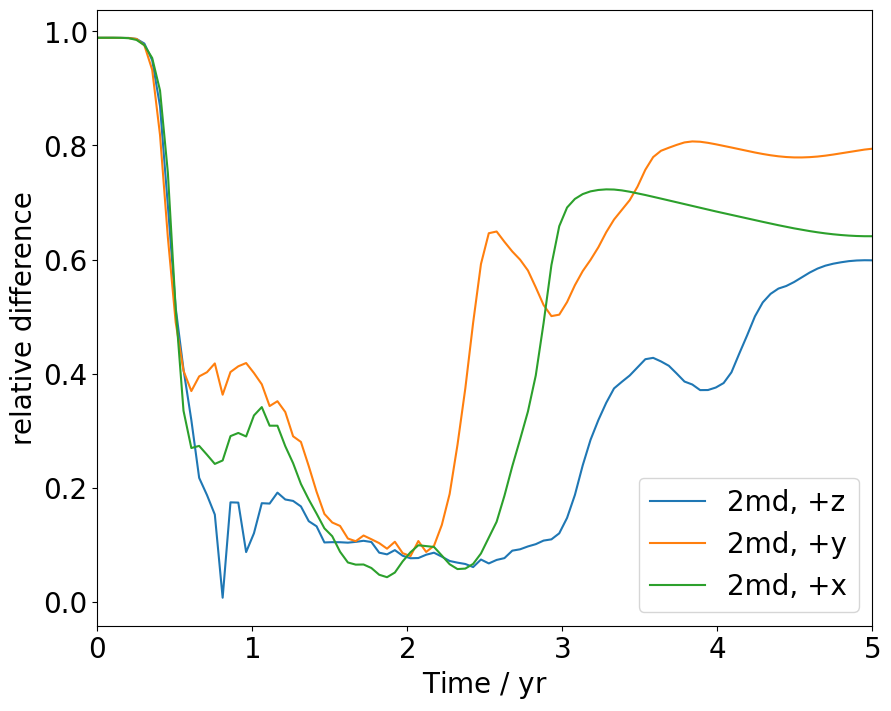

In [23]:
# plot diff


comb = combs['256x256']
job_nickname = '2md'
xyzs_list = ['xyz', 'xzy', 'yzx']

# plt.plot(data['times'], data['lums'])

mode = 'LC'

try:
    fig.clear()
    plt.close(fig)
except NameError:
    pass

fig, ax = plt.subplots(figsize=(10, 8))

for i_xyz, xyz in enumerate(xyzs_list):
    data_Tscaled = comb_Tscaled[job_nickname][xyz]
    data_normal  = comb[job_nickname][xyz]

    color = f'C{i_xyz}'
    
    x = data_normal['times']
    assert np.all(x == data_Tscaled['times'])
    y = (data_normal['lums'] - data_Tscaled['lums']) / (data_normal['lums'])
    ax.plot(x, y, '-', label=f"{job_nickname}, +{xyz[2]}", color=color)
            
ax.legend()
ax.set_xlabel(f"Time / {x.unit.to_string('latex_inline')}")
# set y label (remove slash if unit is dimensionless)
ylabel = f"relative difference"
ax.set_ylabel(f"{ylabel}")
ax.set_xlim((0, 5))
# ax.set_ylim((1e-2, 1e0))

if True:
    outfilename = f"{output_dir}LC_{job_nickname}_{no_xy_txt}.Tscaled-diff"
    if len(xyzs_list)==1: outfilename += f'.{xyzs_list[0]}'
    outfilename += '.png' 
    fig.savefig(outfilename)
    say('note', None, verbose, f"Fig saved to {outfilename}.")

### Plotting existing intermediate files (summary)

*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Adding y error bars..
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Adding y error bars..
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Adding y error bars..
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/LC_4mddo-olim_256x256.pdf.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/LC_4mddo-olim_256x256.png.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/Nres_4mddo-olim_256x256.pdf.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/Nres_4mddo-olim_256x256.png.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/Rph_4mddo-olim_256x256.pdf.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/Rph_4mddo-olim_256x256.png.
*   Note   :    

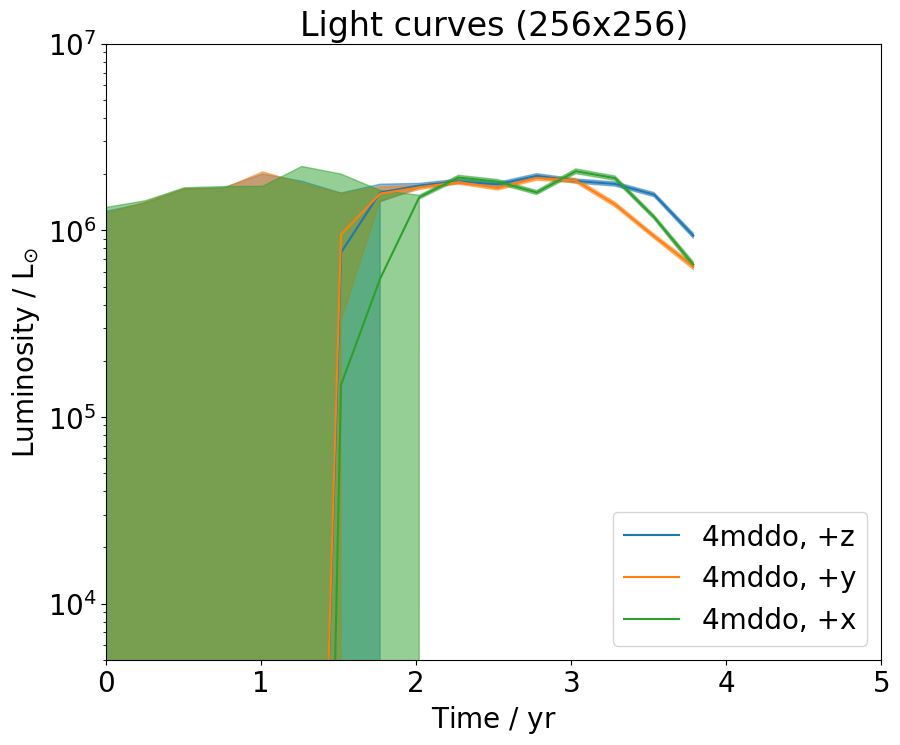

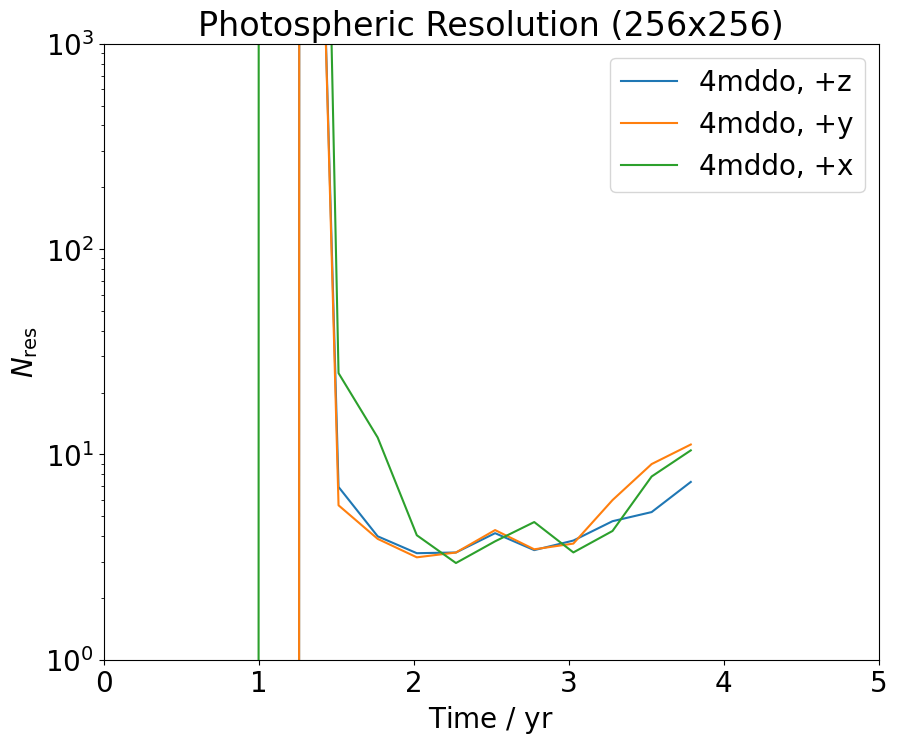

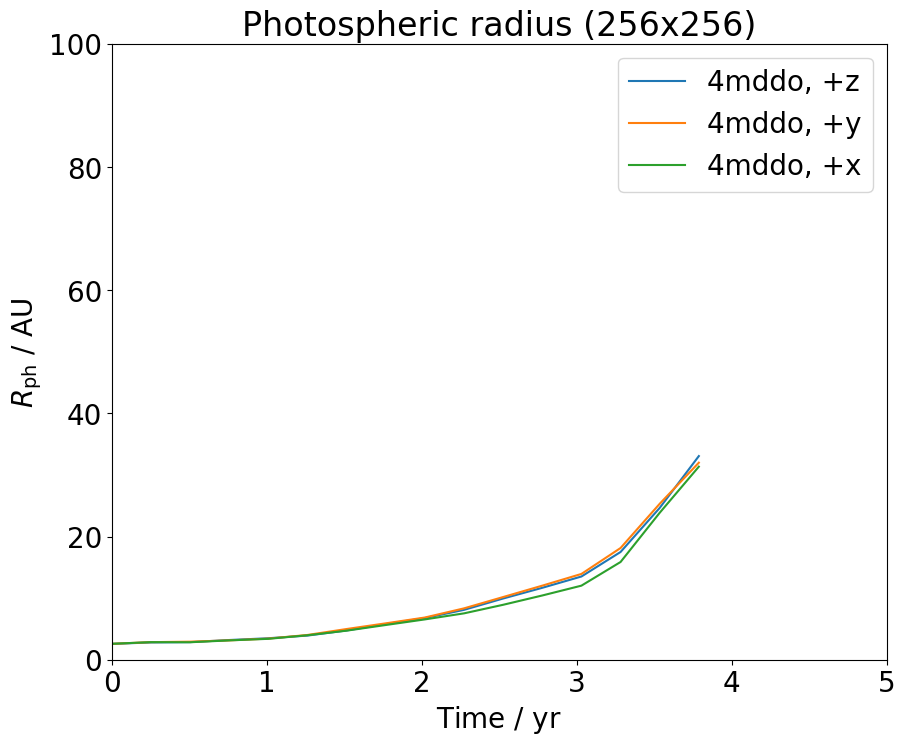

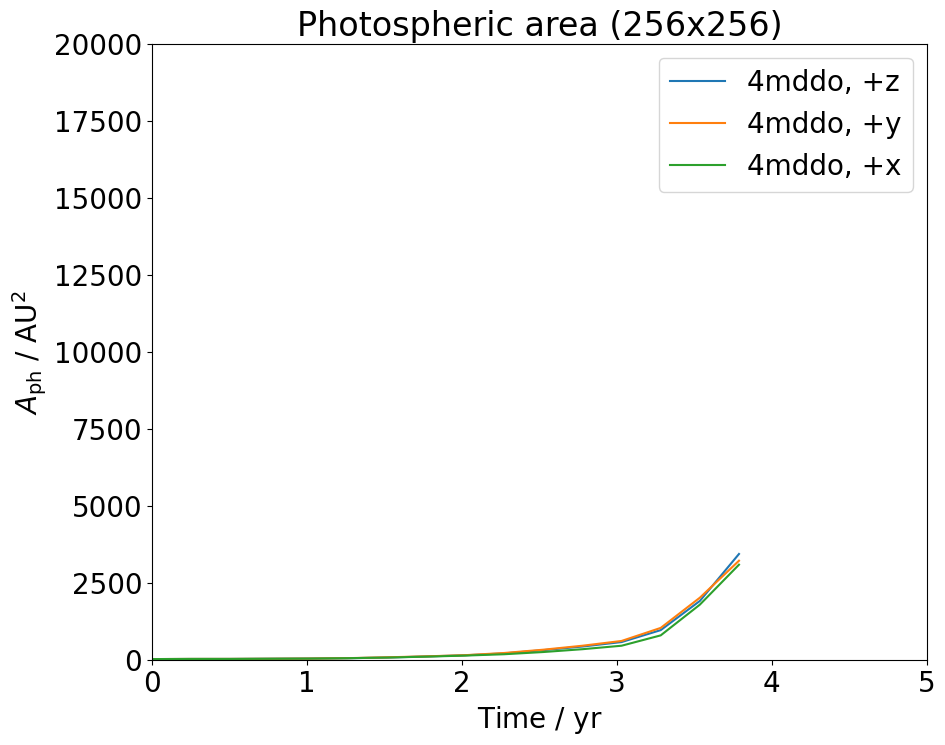

In [89]:
# plot

if __name__ == '__main__':

    job_nicknames = ['4mddo'] #['2md_olim']
    out_savename = get_out_savename(job_nicknames)
    
    figs = []
    for no_xy_txt in combs.keys():
        comb = combs[no_xy_txt]

        for fig in figs:
            fig.clear()
            plt.close(fig)
        figs = []
        for mode in do_plots.keys():
            if do_plots[mode]['do_this']:
                fig, ax, outfilenames = plot_comb(
                    comb, mode, output_dir,
                    job_nicknames=job_nicknames,
                    xyzs_list=xyzs_list,
                    plot_title_dict=plot_title_dict,
                    out_savename=out_savename+'-olim',
                    no_xy_txt=no_xy_txt,
                    xlim = do_plots[mode]['xlim'],
                    ylim = do_plots[mode]['ylim'],
                    whatlog = do_plots[mode]['whatlog'],
                )
                figs.append(fig)

*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Adding y error bars..
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/LC_None_256x256.pdf.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/LC_None_256x256.png.


NotImplementedError: Temp Alteration

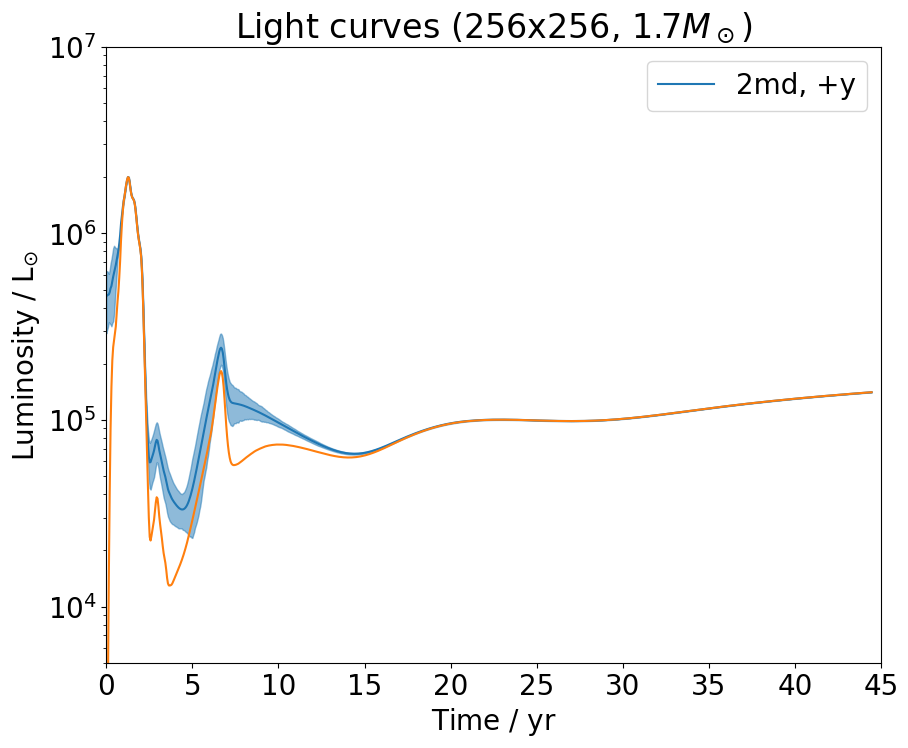

In [39]:
# plot

if False:
    figs = []
    for no_xy_txt in combs.keys():
        comb = combs[no_xy_txt]

        for fig in figs:
            fig.clear()
            plt.close(fig)
        figs = []
        for mode in ['LC']:
            if do_plots[mode]['do_this']:
                fig, ax, outfilenames = plot_comb(
                    comb, mode, output_dir,
                    job_nicknames=['2md'],#job_nicknames,
                    xyzs_list=['xzy'],
                    plot_title_dict=plot_title_dict,
                    out_savename=None,
                    no_xy_txt=no_xy_txt,
                    xlim = do_plots[mode]['xlim'],
                    ylim = do_plots[mode]['ylim'],
                    whatlog = do_plots[mode]['whatlog'],
                )
                figs.append(fig)

    ax.semilogy(comb['2md_olim']['xzy']['times'], comb['2md_olim']['xzy']['lums'], color='C1')
    
    raise NotImplementedError("Temp Alteration")

In [28]:
# fitting photosphere expansion velocity
if __name__ == '__main__':
    for job_nickname, data0 in combs[no_xy_txt].items():
        if job_nickname == '_meta_': continue
        for xyzs, data in data0.items():
            Rph   = (data['areas']/pi)**0.5
            times =  data['times']
            nstop = np.where(times > 10 * units.yr)[0][0]
            ans = linregress(times[nstop:], Rph[nstop:])
            print(
                job_nickname, xyzs, nstop,
                np.polyfit(np.log10(times.value)[nstop:], np.log10(Rph.value)[nstop:], 1),
                f"r-value={ans.rvalue:.5f}",
                f"v_r={(ans.slope * Rph.unit/times.unit).to(units.km/units.s):.2f}",
                f"+/- {(ans.stderr * Rph.unit/times.unit).to(units.km/units.s):.2f}",
            )

2m_2022 xyz 40 [0.54096687 1.0133968 ] r-value=0.91912 v_r=8.41 km / s +/- 0.83 km / s
2m_2022 xzy 40 [0.67259334 0.86962545] r-value=0.96135 v_r=10.35 km / s +/- 0.68 km / s
2m_2022 yzx 40 [0.67662655 0.86490765] r-value=0.96249 v_r=10.40 km / s +/- 0.67 km / s
2md xyz 0 [0.91167102 1.23856702] r-value=0.99993 v_r=54.15 km / s +/- 0.07 km / s
2md xzy 0 [0.99317929 1.10241118] r-value=0.99998 v_r=58.09 km / s +/- 0.04 km / s
2md yzx 0 [0.99464273 1.09554973] r-value=0.99999 v_r=57.59 km / s +/- 0.02 km / s
4m xyz 40 [ 1.95467902 -0.41503653] r-value=0.99765 v_r=35.77 km / s +/- 0.82 km / s
4m xzy 40 [ 2.07080637 -0.54827671] r-value=0.99862 v_r=37.00 km / s +/- 0.65 km / s
4m yzx 40 [ 2.09051494 -0.56653184] r-value=0.99750 v_r=37.50 km / s +/- 0.89 km / s
2md_olim xyz 199 [0.95814924 1.16283827] r-value=0.99993 v_r=57.70 km / s +/- 0.04 km / s
2md_olim xzy 199 [1.02241661 1.05312662] r-value=0.99972 v_r=59.46 km / s +/- 0.08 km / s
2md_olim yzx 199 [0.9929577  1.09250965] r-value=0.99

*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Adding y error bars..
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to ../fig/20240222_LCGen/LC_res-conv_2md_xyz.png.
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to ../fig/20240222_LCGen/LC_res-conv_2md_xyz.pdf.
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Adding y error bars..
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to ../fig/20240222_LCGen/LC_res-conv_2md_yzx.png.
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to ../fig/20240222_LCGen/LC_res-conv_2md_yzx.pdf.
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Adding y error bars..
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to ../fig/20240222_LCGen/LC_res-conv_2md_xzy.png.
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to ../fig/20240222_LCGen/LC_res-conv_2md_xzy.pdf

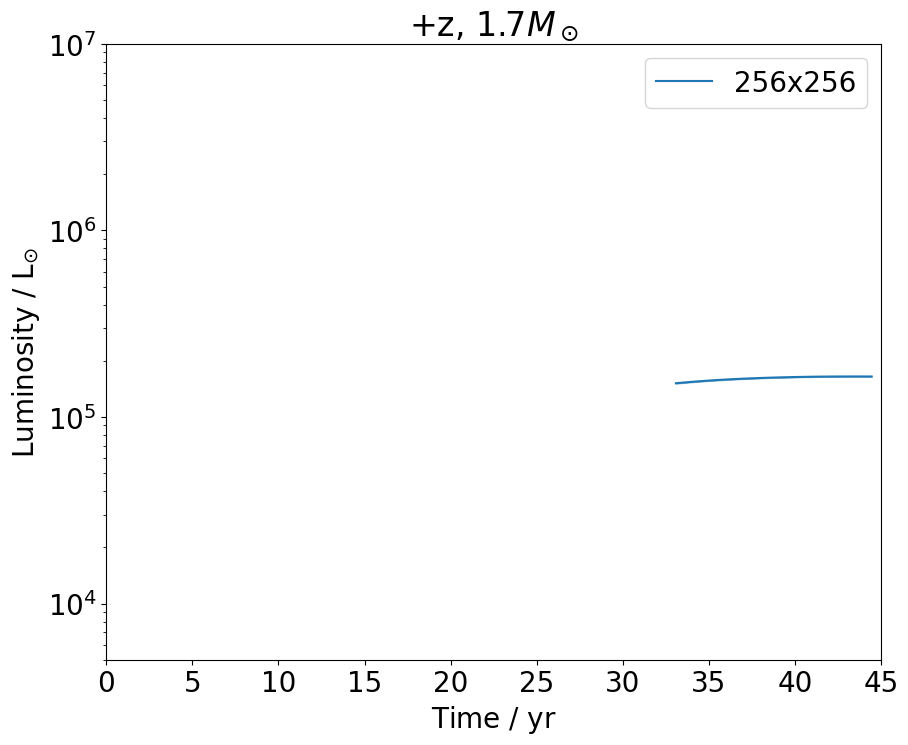

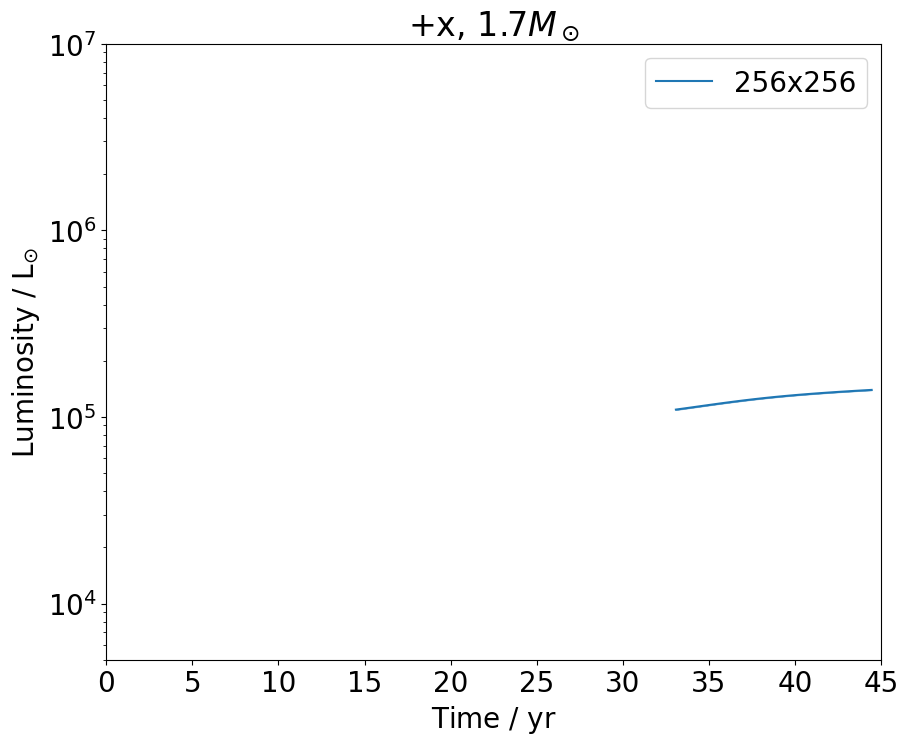

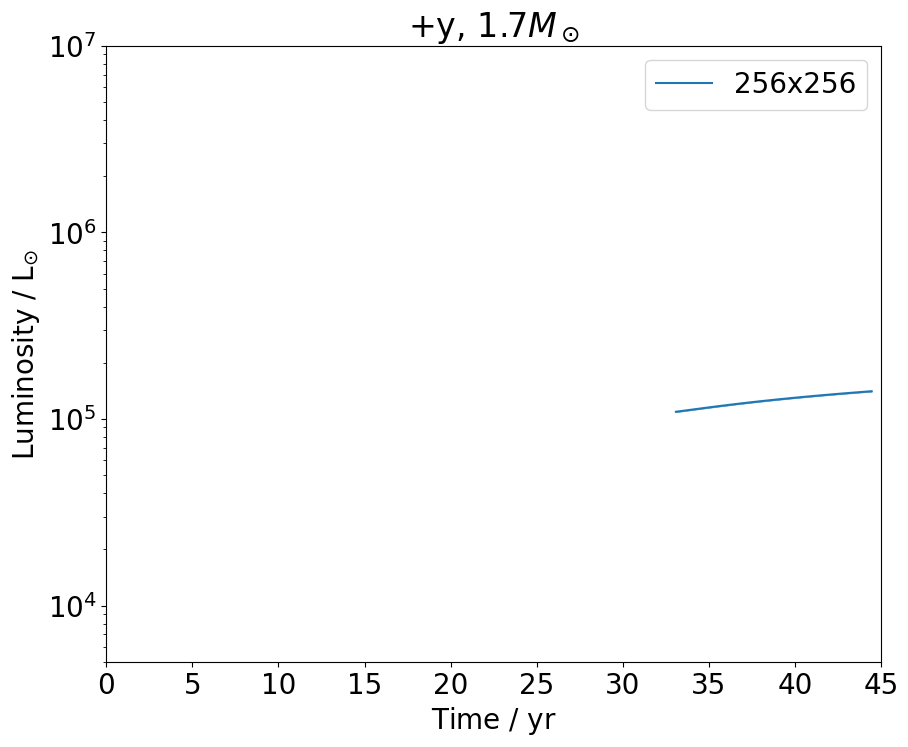

In [29]:
# plot resolution study for LC

if __name__ == '__main__':

    job_nickname = '2md'
    out_exts = ['.png', '.pdf']
    
    for xyzs in ['xyz', 'yzx', 'xzy']: #['xyz', 'xzy']: #

        mode = 'LC'
        outfilename_noext = f"{output_dir}LC_res-conv_{job_nickname}_{xyzs}"
        xlim = do_plots[mode]['xlim']
        ylim = do_plots[mode]['ylim']
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        for i_res, no_xy_txt in enumerate(combs_all.keys()):
            comb = combs_all[no_xy_txt]
            color = f'C{i_res}'
            
            x = comb[job_nickname][xyzs]['times']
            y_err = None
            y = comb[job_nickname][xyzs]['lums']
            if 'lums_err' in comb[job_nickname][xyzs].keys():
                say('note', None, verbose, "Adding y error bars..")
                y_err = (comb[job_nickname][xyzs]['lums_err']).to(y.unit)
            
            ax.semilogy(x, y, '-', label=f"{no_xy_txt}", color=color)
            if y_err is not None:
                ax.fill_between(x.value, (y - y_err).value, (y + y_err).value, color=color, alpha=0.5)
            
        ax.legend()
        ax.set_xlabel(f"Time / {x.unit.to_string('latex_inline')}")
        # set y label (remove slash if unit is dimensionless)
        ylabel = f"Luminosity / {y.unit.to_string('latex_inline')}"
        ax.set_ylabel(f"{ylabel}")
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        for out_ext in out_exts:
            title_txt  = '' if out_ext in {'.pdf'} else 'LC resolution convergence study '
            title_txt += f"+{xyzs[-1]}, {plot_title_dict[job_nickname]}"
            ax.set_title(title_txt)
            outfilename = f"{outfilename_noext}{out_ext}"
            fig.savefig(outfilename)
            if is_verbose(verbose, 'note'):
                say('note', None, verbose, f"Fig saved to {outfilename}.")

### Plotting existing intermediate files (individual dumps)

In [13]:
norm_image = mpl.colors.LogNorm(1e-12, 1e-2, clip=False)

job_nicknames

['2md']

*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00000.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00020.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00040.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00060.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00080.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00100.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00120.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_001

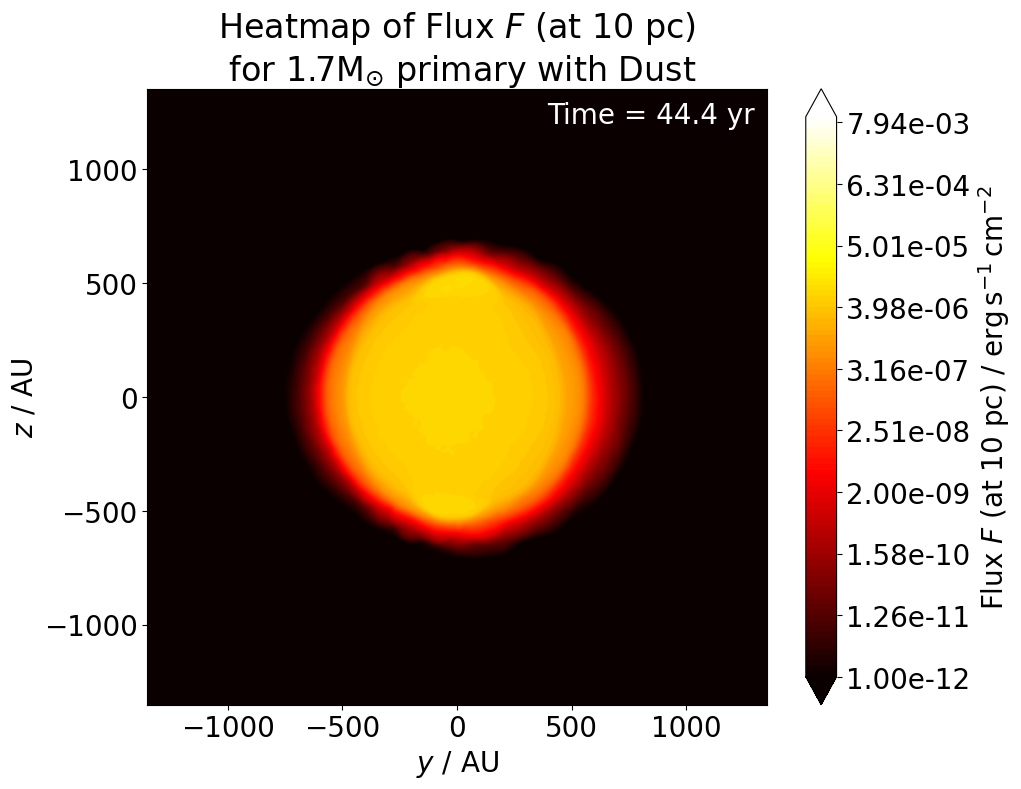

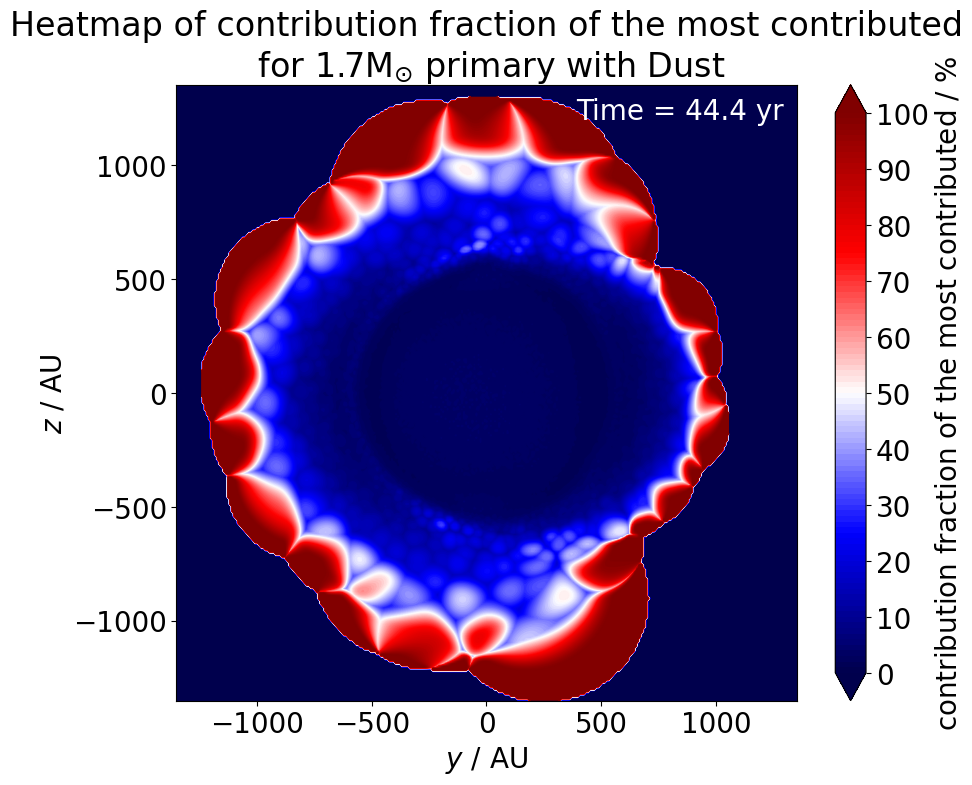

In [20]:
rays_res = 256
no_xy = (rays_res, rays_res)
no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
output_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'

hollywood_mode: bool = False # True


if __name__ == '__main__':

    

    outfilenames_dict = {
        'rads' : {},
        'contr': {},
    }

    figs = []
    for job_nickname in job_nicknames:
        data = {}
        plt.close('all')

        job_profile = JOB_PROFILES_DICT[job_nickname]
        job_name    = job_profile['job_name']
        file_indexes= job_profile['file_indexes']

        for file_index in file_indexes: #[0, 1200, 4800, 8000, 17600]: #
            plt.close('all')
            data_full = mupl.hdf5_load(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{no_xy_txt}.hdf5")
            xyzs_list = list(data_full.keys()).copy() if xyzs_list is None else xyzs_list
            
            # initialize
            for d in outfilenames_dict.keys():
                if job_nickname not in outfilenames_dict[d].keys():
                    outfilenames_dict[d][job_nickname] = {xyzs: [] for xyzs in xyzs_list}

            for xyzs in xyzs_list:
                data = data_full[xyzs]
                # calc flux
                # rads = data['rads'].to(unit_I)
                flux = (data['rads']*data['area_per_ray']*units.rad**2 / spec_dist**2).to(unitsOut['flux'])
                
                # reconstructing rays
                rays_u = np.zeros((data['rays'].shape[0], 2, 3)) * units.au
                rays_u[:, 0, :2] = data['rays']
                rays_u[:, 1, :2] = data['rays']
                rays_u[:, 1] += data['ray_unit_vec'] * units.au

                I_avg = (data['lum']/(4*pi*spec_dist**2)*np.mean(data['area_per_ray']/data['area_one'])).to(unitsOut['flux'])
                I_range = np.min((20., (flux.max()/I_avg).cgs.value,)) * I_avg.value # flux.max().to(unit_I).value #
                

                # plotting

                for fig in figs:
                    fig.clear()
                    plt.close(fig)
                    del fig
                del figs
                figs = []
                
                i_tr = 3560 if job_nickname not in {'2m_2022', '4m', '4md'} else 3500
                xylim_u = 100*units.au if file_index < i_tr else 250*units.au

                # cmap = plt.get_cmap('hot') #; cmap.set_over('white')
                fig, _, outfilenames = plot_heat(
                    no_xy, rays_u, flux,
                    data_label=f"Flux $F$ (at {spec_dist.value:.0f} {spec_dist.unit.to_string('latex_inline')})",
                    xyzs=xyzs, save_label=f"image",
                    job_profile=job_profile, file_index=file_index, cmap='hot', notes=data,
                    norm=norm_image,
                    cbar_num_fmt=lambda x, pos: f"{x:.2e}",
                    text_color='white',
                    xylim=xylim_u.to_value(rays_u.unit) if hollywood_mode else None,
                    output_dir=output_dir, out_exts=['png'], verbose=verbose_loop)
                outfilenames_dict['rads' ][job_nickname][xyzs].append(outfilenames[-1])
                figs.append(fig)

                
                fig, _, outfilenames = plot_heat(
                    no_xy, rays_u, data['contr'], data_label="contribution fraction of the most contributed",
                    xyzs=xyzs, save_label=f"contr",
                    job_profile=job_profile, file_index=file_index, cmap='seismic', notes=data,
                    ticks=10,
                    norm=mpl.colors.Normalize(0., 100.),
                    text_color='white',
                    xylim=xylim_u.to_value(rays_u.unit) if hollywood_mode else None,
                    output_dir=output_dir, out_exts=['png'], verbose=verbose_loop)
                outfilenames_dict['contr'][job_nickname][xyzs].append(outfilenames[-1])
                figs.append(fig)
                # del data, rays_u, rads, I_avg, I_range
            del data_full
            gc.collect()

*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_03500.lcgen.256x256.hdf5  (compress=False)


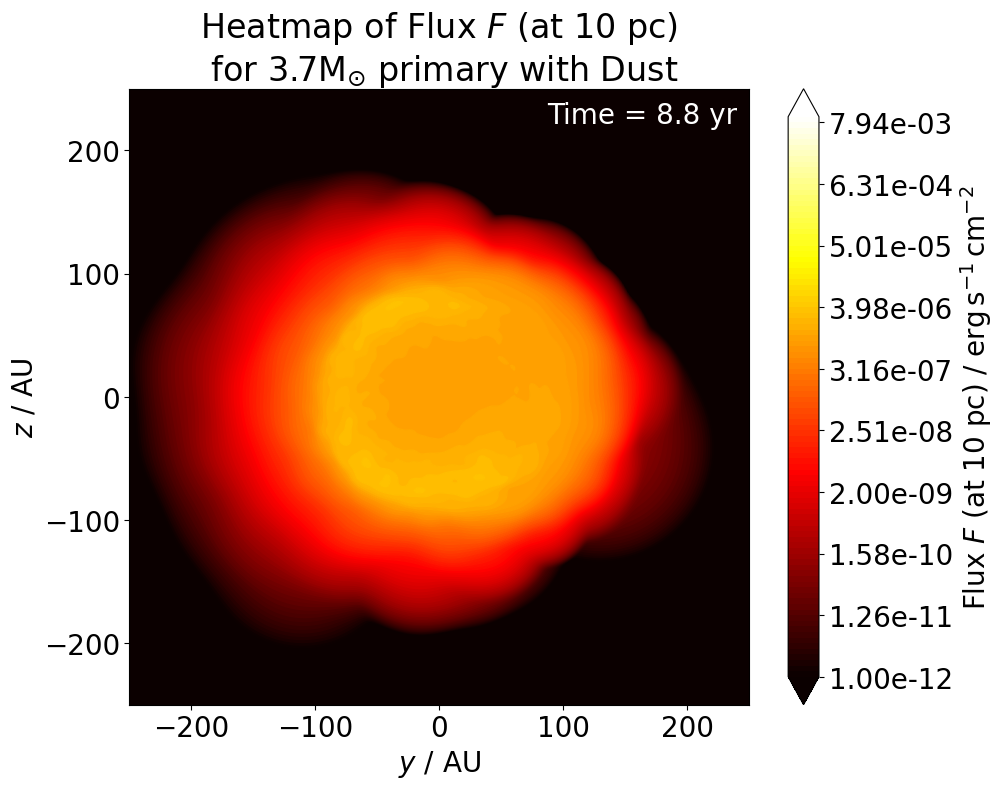

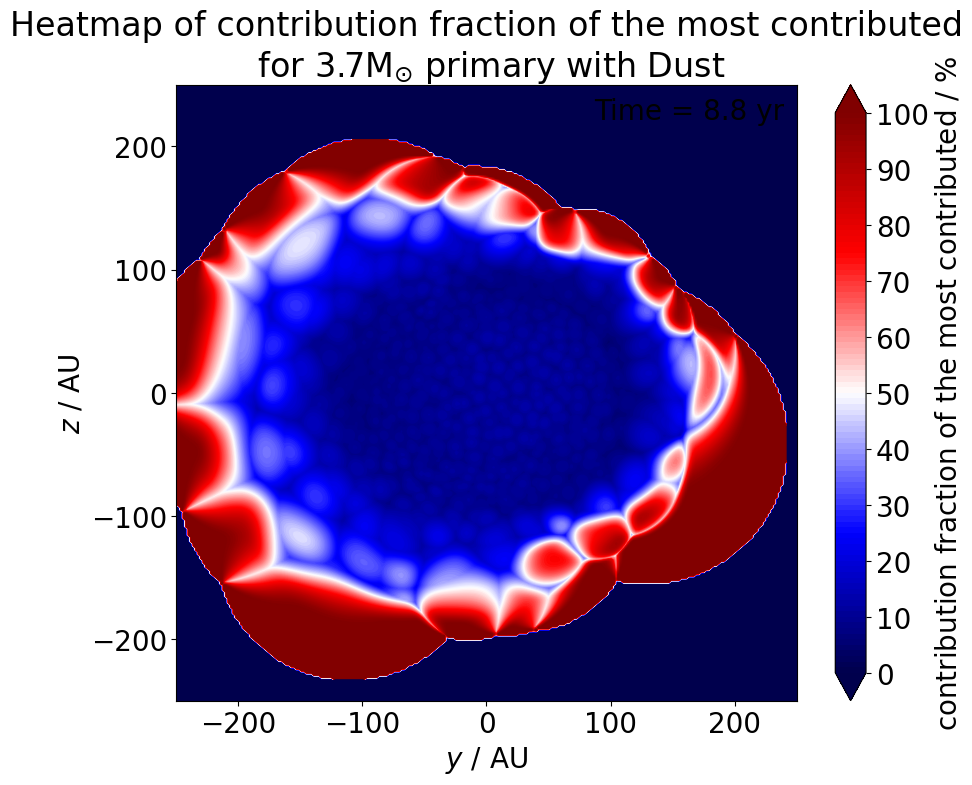

In [38]:
# transitioning
rays_res = 256
no_xy = (rays_res, rays_res)
no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
output_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'


if __name__ == '__main__':

    

    outfilenames_dict = {
        'rads' : {},
        'contr': {},
    }

    figs = []
    for job_nickname in job_nicknames:
        data = {}
        plt.close('all')

        job_profile = JOB_PROFILES_DICT[job_nickname]
        job_name    = job_profile['job_name']
        file_indexes= job_profile['file_indexes']

        #for file_index in file_indexes: #[0, 1200, 4800, 8000, 17600]: #
        i_tr = 3560 if job_nickname not in {'2m_2022', '4m', '4md'} else 3500
        n_tr = 30
        file_index = i_tr

        plt.close('all')
        data_full = mupl.hdf5_load(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{no_xy_txt}.hdf5")
        xyzs_list = list(data_full.keys()).copy() if xyzs_list is None else xyzs_list
        
        # initialize
        for d in outfilenames_dict.keys():
            if job_nickname not in outfilenames_dict[d].keys():
                outfilenames_dict[d][job_nickname] = {xyzs: [] for xyzs in xyzs_list}

        for xyzs in xyzs_list:
            for ixylim, xylim_u in enumerate(np.linspace(100., 250., n_tr)*units.au):
                data = data_full[xyzs]
                # calc flux
                # rads = data['rads'].to(unit_I)
                flux = (data['rads']*data['area_per_ray']*units.rad**2 / spec_dist**2).to(unitsOut['flux'])
                
                # reconstructing rays
                rays_u = np.zeros((data['rays'].shape[0], 2, 3)) * units.au
                rays_u[:, 0, :2] = data['rays']
                rays_u[:, 1, :2] = data['rays']
                rays_u[:, 1] += data['ray_unit_vec'] * units.au

                # I_avg = (data['lum']/(4*pi*units.rad**2*data['area_one'])).to(unit_I)
                # I_range = np.min((20., (rads.max()/I_avg).cgs.value,)) * I_avg.value # rads.max().to(unit_I).value #
                I_avg = (data['lum']/(4*pi*spec_dist**2)*np.mean(data['area_per_ray']/data['area_one'])).to(unitsOut['flux'])
                I_range = np.min((20., (flux.max()/I_avg).cgs.value,)) * I_avg.value # flux.max().to(unit_I).value #
                

                # plotting

                for fig in figs:
                    fig.clear()
                    plt.close(fig)
                    del fig
                del figs
                figs = []
                
                cmap = plt.get_cmap('hot') #plt.get_cmap()
                #cmap.set_over('white')

                # xylim_u = 100*units.au if file_index<=3560 else 250*units.au
                
                fig, _, outfilenames = plot_heat(
                    no_xy, rays_u, flux,
                    data_label=f"Flux $F$ (at {spec_dist.value:.0f} {spec_dist.unit.to_string('latex_inline')})",
                    xyzs=xyzs, save_label=f"image-{ixylim:04d}",
                    job_profile=job_profile, file_index=file_index, cmap=cmap, notes=data,
                    norm=norm_image,
                    cbar_num_fmt=lambda x, pos: f"{x:.2e}",
                    facecolor=cmap.get_under(), text_color='white',
                    xylim=xylim_u.to_value(rays_u.unit),
                    output_dir=output_dir, out_exts=['png'], verbose=verbose_loop)
                outfilenames_dict['rads' ][job_nickname][xyzs].append(outfilenames[-1])
                figs.append(fig)
                
                fig, _, outfilenames = plot_heat(
                    no_xy, rays_u, data['contr'], data_label="contribution fraction of the most contributed",
                    xyzs=xyzs, save_label=f"contr-{ixylim:04d}",
                    job_profile=job_profile, file_index=file_index, cmap='seismic', notes=data,
                    ticks=10,
                    norm=mpl.colors.Normalize(0., 100.),
                    xylim=xylim_u.to_value(rays_u.unit),
                    output_dir=output_dir, out_exts=['png'], verbose=verbose_loop)
                outfilenames_dict['contr'][job_nickname][xyzs].append(outfilenames[-1])
                figs.append(fig)
                del data, rays_u, flux, I_avg, I_range
        del data_full
        gc.collect()

In [22]:
# generating movies (2md) (with 2 different fps speed- fixed to 1/6 second per 100 dumps)
if __name__ == '__main__':
    no_xy_txt = "256x256"
    job_nickname = '2md'
    # i_tr = 3560   # transitional frame index
    n_tr = 30     # transitional frame no
    for xyz in ['xyz', 'xzy', 'yzx']:
        input_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'
        output_dir= f'../fig/20240222_LCGen/'
        for mode in ['image', 'contr']:
            fps1, outfilenames1 = 30, [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(   0,  i_tr,  20)
            ] + [
                f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{0:04d}_256x256.png"
            ]*5 + [
                f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{i_t:04d}_256x256.png" for i_t in range(n_tr)
            ] + [
                f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{n_tr-1:04d}_256x256.png"
            ]*5 + [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(i_tr,  5000,  20)
            ]
            fps2, outfilenames2 = 12, [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(5000, 9900+1,  50)
            ]
            moviefilename = f'{output_dir}heat_{job_nickname}__{xyz}_{mode}_{no_xy_txt}__movie-hollywood.mp4'
            with ImageSequenceClip(outfilenames1, fps=fps1) as vid1, ImageSequenceClip(outfilenames2, fps=fps2) as vid2:
                concatenate_videoclips((vid1, vid2)).write_videofile(moviefilename)

Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xyz_image_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xyz_image_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xyz_image_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xyz_contr_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xyz_contr_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xyz_contr_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xzy_image_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xzy_image_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xzy_image_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xzy_contr_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xzy_contr_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xzy_contr_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__yzx_image_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__yzx_image_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__yzx_image_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__yzx_contr_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__yzx_contr_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__yzx_contr_256x256__movie-hollywood.mp4


In [21]:
# generating movies (2md) (with 2 different fps speed- fixed to 1/6 second per 100 dumps - No transitioning)
if __name__ == '__main__':
    no_xy_txt = "256x256"
    job_nickname = '2md'
    file_index_final = JOB_PROFILES_DICT[job_nickname]['file_indexes'][-1]
    i_tr = 3560   # transitional frame index
    # n_tr = 30     # transitional frame no
    for xyz in ['xyz', 'xzy', 'yzx']:
        input_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'
        output_dir= f'../fig/20240222_LCGen/'
        for mode in ['image', 'contr']:
            fps1, outfilenames1 = 30, [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(   0,  i_tr,  20)
            ] + [
            #     f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{0:04d}_256x256.png"
            # ]*5 + [
            #     f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{i_t:04d}_256x256.png" for i_t in range(n_tr)
            # ] + [
            #     f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{n_tr-1:04d}_256x256.png"
            # ]*5 + [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(i_tr,  5000,  20)
            ]
            fps2, outfilenames2 = 12, [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(5000, file_index_final+1,  50)
            ]
            moviefilename = f'{output_dir}heat_{job_nickname}__{xyz}_{mode}_{no_xy_txt}__movie.mp4'
            with ImageSequenceClip(outfilenames1, fps=fps1) as vid1, ImageSequenceClip(outfilenames2, fps=fps2) as vid2:
                concatenate_videoclips((vid1, vid2)).write_videofile(moviefilename)

Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xyz_image_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xyz_image_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xyz_image_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xyz_contr_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xyz_contr_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xyz_contr_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xzy_image_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xzy_image_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xzy_image_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xzy_contr_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xzy_contr_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xzy_contr_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__yzx_image_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__yzx_image_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__yzx_image_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__yzx_contr_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__yzx_contr_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__yzx_contr_256x256__movie.mp4


In [18]:
# generating movies (4md)
if __name__ == '__main__':
    no_xy_txt = "256x256"
    job_nickname = '4md'
    for xyz in ['xyz', 'xzy', 'yzx']:
        input_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'
        output_dir= f'../fig/20240222_LCGen/'
        for mode in ['image', 'contr']:
            fps1, outfilenames1 =  6, [f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(0, 17600+1, 100)]
            moviefilename = f'{output_dir}heat_{job_nickname}__{xyz}_{mode}_{no_xy_txt}__movie.mp4'
            with ImageSequenceClip(outfilenames1, fps=fps1) as vid1:
                vid1.write_videofile(moviefilename)

Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xyz_image_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xyz_image_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xyz_image_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xyz_contr_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xyz_contr_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xyz_contr_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xzy_image_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xzy_image_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xzy_image_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xzy_contr_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xzy_contr_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xzy_contr_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__yzx_image_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__yzx_image_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__yzx_image_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__yzx_contr_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__yzx_contr_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__yzx_contr_256x256__movie.mp4


In [24]:
# generating movies (4md) (with transition- fixed to 1/6 second per 100 dumps)
if __name__ == '__main__':
    no_xy_txt = "256x256"
    job_nickname = '4md'
    i_tr = 3560 if job_nickname not in {'2m_2022', '4m', '4md'} else 3500
    for xyz in ['xyz', 'xzy', 'yzx']:
        input_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'
        output_dir= f'../fig/20240222_LCGen/'
        for mode in ['image', 'contr']:
            fps1, outfilenames1 = 6, [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(   0,  i_tr, 100)
            ] + [
                f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{0:04d}_256x256.png"
            ]*int(5/5) + [
                f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{i_t:04d}_256x256.png" for i_t in range(0, n_tr, 5)
            ] + [
                f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{n_tr-1:04d}_256x256.png"
            ]*int(5/5) + [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(i_tr,  5000+1, 100)
            ]
            moviefilename = f'{output_dir}heat_{job_nickname}__{xyz}_{mode}_{no_xy_txt}__movie-hollywood.mp4'
            with ImageSequenceClip(outfilenames1, fps=fps1) as vid1:
                vid1.write_videofile(moviefilename)

Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xyz_image_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xyz_image_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xyz_image_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xyz_contr_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xyz_contr_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xyz_contr_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xzy_image_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xzy_image_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xzy_image_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xzy_contr_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xzy_contr_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xzy_contr_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__yzx_image_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__yzx_image_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__yzx_image_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__yzx_contr_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__yzx_contr_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__yzx_contr_256x256__movie-hollywood.mp4


In [42]:
# generating movies (2m) (with 2 different fps speed- fixed to 1/6 second per 100 dumps)
if __name__ == '__main__':
    no_xy_txt = "256x256"
    job_nickname = '4m' #'2m_2022'
    i_tr = 3500   # transitional frame index
    n_tr = 30     # transitional frame no
    for xyz in ['xyz', 'xzy', 'yzx']:
        input_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'
        output_dir= f'../fig/20240222_LCGen/'
        for mode in ['image', 'contr']:
            fps1, outfilenames1 = 6, [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(   0,  i_tr+1, 100)
            ] + [
                f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{0:04d}_256x256.png"
            ]*1
            fps2, outfilenames2 = 30, [
                f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{i_t:04d}_256x256.png" for i_t in range(n_tr)
            ]
            fps3, outfilenames3 = 6, [
                f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{n_tr-1:04d}_256x256.png"
            ]*1 + [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(i_tr+100, 5000+1, 100)
            ] 
            moviefilename = f'{output_dir}heat_{job_nickname}__{xyz}_{mode}_{no_xy_txt}__movie.for-public.mp4'
            with ImageSequenceClip(
                outfilenames1, fps=fps1) as vid1,  ImageSequenceClip(
                outfilenames2, fps=fps2) as vid2,  ImageSequenceClip(
                outfilenames3, fps=fps3) as vid3:
                concatenate_videoclips((vid1, vid2, vid3)).write_videofile(moviefilename)

t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:09<00:01, 59.80it/s, now=None]

Moviepy - Building video ../fig/20240222_LCGen/heat_4m__xyz_image_256x256__movie.for-public.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4m__xyz_image_256x256__movie.for-public.mp4




t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:14<00:01, 59.80it/s, now=None]

Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4m__xyz_image_256x256__movie.for-public.mp4


t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:15<00:01, 59.80it/s, now=None]

Moviepy - Building video ../fig/20240222_LCGen/heat_4m__xyz_contr_256x256__movie.for-public.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4m__xyz_contr_256x256__movie.for-public.mp4




t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:21<00:01, 59.80it/s, now=None]

Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4m__xyz_contr_256x256__movie.for-public.mp4


t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:22<00:01, 59.80it/s, now=None]

Moviepy - Building video ../fig/20240222_LCGen/heat_4m__xzy_image_256x256__movie.for-public.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4m__xzy_image_256x256__movie.for-public.mp4




t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:28<00:01, 59.80it/s, now=None]

Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4m__xzy_image_256x256__movie.for-public.mp4


t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:29<00:01, 59.80it/s, now=None]

Moviepy - Building video ../fig/20240222_LCGen/heat_4m__xzy_contr_256x256__movie.for-public.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4m__xzy_contr_256x256__movie.for-public.mp4




t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:35<00:01, 59.80it/s, now=None]

Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4m__xzy_contr_256x256__movie.for-public.mp4


t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:36<00:01, 59.80it/s, now=None]

Moviepy - Building video ../fig/20240222_LCGen/heat_4m__yzx_image_256x256__movie.for-public.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4m__yzx_image_256x256__movie.for-public.mp4




t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:42<00:01, 59.80it/s, now=None]

Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4m__yzx_image_256x256__movie.for-public.mp4


t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:43<00:01, 59.80it/s, now=None]

Moviepy - Building video ../fig/20240222_LCGen/heat_4m__yzx_contr_256x256__movie.for-public.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4m__yzx_contr_256x256__movie.for-public.mp4




t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:49<00:01, 59.80it/s, now=None]

Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4m__yzx_contr_256x256__movie.for-public.mp4


### Selected few plots for paper

In [21]:
# tbp = to be plotted
output_dir= f'../fig/20240222_LCGen/'
file_indexes_tbp = [0, 1200, 2000, 4800, 17600] #[0, 400, 800, 1200, 1600, 2000] #
rays_res = 256
no_xy = (rays_res, rays_res)
no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
norm_image = mpl.colors.LogNorm(1e-12, 1e-2, clip=False)

#### image and contr

*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00000.lcgen.1024x1024.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00400.lcgen.1024x1024.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00800.lcgen.1024x1024.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_01200.lcgen.1024x1024.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_01600.lcgen.1024x1024.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_02000.lcgen.1024x1024.hdf5  (compress=False)
Saved to ../fig/20240222_LCGen/image_2md_1024x1024.pdf
Saved to ../fig/20240222_LCGen/image_2md_1024x1024.png


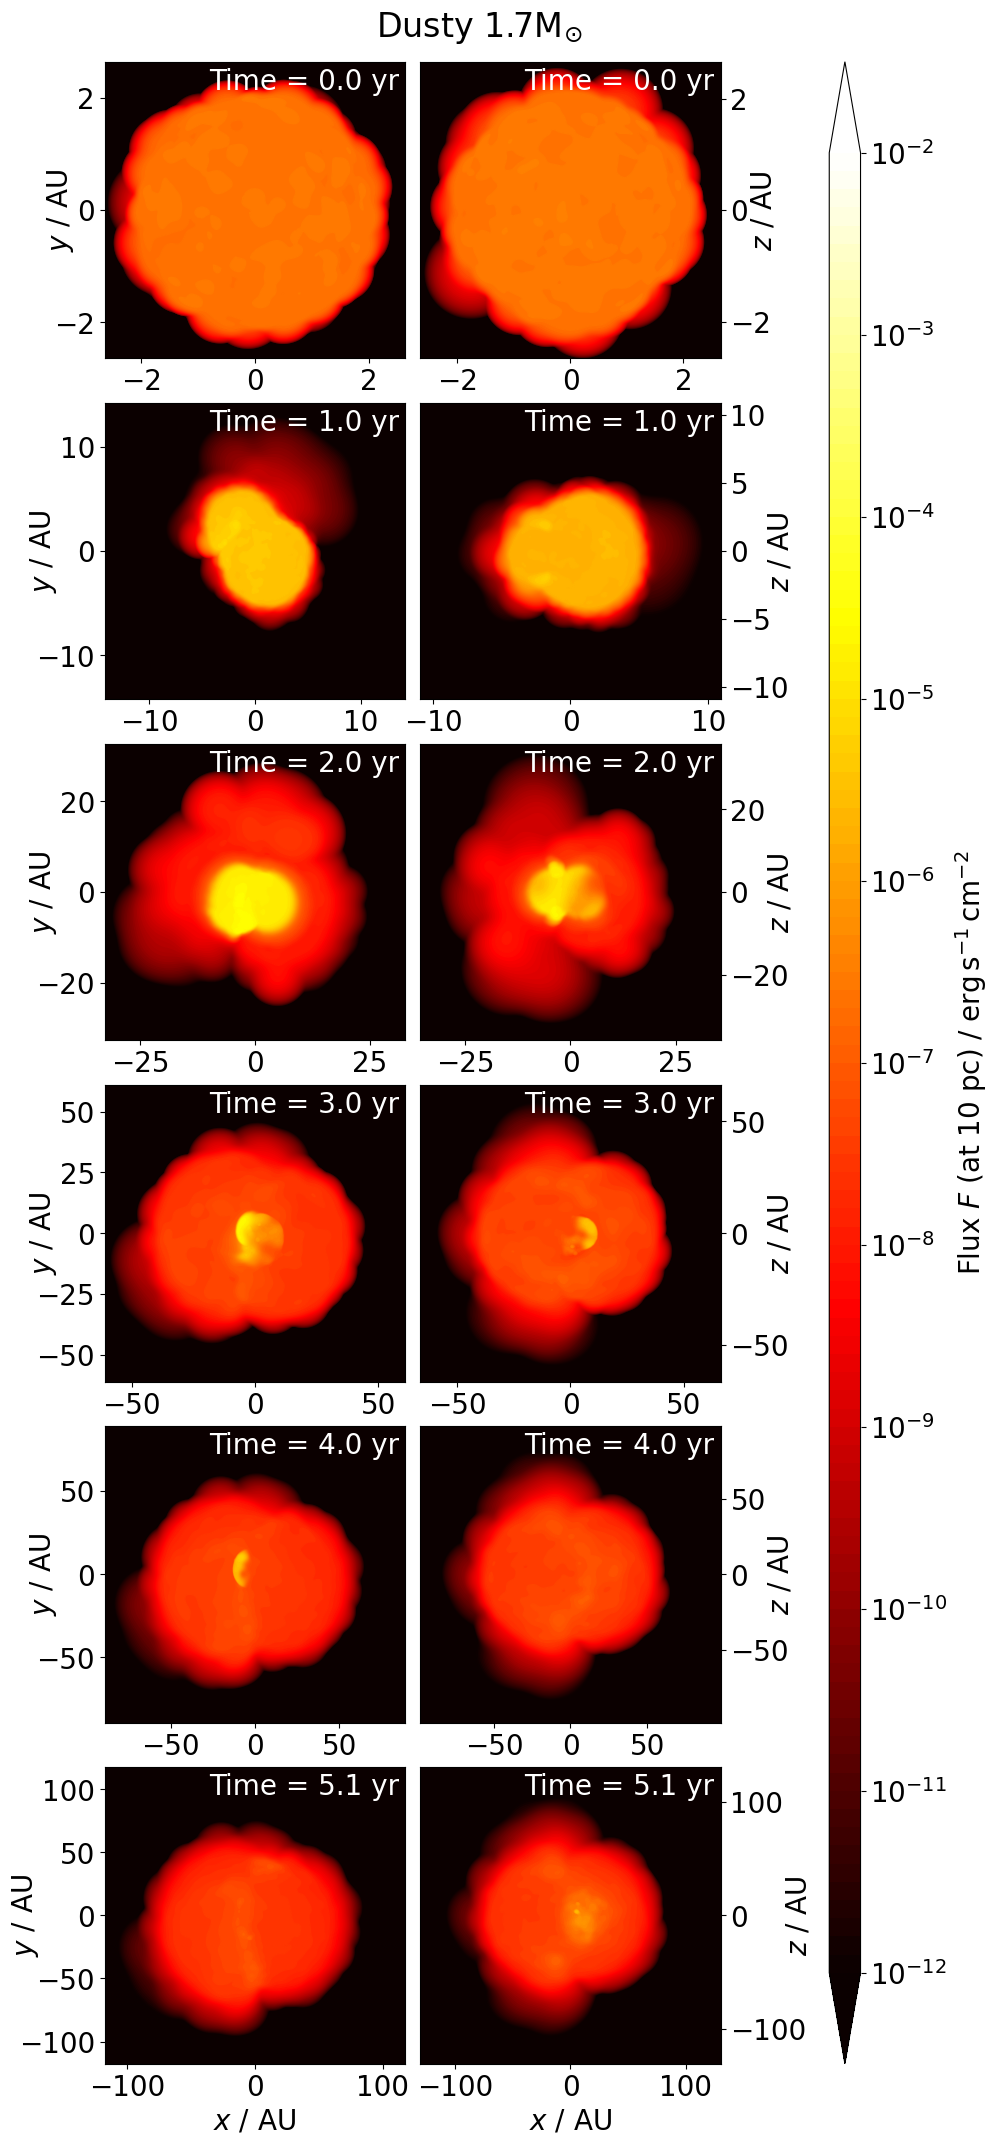

In [22]:
# plot image
if __name__ == '__main__':

    xyzs_list = ['xyz', 'xzy']
    job_nickname = '2md'
    out_savename = get_out_savename([job_nickname])
    
    job_profile = JOB_PROFILES_DICT[job_nickname]
    job_name    = job_profile['job_name']
    
    plt.close('all')
    nrow, ncol = len(file_indexes_tbp), len(xyzs_list)
    fig, axes = plt.subplots(nrow, ncol, figsize=(2+4*ncol, 2+4*nrow))
    fig.subplots_adjust(hspace=0.15, wspace=0.05)
    ylabelcoord_dict = {}

    for ifile, file_index in enumerate(file_indexes_tbp):
        try:
            data_full = mupl.hdf5_load(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{no_xy_txt}.hdf5")

            for ixyz, xyzs in enumerate(xyzs_list):
                irow, icol = ifile, ixyz
                ax = axes[irow, icol]
                data = data_full[xyzs]
                
                # calc flux
                y = (data['rads']*data['area_per_ray']*units.rad**2 / spec_dist**2).to(unitsOut['flux'])
                
                # reconstructing rays
                rays_u = np.zeros((data['rays'].shape[0], 2, 3)) * units.au
                rays_u[:, 0, :2] = data['rays']
                rays_u[:, 1, :2] = data['rays']
                rays_u[:, 1] += data['ray_unit_vec'] * units.au
                
                # plotting
                _, cax, _ = plot_heat(
                    no_xy, rays_u, y,
                    fig=fig, ax=ax, plot_cbar=False, out_exts=[],
                    xyzs=xyzs, save_label=f"image",
                    job_profile=job_profile, file_index=file_index, cmap='hot', notes=data,
                    norm=norm_image,
                    #norm=mpl.colors.LogNorm(5e5, 1e9, clip=False),
                    text_color='white', ylabelpad=-16,
                    # xylim=xylim_u.to_value(rays_u.unit),
                    output_dir=None, verbose=verbose_loop)

                if irow != nrow-1: ax.set_xlabel('')
                if icol == ncol-1: ax.yaxis.set_label_position("right"); ax.yaxis.tick_right()

                # fig, _, outfilenames = plot_heat(
                #     no_xy, rays_u, data['contr'], data_label="contribution fraction of the most contributed",
                #     xyzs=xyzs, save_label=f"contr",
                #     job_profile=job_profile, file_index=file_index, cmap='seismic', notes=data,
                #     ticks=10,
                #     norm=mpl.colors.Normalize(0., 100.),
                #     text_color='white',
                #     output_dir=output_dir, out_exts=['png'], verbose=verbose_loop)
                # outfilenames_dict['contr'][job_nickname][xyzs].append(outfilenames[-1])
        except (FileNotFoundError, BlockingIOError) as e:
            print("*** Error:", e)

    data_label=f"Flux $F$ (at {spec_dist.value:.0f} {spec_dist.unit.to_string('latex_inline')})"
    cbar_num_fmt=lambda x, pos: f"$10^{{{(np.log10(x)):.0f}}}$" #lambda x, pos: f"{x:.2e}"
    ticks = 10**np.arange(np.ceil(np.log10(norm_image.vmin)), np.floor(np.log10(norm_image.vmax))+.01)
    cbar= fig.colorbar(
        cax, ax=axes,
        label=f"{data_label} / {y.unit.to_string('latex_inline')}", ticks=ticks, format=cbar_num_fmt,
        fraction=0.065, pad=0.14, aspect=64,
    )

    fig.suptitle(job_profile['name'], verticalalignment='top', y=0.9)
    
    outfilename_noext = f"{output_dir}image_{job_nickname}_{no_xy_txt}"
    
    fig.savefig(f"{outfilename_noext}.pdf")
    print(f"Saved to {outfilename_noext}.pdf")
    fig.savefig(f"{outfilename_noext}.png")
    print(f"Saved to {outfilename_noext}.png")

*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00000.lcgen.1024x1024.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00400.lcgen.1024x1024.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00800.lcgen.1024x1024.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_01200.lcgen.1024x1024.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_01600.lcgen.1024x1024.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_02000.lcgen.1024x1024.hdf5  (compress=False)
Saved to ../fig/20240222_LCGen/contr_2md_1024x1024.pdf
Saved to ../fig/20240222_LCGen/contr_2md_1024x1024.png


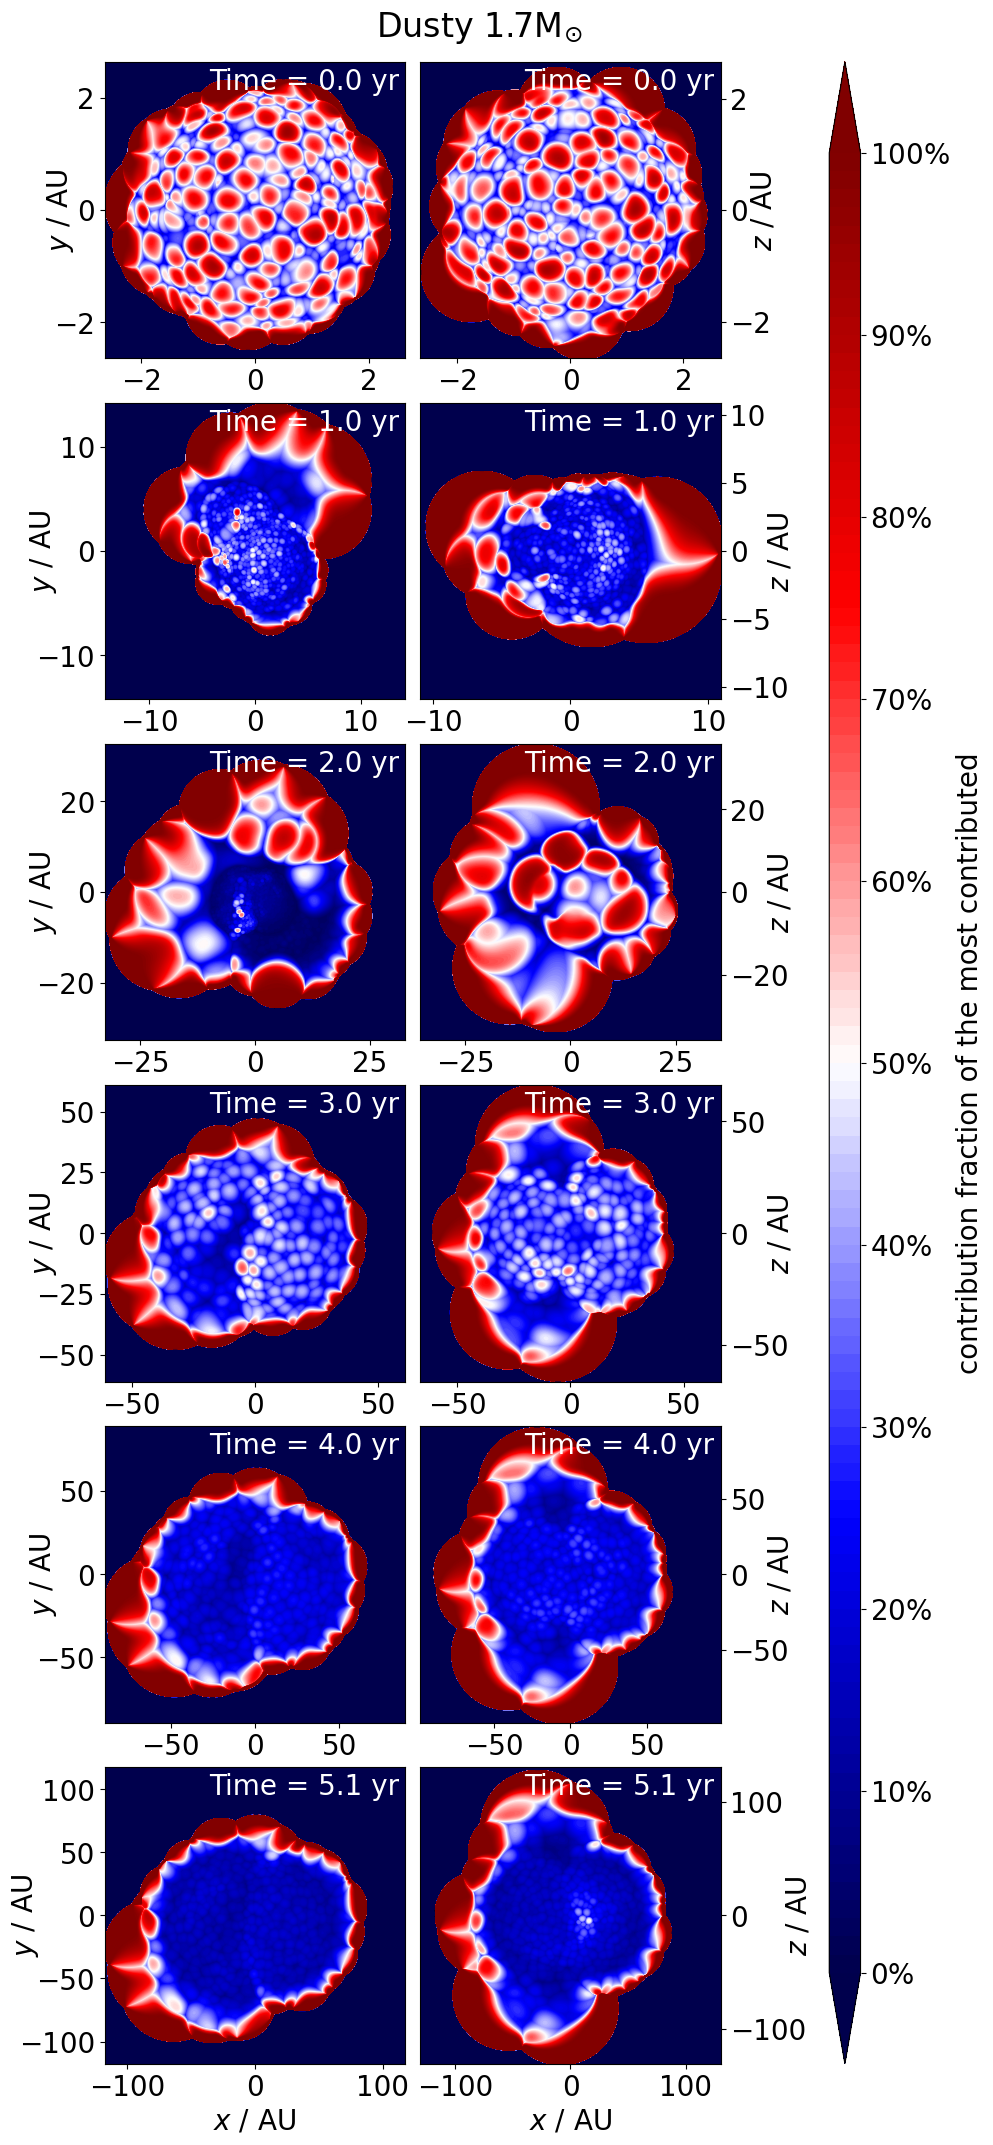

In [23]:
# plot contr
if __name__ == '__main__':

    xyzs_list = ['xyz', 'xzy']
    job_nickname = '2md'
    out_savename = get_out_savename([job_nickname])
    
    plt.close('all')
    nrow, ncol = len(file_indexes_tbp), len(xyzs_list)
    fig, axes = plt.subplots(nrow, ncol, figsize=(2+4*ncol, 2+4*nrow))
    fig.subplots_adjust(hspace=0.15, wspace=0.05)

    for ifile, file_index in enumerate(file_indexes_tbp):
        job_profile = JOB_PROFILES_DICT[job_nickname]
        job_name    = job_profile['job_name']
        try:
            data_full = mupl.hdf5_load(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{no_xy_txt}.hdf5")

            for ixyz, xyzs in enumerate(xyzs_list):
                irow, icol = ifile, ixyz
                ax = axes[irow, icol]
                data = data_full[xyzs]
                
                # reconstructing rays
                rays_u = np.zeros((data['rays'].shape[0], 2, 3)) * units.au
                rays_u[:, 0, :2] = data['rays']
                rays_u[:, 1, :2] = data['rays']
                rays_u[:, 1] += data['ray_unit_vec'] * units.au
                
                # plotting
                y = data['contr']
                norm = mpl.colors.Normalize(0., 100.)
                _, cax, _ = plot_heat(
                    no_xy, rays_u, y,
                    fig=fig, ax=ax, plot_cbar=False, out_exts=[],
                    xyzs=xyzs, save_label=f"contr",
                    job_profile=job_profile, file_index=file_index, cmap='seismic', notes=data,
                    norm=norm,
                    text_color='white', ylabelpad=-16,
                    output_dir=None, verbose=verbose_loop)

                if irow != nrow-1: ax.set_xlabel('')
                if icol == ncol-1: ax.yaxis.set_label_position("right"); ax.yaxis.tick_right()



        except (FileNotFoundError, BlockingIOError) as e:
            print("*** Error:", e)

    data_label="contribution fraction of the most contributed"
    ticks = np.linspace(norm.vmin, norm.vmax, 10+1)
    cbar_num_fmt=lambda x, pos: f"{x:.0f}$\\%$"
    cbar= fig.colorbar(
        cax, ax=axes,
        label=f"{data_label}", ticks=ticks, format=cbar_num_fmt,
        fraction=0.065, pad=0.14, aspect=64,
    )

    fig.suptitle(job_profile['name'], verticalalignment='top', y=0.9)
    
    outfilename_noext = f"{output_dir}contr_{job_nickname}_{no_xy_txt}"
    
    fig.savefig(f"{outfilename_noext}.pdf")
    print(f"Saved to {outfilename_noext}.pdf")
    fig.savefig(f"{outfilename_noext}.png")
    print(f"Saved to {outfilename_noext}.png")

#### SED / Spec

*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00000.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_00000.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_01200.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_01200.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_02000.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_02000.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_04800.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_048

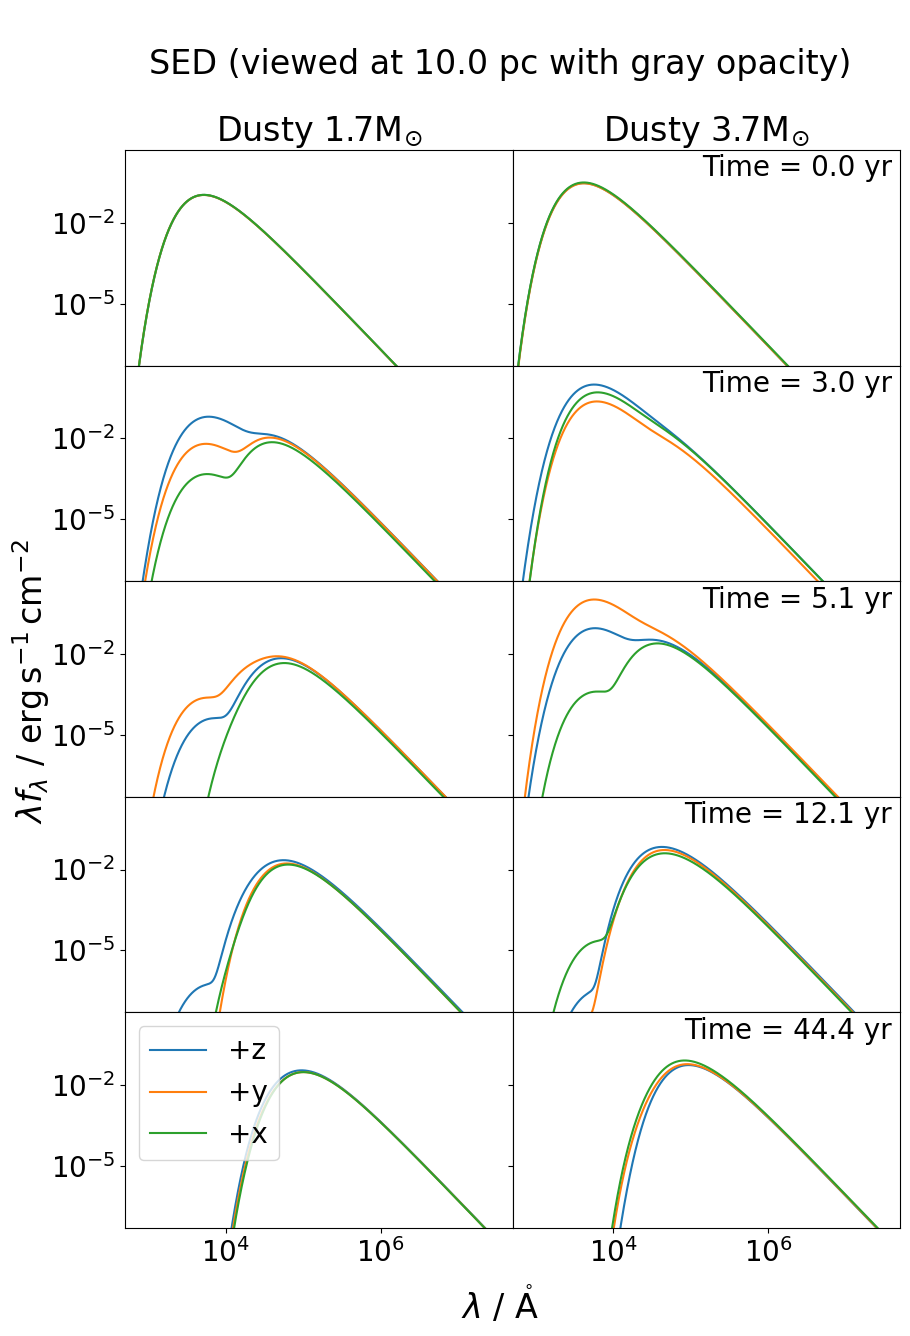

In [31]:
# plot SED

if __name__ == '__main__':

    job_nicknames = ['2md', '4md']
    out_savename = get_out_savename(job_nicknames)

    # spec_dist = 10 * units.parsec
    # unit_flux = (units.erg / units.s / units.cm**2) / units.angstrom

    plt.close('all')
    nrow, ncol = len(file_indexes_tbp), len(job_nicknames)
    fig, axes = plt.subplots(nrow, ncol, figsize=(5*ncol, 3*nrow-1), sharex=True, sharey=True, squeeze=False)
    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    for ifile, file_index in enumerate(file_indexes_tbp):
        for ijob, job_nickname in enumerate(job_nicknames):
            irow, icol = ifile, ijob
            ax = axes[irow, icol]

            job_profile = JOB_PROFILES_DICT[job_nickname]
            job_name    = job_profile['job_name']

            data_full = mupl.hdf5_load(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{no_xy_txt}.hdf5")
            xyzs_list = list(data_full.keys()).copy() if xyzs_list is None else xyzs_list

            
            for xyzs in xyzs_list:
                data = data_full[xyzs]
                L_wavs = data['L_wavs']
                wavlens = data['wavlens']
                y = (L_wavs/(4*pi*spec_dist**2) * wavlens).to(unitsOut['flux_wav'] * units.angstrom)
                x = wavlens.to(units.angstrom)
                ax.loglog(x, y, label=f"+{xyzs[2]}")

            if irow == 0:
                ax.set_title(job_profile['name'])
            ax.set_xlim(5e2, 5e7) #(5e2, 2e6)
            ax.set_ylim(5e-8, 5e0) #(5e-9, 5e-4)
            if icol == ncol-1:
                ax.text(
                    0.98, 0.98,
                    f"Time = {data['time']:.1f}\n",
                    #color = "black",
                    ha = 'right', va = 'top',
                    transform=ax.transAxes,
                )
            if icol == 0 and irow == nrow-1:
                ax.legend()

    
    outfilename_noext = f"{output_dir}Spec_{no_xy_txt}"

    fig.supxlabel(f"$\\lambda$ / {x.unit.to_string('latex_inline')}", y=0.04)
    fig.supylabel(f"$\\lambda f_{{\\lambda}}$ / {y.unit.to_string('latex_inline')}", x=0.01)
    
    fig.savefig(f"{outfilename_noext}.pdf")
    print(f"Saved to {outfilename_noext}.pdf")

    title_txt = f"\nSED (viewed at {spec_dist:.1f} with gray opacity)"
    if len(job_nicknames) > 1:
        fig.suptitle(title_txt)
    else:
        axes[0, 0].set_title(title_txt)
    fig.savefig(f"{outfilename_noext}.png")
    print(f"Saved to {outfilename_noext}.png")

*   Note   :    <module>() ==> plot_SED_2md_only() ==> hdf5_load():
	Reading from ../interm/2md_00000.lcgen.1024x1024.hdf5  (compress=False)
*   Note   :    <module>() ==> plot_SED_2md_only() ==> hdf5_load():
	Reading from ../interm/2md_00400.lcgen.1024x1024.hdf5  (compress=False)
*   Note   :    <module>() ==> plot_SED_2md_only() ==> hdf5_load():
	Reading from ../interm/2md_00800.lcgen.1024x1024.hdf5  (compress=False)
*   Note   :    <module>() ==> plot_SED_2md_only() ==> hdf5_load():
	Reading from ../interm/2md_01200.lcgen.1024x1024.hdf5  (compress=False)
*   Note   :    <module>() ==> plot_SED_2md_only() ==> hdf5_load():
	Reading from ../interm/2md_01600.lcgen.1024x1024.hdf5  (compress=False)
*   Note   :    <module>() ==> plot_SED_2md_only() ==> hdf5_load():
	Reading from ../interm/2md_02000.lcgen.1024x1024.hdf5  (compress=False)
Saved to ../fig/20240222_LCGen/Spec_2md_1024x1024.pdf
Saved to ../fig/20240222_LCGen/Spec_2md_1024x1024.png


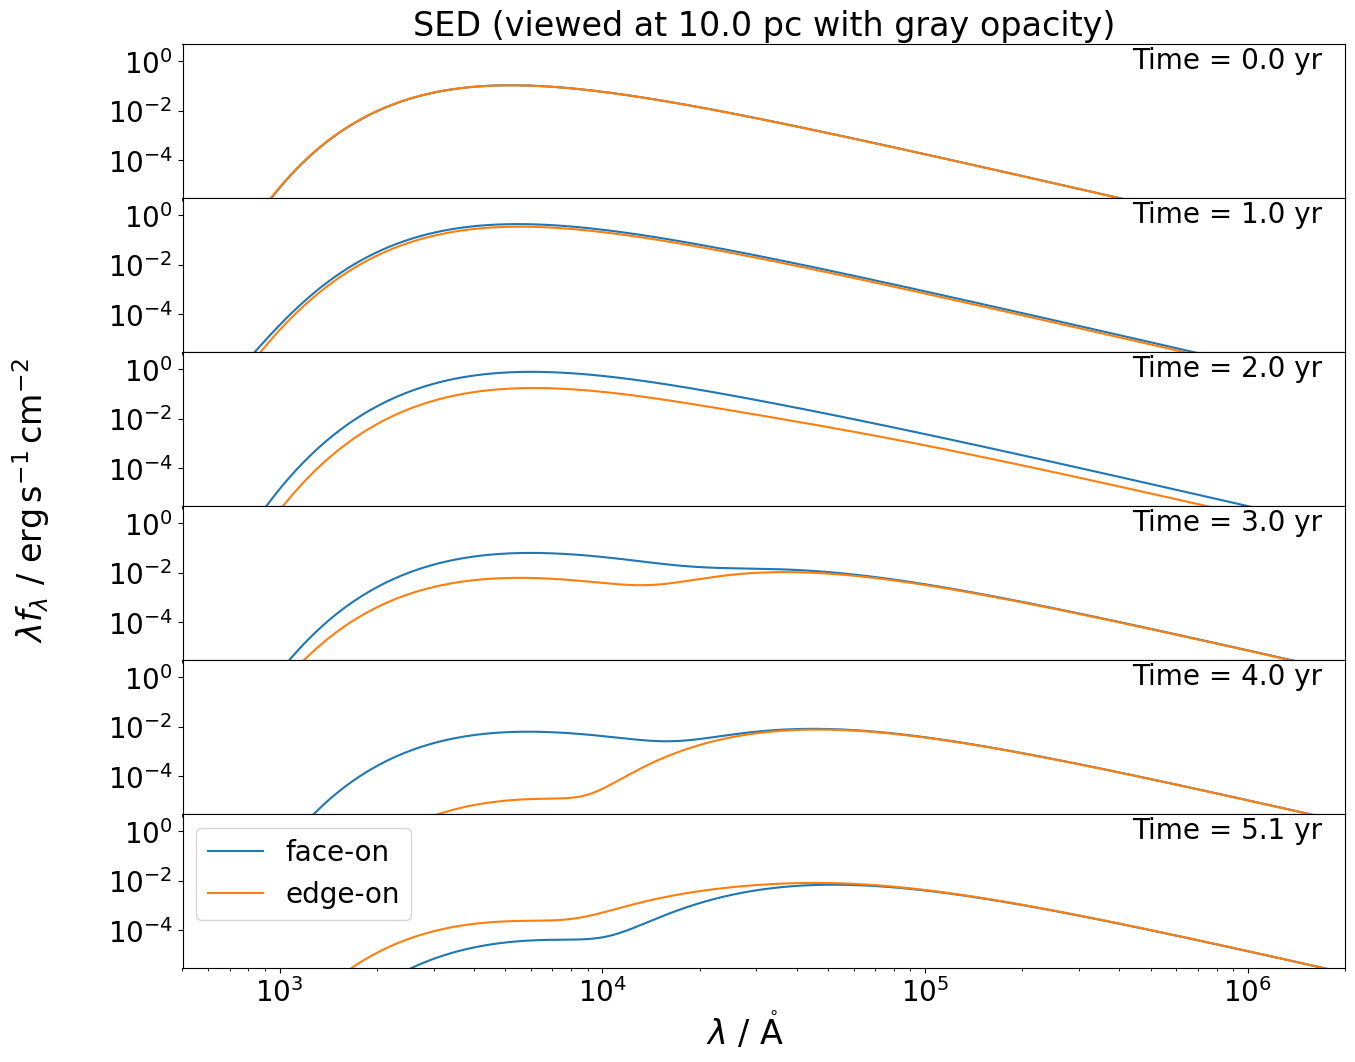

In [33]:
# plot SED (2md only)

def plot_SED_2md_only():

    job_nicknames = ['2md']
    out_savename = get_out_savename(job_nicknames)
    file_indexes_tbp = [0, 400, 800, 1200, 1600, 2000] # [0, 800, 1200, 1600, 4800, 17600]
    xyzs_list = ['xyz', 'xzy']
    
    # spec_dist = 10 * units.parsec
    # unit_flux = (units.erg / units.s / units.cm**2) / units.angstrom

    plt.close('all')
    nrow, ncol = len(file_indexes_tbp), len(job_nicknames)
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 12), sharex=True, sharey=True, squeeze=False)
    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    for ifile, file_index in enumerate(file_indexes_tbp):
        for ijob, job_nickname in enumerate(job_nicknames):
            irow, icol = ifile, ijob
            ax = axes[irow, icol]

            job_profile = JOB_PROFILES_DICT[job_nickname]
            job_name    = job_profile['job_name']

            data_full = mupl.hdf5_load(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{no_xy_txt}.hdf5")
            xyzs_list = list(data_full.keys()).copy() if xyzs_list is None else xyzs_list

            
            for xyzs in xyzs_list:
                data = data_full[xyzs]
                L_wavs = data['L_wavs']
                wavlens = data['wavlens']
                y = (wavlens*L_wavs/(4*pi*spec_dist**2)).to(units.angstrom*unitsOut['flux_wav'])
                x = wavlens.to(units.angstrom)
                ax.loglog(x, y, label="face-on" if  xyzs[2] == 'z' else "edge-on")

            if irow == 0:
                ax.set_title(job_profile['name'])
            ax.set_xlim(5e2, 2e6)
            ax.set_ylim(3e-6, 5e-0)
            ax.set_yticks([1e-4, 1e-2, 1e0])
            if icol == ncol-1:
                ax.text(
                    0.98, 0.98,
                    f"Time = {data['time']:.1f}\n",
                    #color = "black",
                    ha = 'right', va = 'top',
                    transform=ax.transAxes,
                )
            if icol == 0 and irow == nrow-1:
                ax.legend()

    
    outfilename_noext = f"{output_dir}Spec_2md_{no_xy_txt}"

    fig.supxlabel(f"$\\lambda$ / {x.unit.to_string('latex_inline')}", y=0.04)
    fig.supylabel(f"$\\lambda f_{{\\lambda}}$ / {y.unit.to_string('latex_inline')}", x=0.01)
    
    fig.savefig(f"{outfilename_noext}.pdf")
    print(f"Saved to {outfilename_noext}.pdf")

    title_txt = f"SED (viewed at {spec_dist:.1f} with gray opacity)"
    if len(job_nicknames) > 1:
        fig.suptitle(title_txt)
    else:
        axes[0, 0].set_title(title_txt)
    fig.savefig(f"{outfilename_noext}.png")
    print(f"Saved to {outfilename_noext}.png")
    return fig, ax

if __name__ == '__main__':
    fig, ax = plot_SED_2md_only()

In [34]:
help(ax.set_yticks)

Help on method set_yticks in module matplotlib.axes._base:

set_yticks(ticks, labels=None, *, minor=False, **kwargs) method of matplotlib.axes._axes.Axes instance
    Set the yaxis' tick locations and optionally tick labels.

    If necessary, the view limits of the Axis are expanded so that all
    given ticks are visible.

    Parameters
    ----------
    ticks : 1D array-like
        Array of tick locations (either floats or in axis units). The axis
        `.Locator` is replaced by a `~.ticker.FixedLocator`.

        Pass an empty list (``set_yticks([])``) to remove all ticks.

        Some tick formatters will not label arbitrary tick positions;
        e.g. log formatters only label decade ticks by default. In
        such a case you can set a formatter explicitly on the axis
        using `.Axis.set_major_formatter` or provide formatted
        *labels* yourself.

    labels : list of str, optional
        Tick labels for each location in *ticks*; must have the same length as
 

### Getting initial MESA profile vs relaxed phantom profile

In [17]:
def plot_stuff(
    stuff_dict: dict,
    x_name: str, y_name: str, mpdf, job_profile,
    xlim: tuple[float, float]=(1., 1.e3),
    label='',
    ylim = None,
):
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))
    xs, ys = stuff_dict[x_name], stuff_dict[y_name]
    if isinstance(xs, units.Quantity): xs = xs.value
    if isinstance(ys, units.Quantity): ys = ys.value
    if xlim is None: mask = np.ones_like(xs, dtype=np.bool_)
    else: mask = np.logical_and(xlim[0] < xs, xs < xlim[1])
    # ax.loglog(xs[mask], ys[mask], '.', label=label)
    ax.semilogy(xs[mask], ys[mask], '.', label=label)
    ax.set_xlabel(f"{x_name} / {stuff_dict[x_name].unit.to_string('latex_inline')}")
    ax.set_ylabel(f"{y_name} / {stuff_dict[y_name].unit.to_string('latex_inline')}")
    ax.text(
        0.98, 0.98, f"Time = {mpdf.get_time()}",
        ha = 'right', va = 'top', transform=ax.transAxes,
    )
    # ax.set_title(f"scatter plot of all particles\n{job_profile['plot_title_suffix']}")
    ax.set_xlim(xlim)
    return fig, ax, mask

In [18]:
def read_mesa_data_normalize(stuff_mesa: dict[str, units.Quantity], eos_opacity):
    stuff_mesa['L'    ] = (4 * pi * stuff_mesa['R1']**2 * (const.sigma_sb * stuff_mesa['T']**4)).to(units.Lsun)
    stuff_mesa['kappa'] = eos_opacity.get_kappa(rho=stuff_mesa['rho'], T=stuff_mesa['T'])
    stuff_mesa['dR1'] = -np.diff(stuff_mesa['R1'], append=0*units.Rsun)
    stuff_mesa['dtau'] = stuff_mesa['kappa'] * stuff_mesa['rho'] * stuff_mesa['dR1']
    stuff_mesa['tau'] = stuff_mesa['dtau'].cumsum()
    #stuff_mesa['wtf'  ] = (4 * pi * stuff_mesa['R1']**2 * (const.sigma_sb * stuff_mesa['T'].value**2.5 * units.K**4)).to(units.Lsun)
    # below should be one, but it is not. Not sure why
    L_0 = stuff_mesa['lum'][0]
    R_0 = stuff_mesa[ 'R1'][0]
    stuff_mesa['factor'] = (stuff_mesa['R1'].cgs**2 * (
        R_0**(-2) - integrate.cumulative_trapezoid(
            (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs, stuff_mesa['R1'].cgs, initial=0
        )*units.cm**(-2))).cgs
    stuff_mesa['wtf'  ]  = (integrate.cumulative_trapezoid(
            (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2)[::-1].cgs, stuff_mesa['R1'][::-1].cgs, initial=0
        )*units.cm**(-2))[::-1]
    stuff_mesa['test' ]  = (stuff_mesa['R1'].cgs[0]**2 * (
        stuff_mesa['R1'].cgs**(-2) - integrate.cumulative_trapezoid(
            (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs, stuff_mesa['R1'].cgs, initial=0
        )*units.cm**(-2))).cgs
    return stuff_mesa


def read_mesa_data_AGB(
    eos_opacity,
    filename = '../dustystar/AGB_th.data',
):
    mesa_data = np.loadtxt(
        filename, skiprows=6,
        usecols=(2, 3, 4, 9, 10, 11, 12, 19),
        dtype=[
            ('log10_R1', np.double),
            ('log10_T', np.double),
            ('log10_rho', np.double),
            ('R1_cm', np.double),
            ('mass_g', np.double),
            ('temp', np.double),
            ('rho', np.double),
            ('lum', np.double)],
    )
    stuff_mesa = {
        'R1': (mesa_data['R1_cm'] * units.cm).to(units.Rsun),
        'T' : mesa_data['temp'] * units.K,
        'lum' : mesa_data['lum'] * units.Lsun,
        'rho' : mesa_data['rho'] * (units.g/units.cm**3),
    }
    return read_mesa_data_normalize(stuff_mesa, eos_opacity)

def read_mesa_data_sun(
    eos_opacity,
    filename = '../raw/clmu_sol/sun.data',
):
    mesa_data = np.loadtxt(
        filename, skiprows=6,
        usecols=(2, 3, 4, 10, 12, 14, 16, 63),
        dtype=[
            ('log10_R1', np.double),
            ('log10_T', np.double),
            ('log10_rho', np.double),
            ('R1_cm', np.double),
            ('mass_g', np.double),
            ('temp', np.double),
            ('rho', np.double),
            ('lum', np.double)],
    )
    stuff_mesa = {
        'R1': (mesa_data['R1_cm'] * units.cm).to(units.Rsun),
        'T' : mesa_data['temp'] * units.K,
        'lum' : mesa_data['lum'] * units.Lsun,
        'rho' : mesa_data['rho'] * (units.g/units.cm**3),
    }
    return read_mesa_data_normalize(stuff_mesa, eos_opacity)

In [19]:
use_Tscales = ''     #'', 'scale', 'cut', 'delete'
job_nickname= 'sol' #'2mdnrt0e1'
reset_xyz_by = 'R1'    # 'R1' if sim has sink particles
do_plot_mesa = True # True if using that MESA profile

label=f'phantom- ' + (f'T{use_Tscales}' if use_Tscales else 'normal')
# read data
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
# reading mesa data
# 'filename' : '../raw/clmu_sol/sun.data',
stuff_mesa = read_mesa_data_sun(eos_opacity)
# reading phantom data
mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by=reset_xyz_by, calc_params=['vr'], use_Tscales=use_Tscales)
sdf  = mpdf.data['gas']
sdf['R1'] = ((sdf['x'])**2 + (sdf['y'])**2 + (sdf['z'])**2)**0.5

*   Note   :    <module>() ==> mpdf_read() ==> read():
	

	Reading filename='../raw/clmu_sol/sol_00000'


*   Note   :    mpdf_read() ==> read() ==> reset_xyz_by():
	Reseting Origin to R1 ([0. 0. 0.])...
*   Note   :    mpdf_read() ==> read() ==> reset_xyz_by():
	CoM location is now [ 1.94065149e-18 -2.31062043e-18 -1.40357908e-18]


In [20]:
R1_bin_size = 0.01

sdf['R1_bin'] = np.floor(sdf['R1']/R1_bin_size)*R1_bin_size
ray = mupl.get_rays(np.array([0., 0., 0.]), np.array([0., 0., 1.]))
srcfuncs = mpdf.const['sigma_sb'] * sdf['T']**4 #/ (4 * pi)

stuff = {}
stuff['kappa'] = mpdf.get_val('kappa').cgs
stuff['R1'   ] = mpdf.get_val('R1').to(units.Rsun)
stuff['T'    ] = mpdf.get_val('T').to(units.K)
stuff['L'    ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T']**4)).to(units.Lsun)
stuff['rho'  ] = mpdf.get_val('rho').cgs
stuff['tau'  ] = np.ones(len(sdf))*PHOTOSPHERE_TAU * units.dimensionless_unscaled

# rolling summary
sdf_grpby = sdf.groupby('R1_bin')
sdf_avg = sdf_grpby.mean()
sdf_std = sdf_grpby.std()
sdf_cnt = sdf_grpby.count()['iorig']
print("Number of bins with less than 8 data points: ", np.count_nonzero(sdf_cnt < 8))

# reconstruct photosphere
sdf_avg['dR1'] = np.diff(sdf_avg['R1'], prepend=0)
sdf_std['dR1'] = 0.
sdf_avg['dtau'] = sdf_avg['kappa'] * sdf_avg['rho'] * sdf_avg['dR1']
sdf_std['dtau'] = sdf_avg['dtau'] * np.sqrt((sdf_std['kappa'] / sdf_avg['kappa'])**2 + (sdf_std['rho'] / sdf_avg['rho'])**2)
sdf_avg['tau'] = sdf_avg['dtau'][::-1].cumsum()[::-1]
sdf_std['tau'] = np.sqrt((sdf_std['dtau']**2)[::-1].cumsum()[::-1])

# get photosphere loc
ph_inner_layers = np.where(sdf_avg['tau'] >= PHOTOSPHERE_TAU)[0]
if ph_inner_layers.size:
    ph_ind = ph_inner_layers[-1]
    ph_R1 = sdf_avg['R1'].iloc[ph_ind]
else:
    ph_ind = len(sdf_avg) - 1
    ph_R1 = sdf_avg['R1'].iloc[-1] + sdf_avg['dR1'].iloc[-1]

# cleaning up
sdf_valp = sdf_avg + sdf_std
sdf_valm = sdf_avg - sdf_std

sdf_avg

Number of bins with less than 8 data points:  2


iorig             x             y             z   temperature  \
R1_bin                                                                          
0.00    693183.115385  1.824436e-08 -9.356022e-09  4.854263e-08  1.397399e+07   
0.01    669488.460836 -1.779321e-09  1.784103e-08  2.443049e-08  1.391286e+07   
0.02    679330.074018  7.300957e-10  3.303572e-08  1.984541e-08  1.380158e+07   
0.03    696824.230608  5.745333e-09  2.359802e-08 -5.186733e-10  1.364132e+07   
0.04    687908.212463  1.509096e-08  1.279571e-08 -1.203513e-09  1.344235e+07   
...               ...           ...           ...           ...           ...   
1.11    711559.300000 -6.095466e-02  8.572181e-02  9.405355e-03  1.074977e+06   
1.12    782491.645833 -3.277032e-02 -5.641304e-02 -3.738500e-03  1.016732e+06   
1.13    782928.587302  2.241635e-02 -3.751428e-02 -2.998200e-02  9.720511e+05   
1.14    664653.875000  3.069296e-03  6.695756e-02  1.733610e-03  9.293827e+05   
1.15    516737.250000 -8.706304e-03 -1.629540e-01  6.834436e-02  8.866465e+05   

        gamma   vx   vy   vz         u  ...             m        rho    v  \
R1_bin                                  ...                                 
0.00      0.0  0.0  0.0  0.0  1.527656  ...  7.268700e-07  18.497759  0.0   
0.01      0.0  0.0  0.0  0.0  1.520889  ...  7.268700e-07  18.375879  0.0   
0.02      0.0  0.0  0.0  0.0  1.508557  ...  7.268700e-07  18.154837  0.0   
0.03      0.0  0.0  0.0  0.0  1.490770  ...  7.268700e-07  17.838155  0.0   
0.04      0.0  0.0  0.0  0.0  1.468650  ...  7.268700e-07  17.447642  0.0   
...       ...  ...  ...  ...       ...  ...           ...        ...  ...   
1.11      0.0  0.0  0.0  0.0  0.129851  ...  7.268700e-07   0.000187  0.0   
1.12      0.0  0.0  0.0  0.0  0.122929  ...  7.268700e-07   0.000172  0.0   
1.13      0.0  0.0  0.0  0.0  0.117649  ...  7.268700e-07   0.000160  0.0   
1.14      0.0  0.0  0.0  0.0  0.112602  ...  7.268700e-07   0.000150  0.0   
1.15      0.0  0.0  0.0  0.0  0.107545  ...  7.268700e-07   0.000139  0.0   

         vr             T         kappa        R1       dR1          dtau  \
R1_bin                                                                      
0.00    0.0  1.397399e+07  6.666843e+11  0.007443  0.007443  9.178568e+10   
0.01    0.0  1.391286e+07  6.707176e+11  0.016147  0.008704  1.072751e+11   
0.02    0.0  1.380158e+07  6.781954e+11  0.025734  0.009587  1.180441e+11   
0.03    0.0  1.364132e+07  6.892817e+11  0.035496  0.009762  1.200267e+11   
0.04    0.0  1.344235e+07  7.035858e+11  0.045355  0.009859  1.210294e+11   
...     ...           ...           ...       ...       ...           ...   
1.11    0.0  1.074977e+06  1.388548e+12  1.114822  0.010696  2.781793e+06   
1.12    0.0  1.016732e+06  1.557579e+12  1.126359  0.011536  3.088508e+06   
1.13    0.0  9.720511e+05  1.716334e+12  1.135216  0.008857  2.437809e+06   
1.14    0.0  9.293827e+05  1.902093e+12  1.144424  0.009208  2.621110e+06   
1.15    0.0  8.866465e+05  2.134166e+12  1.153396  0.008973  2.665077e+06   

                 tau  
R1_bin                
0.00    3.158137e+12  
0.01    3.066351e+12  
0.02    2.959076e+12  
0.03    2.841032e+12  
0.04    2.721005e+12  
...              ...  
1.11    1.359430e+07  
1.12    1.081250e+07  
1.13    7.723995e+06  
1.14    5.286186e+06  
1.15    2.665077e+06  

[105 rows x 26 columns]

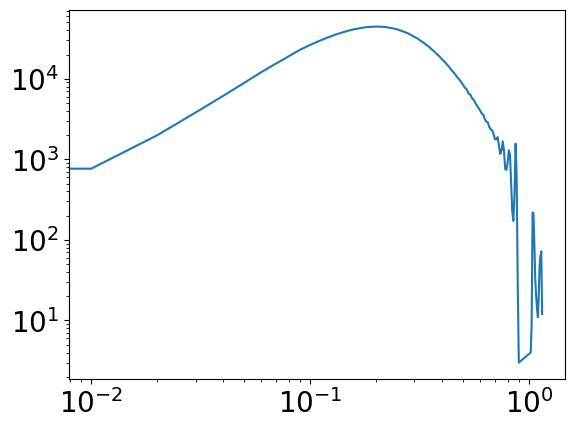

In [21]:
plt.loglog(sdf_cnt)

In [22]:
mpdf.data['sink']

x    y    z         m    h  hsoft  maccreted  spinx  spiny  spinz  ...  \
0  0.0  0.0  0.0  0.001659  0.0   0.05        0.0    0.0    0.0    0.0  ...   

   mdotav  mprev   massenc   J2  Rstrom  rate_ion  tbirth   vx   vy   vz  
0     0.0    0.0  0.066336  0.0     0.0       0.0     0.0  0.0  0.0  0.0  

[1 rows x 25 columns]

Saved to ../fig/20240222_LCGen/phantom-vs-mesa_sol_T-R1.png


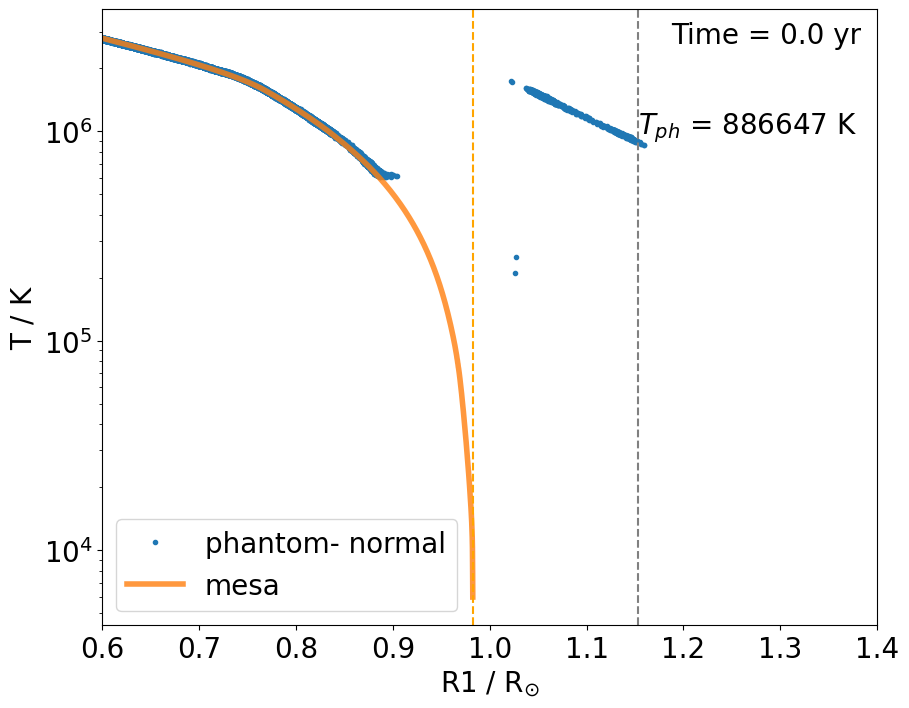

Saved to ../fig/20240222_LCGen/phantom-vs-mesa_sol_rho-R1.png


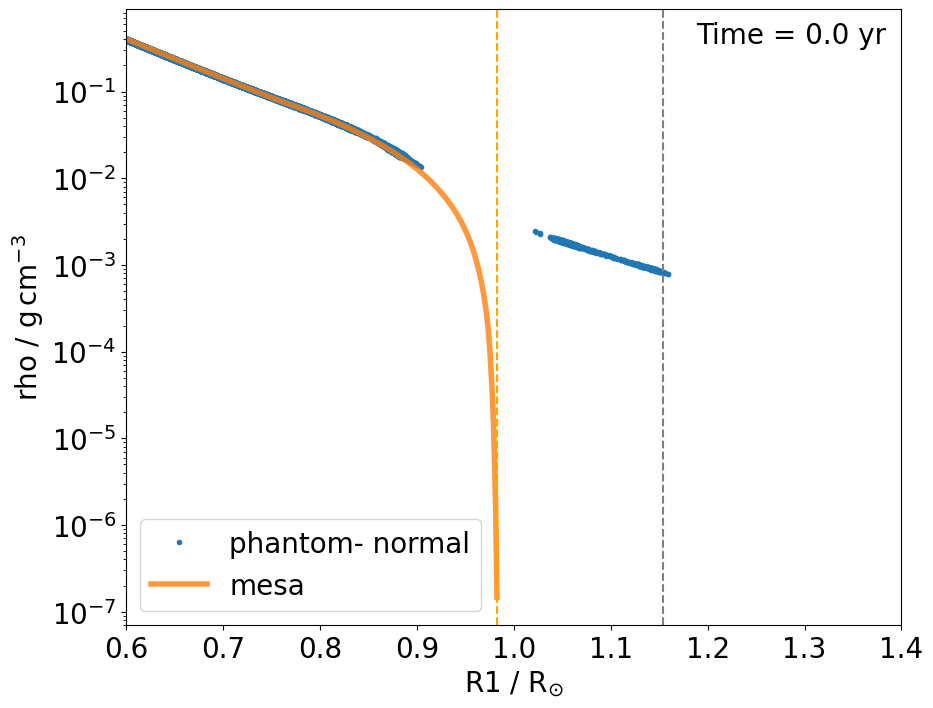

Saved to ../fig/20240222_LCGen/phantom-vs-mesa_sol_kappa-R1.png


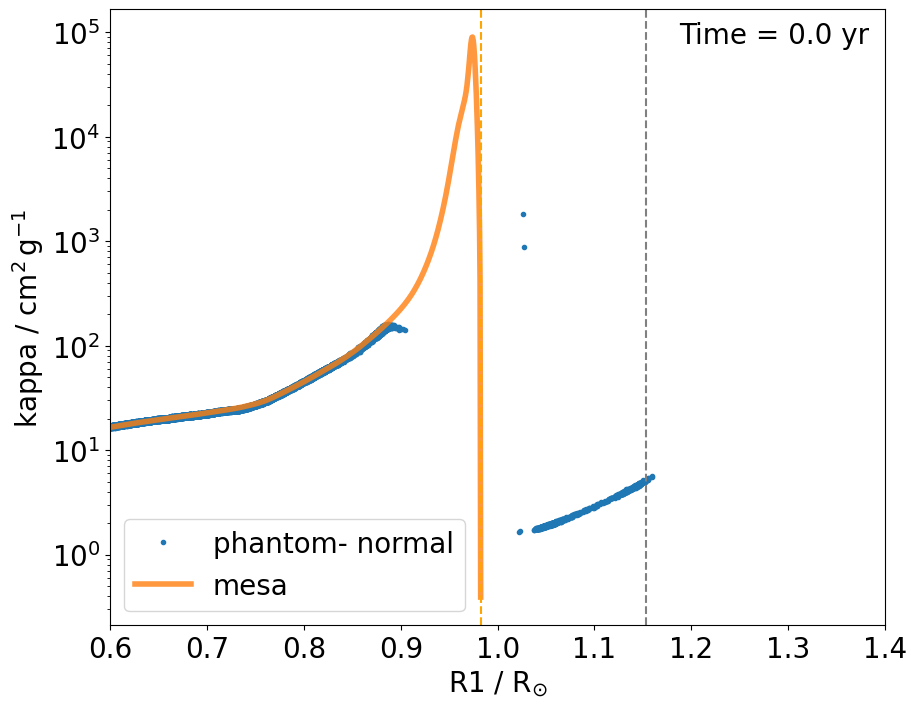

Saved to ../fig/20240222_LCGen/phantom-vs-mesa_sol_tau-R1.png


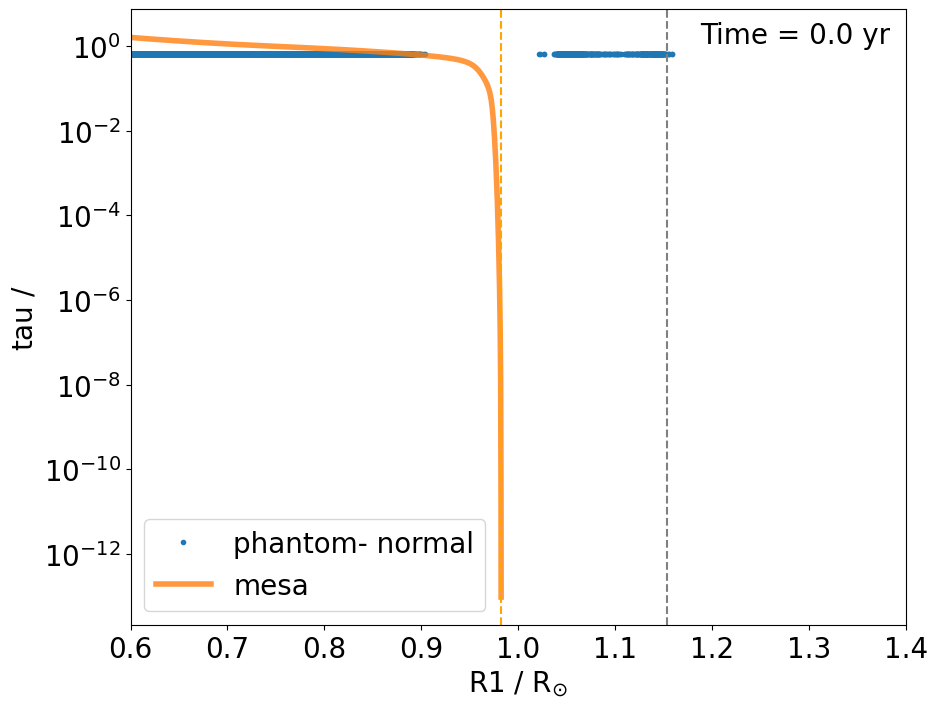

In [23]:
# xlim = (1., 1e3)
# xlim = (252, 268)
xlim = (0.6, 1.4)


plt.close('all')
for what in ['T', 'rho', 'kappa', 'tau']:
    fig, ax, mask = plot_stuff(
        stuff, 'R1', what, mpdf,
        {'plot_title_suffix' : job_nickname + " - phantom vs mesa"},
        xlim=xlim, label=label,
    )

    if do_plot_mesa:
        xs, ys = stuff_mesa['R1'], stuff_mesa[what]
        if isinstance(xs, units.Quantity): xs = xs.value
        if isinstance(ys, units.Quantity): ys = ys.value
        if xlim is None: mask = np.ones_like(xs, dtype=np.bool_)
        else: mask = np.logical_and(xlim[0]*0.99 < xs, xs < xlim[1]*1.01)
        ax.semilogy(xs[mask], ys[mask], '-', label='mesa', linewidth=4, alpha=0.8)
    
    unit = mpdf.get_val(what).unit if what != 'tau' else units.dimensionless_unscaled
    ys_sdf = set_as_quantity(sdf_avg[what], unit).cgs.value
    if False:
        ax.semilogy(sdf_avg['R1'], ys_sdf, 'o--', label='phantom- aggregate', color='C2', linewidth=4, alpha=0.8)
        ax.fill_between(sdf_avg['R1'], set_as_quantity(sdf_valm[what], unit).cgs.value, set_as_quantity(sdf_valp[what], unit).cgs.value, color='C2', alpha=0.4)
    # if do_plot_mesa:
    #     if   what=='T':     ax.set_ylim(2e3, 9e3)
    #     elif what=='rho':   ax.set_ylim(8e-10, 5e-9)
    #     elif what=='kappa': ax.set_ylim(5e-4, 8.0)
    
    ax.axvline(x=stuff_mesa['R1'][0].value, color='orange', linestyle='dashed')
    ax.axvline(x=ph_R1, color='grey', linestyle='dashed')
    if what in {'T'}:
        ax.text(ph_R1, ys_sdf[ph_ind]*1.1, f"${what}_{{ph}}$ = {ys_sdf[ph_ind]:.0f} {unit.cgs.to_string('latex_inline')}")
    ax.legend(loc='lower left')
    outfilename_noext = f"{output_dir}phantom-vs-mesa_{job_nickname}_{what}-R1"
    if use_Tscales: outfilename_noext += f".T{use_Tscales}"

    for ext in ['.png']:  # do NOT save to '.pdf' due to large amount of particles
        outfilename = f"{outfilename_noext}{ext}"
        fig.savefig(f"{outfilename}")
        print(f"Saved to {outfilename}")
    plt.show(fig)

In [60]:
stuff_mesa['rho']

<Quantity [1.47264062e-07, 1.48997809e-07, 1.52170729e-07, 1.56729216e-07,
           1.61830873e-07, 1.66813139e-07, 1.72269482e-07, 1.78119759e-07,
           1.83731817e-07, 1.89081643e-07, 1.94142759e-07, 1.98887886e-07,
           2.03290163e-07, 2.07322200e-07, 2.10952744e-07, 2.14142213e-07,
           2.16179960e-07, 2.17399654e-07, 2.19004613e-07, 2.20559122e-07,
           2.21361786e-07, 2.21808009e-07, 2.22204220e-07, 2.22584703e-07,
           2.23164462e-07, 2.24101678e-07, 2.25250594e-07, 2.26615529e-07,
           2.28178531e-07, 2.29914692e-07, 2.31798956e-07, 2.33808980e-07,
           2.35925611e-07, 2.39202553e-07, 2.43902563e-07, 2.48810784e-07,
           2.53873488e-07, 2.59681089e-07, 2.66286878e-07, 2.71343210e-07,
           2.74710857e-07, 2.79755757e-07, 2.89865328e-07, 3.00251877e-07,
           3.07125686e-07, 3.17362438e-07, 3.27745319e-07, 3.34611873e-07,
           3.41468680e-07, 3.48313814e-07, 3.58503592e-07, 3.72107596e-07,
           3.82309754e-07

In [66]:
dR = 0.01*units.Rsun
R = 1*units.Rsun
V = 4 * pi * R**2 * dR
dM = (V * stuff_mesa['rho'][0]).to(units.Msun)
(dM/mpdf.get_val('m')[0]).si

<Quantity 0.00430982>

In [52]:
sdf_avg

iorig             x             y             z   temperature  \
R1_bin                                                                          
0.00    693183.115385  1.824436e-08 -9.356022e-09  4.854263e-08  1.397399e+07   
0.01    669488.460836 -1.779321e-09  1.784103e-08  2.443049e-08  1.391286e+07   
0.02    679330.074018  7.300957e-10  3.303572e-08  1.984541e-08  1.380158e+07   
0.03    696824.230608  5.745333e-09  2.359802e-08 -5.186733e-10  1.364132e+07   
0.04    687908.212463  1.509096e-08  1.279571e-08 -1.203513e-09  1.344235e+07   
...               ...           ...           ...           ...           ...   
1.11    711559.300000 -6.095466e-02  8.572181e-02  9.405355e-03  1.074977e+06   
1.12    782491.645833 -3.277032e-02 -5.641304e-02 -3.738500e-03  1.016732e+06   
1.13    782928.587302  2.241635e-02 -3.751428e-02 -2.998200e-02  9.720511e+05   
1.14    664653.875000  3.069296e-03  6.695756e-02  1.733610e-03  9.293827e+05   
1.15    516737.250000 -8.706304e-03 -1.629540e-01  6.834436e-02  8.866465e+05   

        gamma   vx   vy   vz         u  ...             m        rho    v  \
R1_bin                                  ...                                 
0.00      0.0  0.0  0.0  0.0  1.527656  ...  7.268700e-07  18.497759  0.0   
0.01      0.0  0.0  0.0  0.0  1.520889  ...  7.268700e-07  18.375879  0.0   
0.02      0.0  0.0  0.0  0.0  1.508557  ...  7.268700e-07  18.154837  0.0   
0.03      0.0  0.0  0.0  0.0  1.490770  ...  7.268700e-07  17.838155  0.0   
0.04      0.0  0.0  0.0  0.0  1.468650  ...  7.268700e-07  17.447642  0.0   
...       ...  ...  ...  ...       ...  ...           ...        ...  ...   
1.11      0.0  0.0  0.0  0.0  0.129851  ...  7.268700e-07   0.000187  0.0   
1.12      0.0  0.0  0.0  0.0  0.122929  ...  7.268700e-07   0.000172  0.0   
1.13      0.0  0.0  0.0  0.0  0.117649  ...  7.268700e-07   0.000160  0.0   
1.14      0.0  0.0  0.0  0.0  0.112602  ...  7.268700e-07   0.000150  0.0   
1.15      0.0  0.0  0.0  0.0  0.107545  ...  7.268700e-07   0.000139  0.0   

         vr             T         kappa        R1       dR1          dtau  \
R1_bin                                                                      
0.00    0.0  1.397399e+07  6.666843e+11  0.007443  0.007443  9.178568e+10   
0.01    0.0  1.391286e+07  6.707176e+11  0.016147  0.008704  1.072751e+11   
0.02    0.0  1.380158e+07  6.781954e+11  0.025734  0.009587  1.180441e+11   
0.03    0.0  1.364132e+07  6.892817e+11  0.035496  0.009762  1.200267e+11   
0.04    0.0  1.344235e+07  7.035858e+11  0.045355  0.009859  1.210294e+11   
...     ...           ...           ...       ...       ...           ...   
1.11    0.0  1.074977e+06  1.388548e+12  1.114822  0.010696  2.781793e+06   
1.12    0.0  1.016732e+06  1.557579e+12  1.126359  0.011536  3.088508e+06   
1.13    0.0  9.720511e+05  1.716334e+12  1.135216  0.008857  2.437809e+06   
1.14    0.0  9.293827e+05  1.902093e+12  1.144424  0.009208  2.621110e+06   
1.15    0.0  8.866465e+05  2.134166e+12  1.153396  0.008973  2.665077e+06   

                 tau  
R1_bin                
0.00    3.158137e+12  
0.01    3.066351e+12  
0.02    2.959076e+12  
0.03    2.841032e+12  
0.04    2.721005e+12  
...              ...  
1.11    1.359430e+07  
1.12    1.081250e+07  
1.13    7.723995e+06  
1.14    5.286186e+06  
1.15    2.665077e+06  

[105 rows x 26 columns]

In [47]:
np.count_nonzero(sdf['R1']>1)

824

In [48]:
len(sdf)

1372092

In [47]:
T_mesa = 3227 * units.K
f"{(T_avg / T_mesa)**4 = }"

'(T_avg / T_mesa)**4 = <Quantity 10.12906406>'

*   Note   :    plot_phantom_vs_mesa_comb() ==> mpdf_read() ==> read():
	

	Reading filename='../raw/luis_2md/light_00000'


*   Note   :    mpdf_read() ==> read() ==> reset_xyz_by():
	Reseting Origin to R1 ([-1.43135206e+02  6.48807731e-03  5.43625638e-03])...
*   Note   :    mpdf_read() ==> read() ==> reset_xyz_by():
	CoM location is now [ 1.43135206e+02 -6.48807731e-03 -5.43625638e-03]
**  Warning:    plot_phantom_vs_mesa_comb() ==> mpdf_read() ==> read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
    Note: Density column rho already exist in self.time = np.float64(0.0).
*   Note   :    plot_phantom_vs_mesa_comb() ==> mpdf_read() ==> read():
	

	

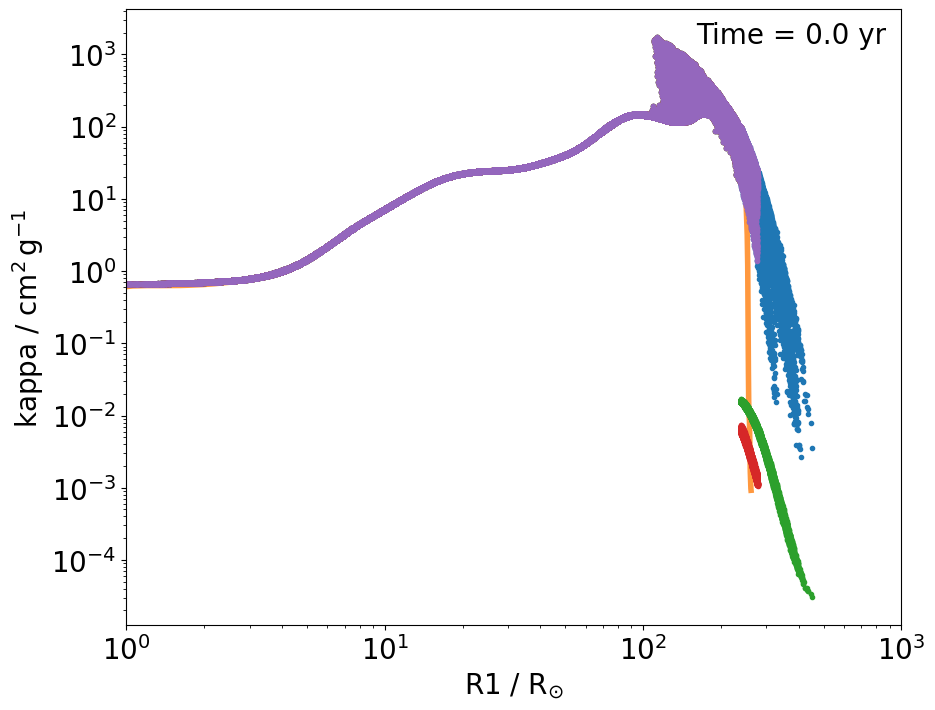

Saved to ../fig/20240222_LCGen/phantom-vs-mesa_2md_rho-R1_comb.png
Saved to ../fig/20240222_LCGen/phantom-vs-mesa_2md_kappa-R1_comb.png


In [18]:
# reading phantom data

def plot_phantom_vs_mesa_comb(
    job_nickname= '2md',
    use_Tscales_list = ['', 'scale', 'cut', 'delete'],
    xlim = (1., 1e3),
    whats= ['T', 'rho', 'kappa'],
):
    
    job_profile = JOB_PROFILES_DICT[job_nickname]
    job_name    = job_profile['job_name']
    params      = job_profile['params']
    eos_opacity = EoS_MESA_opacity(params, settings)

    stuff_mesa = read_mesa_data(eos_opacity)

    plt.close('all')

    figs = {what: None for what in whats}

    for use_Tscales in use_Tscales_list:
        mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by='R1', use_Tscales=use_Tscales)
        mpdf.calc_sdf_params(['R1'])
        sdf  = mpdf.data['gas']
        ray = mupl.get_rays(mpdf.data['sink'][['x', 'y', 'z']].iloc[0], np.array([0., 0., 1.]))
        srcfuncs = mpdf.const['sigma_sb'] * sdf['T']**4 #/ (4 * pi)

        stuff = {}
        stuff['kappa'] = mpdf.get_val('kappa').cgs
        stuff['R1'   ] = mpdf.get_val('R1').to(units.Rsun)
        stuff['T'    ] = mpdf.get_val('T').to(units.K)
        stuff['L'    ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T']**4)).to(units.Lsun)
        stuff['rho'  ] = mpdf.get_val('rho').cgs
        label=f'phantom- ' + (f'T{use_Tscales}' if use_Tscales else 'normal')

        for what in whats:
            if not figs[what]:
                # init
                figs[what] = plot_stuff(
                    stuff, 'R1', what, mpdf,
                    {'plot_title_suffix' : job_nickname + " - phantom vs mesa"},
                    xlim=xlim, label=label,
                )
                fig, ax, _ = figs[what]
                
                # plot mesa
                xs, ys = stuff_mesa['R1'], stuff_mesa[what]
                if isinstance(xs, units.Quantity): xs = xs.value
                if isinstance(ys, units.Quantity): ys = ys.value
                if xlim is None: mask = np.ones_like(xs, dtype=np.bool_)
                else: mask = np.logical_and(xlim[0] < xs, xs < xlim[1])
                ax.loglog(xs[mask], ys[mask], '-', label='mesa', linewidth=4, alpha=0.8)
                if what=='T': ax.set_ylim(1e3, 3e6)
            else:
                fig, ax, _ = figs[what]
                ax.loglog(stuff['R1'], stuff[what], '.', label=label)
            
        

    for what in whats:
        fig, ax, _ = figs[what]
        ax.axvline(x=stuff_mesa['R1'][0].value, color='grey', linestyle='dashed')
        ax.legend(loc='lower left')
        outfilename_noext = f"{output_dir}phantom-vs-mesa_{job_nickname}_{what}-R1_comb"
    
        for ext in ['.png']:  # do NOT save to '.pdf' due to large amount of particles
            outfilename = f"{outfilename_noext}{ext}"
            fig.savefig(f"{outfilename}")
            print(f"Saved to {outfilename}")

    return fig, ax
fig, ax = plot_phantom_vs_mesa_comb()

### Timeit

In [ ]:
xyzs = 'yzx'
xyzs_names_list = [x for x in xyzs]
ans = integrate_along_ray_gridxy(sdf, srcfuncs, rays, xyzs_names_list=xyzs_names_list)
plt.close('all')
plt.imshow(ans.reshape(no_xy))
plt.savefig(f"{output_dir}/heat_I_{job_nickname}_{mpdf.file_index}_{xyzs}.png")
ans

In [ ]:
%timeit integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)

In [ ]:
%timeit integrate_along_ray_gridxy(sdf, srcfuncs, rays, verbose=0)

### Analyzing error for tau

In [ ]:
# integrating for column kernel
kernel = sdf.kernel
ndim   = 3
q_xy   = 1.
w_col  = kernel.get_column_kernel_func(1000)

q_xy   = 0.

@jit(nopython=True, fastmath=True)
def get_q(*q_is):
    ans = 0
    for q_i in q_is:
        ans += q_i**2
    return ans**0.5


def get_w_q(q_z, q_xy, w, ndim):
    return kernel.w(get_q(q_xy, q_z), ndim)

def my_col(q_xy:float, kernel, ndim:int = 3):
    w = kernel.w
    w_rad = kernel.get_radius()
    return integrate.quad(lambda q_z: w(get_q(q_xy, q_z), ndim), -w_rad, w_rad)
    
#my_col(q_xy, kernel=kernel, ndim=ndim),  w_col(q_xy, ndim)

In [ ]:


def get_tau_for_single_particle(kappa_m_div_h2:float, q_xy:float, kernel, ndim:int = 3):
    w = kernel.w
    w_rad = kernel.get_radius()
    w_col = kernel.get_column_kernel_func(1000)

    return -np.log(integrate.quad(
        lambda q_z: np.exp(-kappa_m_div_h2 * integrate.quad(
            lambda q_z1: w(get_q(q_xy, q_z1), ndim),
            -w_rad, q_z
        )[0]) * w(get_q(q_xy, q_z), ndim),
        -w_rad, w_rad, 
    )[0] / w_col(q_xy, ndim))

kappa_m_div_h2, q_xy = 100., 1.5
dtau  = kappa_m_div_h2*w_col(q_xy, ndim)
w_col = kernel.get_column_kernel_func(1000)
term = 1-np.exp(-dtau)
tau = get_tau_for_single_particle(kappa_m_div_h2=kappa_m_div_h2, q_xy=q_xy, kernel=kernel, ndim=ndim)
print(f"{tau=}", f"{dtau=}", f"frac= {(tau/dtau)*100:.2f}%", '', sep='\n')
print(
    f"{np.exp(-tau    )*term=}",
    f"{np.exp(-tau    )*dtau=}",
    f"{np.exp(-0.     )*term=}",
    f"{np.exp(-dtau/2.)*term=}",
    f"{np.exp(-dtau   )*term=}",
    sep='\n')

In [ ]:
w_col

In [ ]:
kappa_m_div_h2 * integrate.quad(
            lambda q_z1: w(get_q(q_xy, q_z1), ndim),
            -2., 1.)[0]

In [ ]:
help(kernel.get_column_kernel_func)

### In Writing

#### Getting LC

In [ ]:
do_extrap : bool = False
T_cond_oxy: units.Quantity = 1450 * units.K
kappa_gas : units.Quantity = 2e-4*(units.cm**2/units.g)
job_name    = '../dustystar/clmu_dustybase/relax'#job_profile['job_name']
file_index  = 0
params      = JOB_PROFILES_DICT['2md']['params'] #job_profile['params']


mpdf = mupl.MyPhantomDataFrames()
mpdf.read(job_name, file_index, reset_xyz_by='CoM', calc_params=['vr', 'R1'], verbose=verbose)
sdf  = mpdf.data['gas']
eos = mupl.get_eos(ieos=10, params=params, settings=settings)
eos_opacity = EoS_MESA_opacity(params, settings)
sdf['T'] = eos.get_temp(rho=mpdf.get_val('rho'), u=mpdf.get_val('u')).to_value(mpdf.units['temp'])
del sdf['Tdust']
kappa_mesa = eos_opacity.get_kappa(mpdf.get_val('rho'), mpdf.get_val('T'), do_extrap=do_extrap)
#mpdf.data['gas']['kappa'] = np.where(
#    mpdf.data['gas']['T'] < T_cond_oxy,
#    kappa_gas.to_value( mpdf.units['opacity']),
#    kappa_mesa.to_value(mpdf.units['opacity']),
#)
mpdf.data['gas']['kappa'] = kappa_mesa.to_value(mpdf.units['opacity'])

In [ ]:
# testing ray loc distribution
rays, areas, dXs = get_xy_grids_of_rays(sdf, no_xy=(32, 32), frac_contained=100., use_adaptive_grid=False)
plt.plot(rays[:, 0, 0], rays[:, 0, 1], '.')

In [ ]:
hs = dats
hs

In [ ]:
#no_xy=(17, 17)
no_xy=(32, 32)
srcfuncs = np.array(mpdf.const['sigma_sb'] * sdf['T']**4) / pi #/ (4 * pi)
#srcfuncs = np.array(sdf['h'])


rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
dats = integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)
lums = (4 * pi * dats * areas * mpdf.units['lum']).to(units.solLum)
lum  = lums.sum()
print(f"{lum:.2e}")
lum

In [ ]:
plt.hist(np.log10(mpdf.get_val('T').value))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.loglog(np.sqrt(rays[:, 0, 0]**2+rays[:, 0, 1]**2), lums.to_value(units.Lsun) / areas, '.')
ax.set_xlabel('$R_\\mathrm{CoM}$ / Rsun')
ax.set_ylabel('$I \\, / \\, (4 \pi L_\\odot / R_\\odot^2)$')
#ax.set_ylabel('$\\triangle L$ / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nbefore relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/scatter_dlum-vs-RCoM_relax_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=np.array(lums).reshape(no_xy))
fig.colorbar(s, label='')# {I / (4 \pi L_\\odot / R_\\odot^2)}$')
ax.set_xlabel('$x$ / Rsun')
ax.set_ylabel('$y$ / Rsun')
ax.set_title(f"Integrated  specfic intensity contribution per ray\nbefore relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_dlum_relax_res{mpdf.params['nparttot']:.2e}.png")